# Learnable initialization

**Goal:** Lukas was saying for the official paper, even in the _first step_ should be mostly getting a good view of the image.


<insert picture>
    
    
**Try making the $\mu$ and $\sigma$ learnable, and see if this helps!**

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

# IO pkgs
import yaml, json
from glob import glob

# custom code
import os
os.sys.path.append('code')
from plotting import plot_kslots, plot_kslots_iters
from data import make_batch
from train import train
from model import build_grid, SoftPositionalEmbed

In [2]:
from torch.nn import init

In [3]:
cID = '2rings-sqrtD-Q128'
config = f'code/configs/{cID}.yaml'

with open(config, "r")as cfile:
    cdict = yaml.safe_load(cfile)

opt = cdict["opt"]
hps = cdict["hps"]
kwargs = cdict["data"] # to pass to the data loading fct

del hps['softmax_T']

In [4]:
# # Load in the weights 
# print(f'Starting from an earlier training')

# # Check for what was the last training iteration
# modelChkpts = glob(f'code/models/{cID}/m_*.pt')
# if len(modelChkpts) == 0:
#     print('ERROR -- No files fround for',modelChkpts, 'when requesting to train from warm_start')
#     raise FileNotFoundError

# savedIters = [mName.split('/')[-1].split('.')[0].split('_')[-1] for mName in modelChkpts   ]
# savedIters = np.array([int(i) for i in savedIters])                     
# lastIter = np.max(savedIters)

# modelToLoad = f'code/models/2rings-sqrtD/m_{lastIter}.pt'

In [5]:
class SlotAttentionLearnInit(torch.nn.Module):
    def __init__(self, 
                 resolution=(32,32),
                 k_slots=3, 
                 hidden_dim=32, 
                 query_dim=32, 
                 n_iter=2,
                 device='cpu',
                 dtype=torch.float32
                 ):
        '''
        Slot attention encoder block with _learnable_ positional embedding

        Inputs:
        - device (cpu, mps, cuda): Which device to put the model on 
                (needed for the random call when initializing the slots)
        - k_slots: number of slots (note, can vary between training and test time)
        - hidden_dim: The hidden dimension for the CNN (currently single layer w/ no non-linearities)
        - query_dim: The latent space dimension that the slots and the queries get computed in
        - n_iter: Number of slot attention steps to apply (defualt 2, and rn hard coded)
        '''
        super().__init__()

        self.k_slots = k_slots
        self.hidden_dim = hidden_dim
        self.query_dim = query_dim
        self.n_iter = n_iter

        self.resolution = resolution
        
        self.device=device
        self.dtype=dtype
        
        self.dataN = torch.nn.LayerNorm(self.hidden_dim)
        self.queryN = torch.nn.LayerNorm(self.query_dim)
        
        self.toK = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.toV = torch.nn.Linear(self.hidden_dim, self.query_dim)
        self.gru = torch.nn.GRUCell(self.query_dim, self.query_dim)

        
        
        
        filter_size=5
        self.CNN_encoder = torch.nn.Sequential(
            torch.nn.Conv2d(1,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
            torch.nn.ReLU(),
            torch.nn.Conv2d(self.hidden_dim,self.hidden_dim,filter_size, padding = 2),
        )
        
        self.posEnc = SoftPositionalEmbed(hidden_dim, resolution,device)
        
        self.init_mlp = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim,hidden_dim),
            torch.nn.ReLU(),
            torch.nn.Linear(hidden_dim,hidden_dim)
        )
        
        
        self.slots_mu = torch.nn.Parameter(torch.randn(1, 1, self.query_dim))
        self.slots_logsigma = torch.nn.Parameter(torch.zeros(1, 1, self.query_dim))
        init.xavier_uniform_(self.slots_logsigma)


    def init_slots(self,Nbatch):
        '''
        Slot init taken from
        https://github.com/lucidrains/slot-attention/blob/master/slot_attention/slot_attention.py
        '''
        mu = self.slots_mu.expand(Nbatch, self.k_slots, -1)
        sigma = self.slots_logsigma.exp().expand(Nbatch, self.k_slots, -1)

        return mu + sigma * torch.randn(mu.shape).to(self.device)

    def encoder(self,data):
        
        # Apply the CNN encoder
        encoded_data = self.CNN_encoder(data)
        
        # Put the channel dim at the end
        encoded_data = torch.permute(encoded_data,(0,2,3,1)) 
                 
        # Add the positional embeddings
        encoded_data = self.posEnc(encoded_data)
        
        # Flatten the pixel dims and apply the data normalization + MLP
        encoded_data = torch.flatten(encoded_data,1,2)
        encoded_data = self.dataN(encoded_data)
        encoded_data = self.init_mlp(encoded_data)
        
        return encoded_data
    
    # hook for the gradients of the activations
    def activations_hook(self, grad):
        self.gradients.append( grad )
    
    def attention_and_weights(self,queries,encoded_data):
        keys = self.toK(encoded_data)
        logits = torch.einsum('bse,bde->bsd',queries,keys) * (self.query_dim ** (-0.5)) 
        
        att = torch.nn.functional.softmax(logits, dim = 1)

        if att.requires_grad:
            h = logits.register_hook(self.activations_hook)
        
        div = torch.sum(att, dim = -1, keepdims = True)
        wts = att/div + 1e-8
        return att,wts

    def iterate(self, queries, encoded_data):
        
        # queries: (bs, k_slots, query_dim)
        
        att,wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
        
        # att: (bs, k_slots, img_dim)
        # wts: (bs, k_slots, img_dim)
        
        vals = self.toV(encoded_data) # bs, img_dim, query_dim
        updates = torch.einsum('bsd,bde->bse',wts,vals) # bs, n_slots, query_dim
        
        updates = self.gru(
            updates.reshape(-1,self.query_dim),
            queries.reshape(-1,self.query_dim),
        )

        return updates.reshape(queries.shape)
        
    def forward(self, data):

        self.gradients = []
        
        Nbatch = data.shape[0]
        
        # Initialize the queries
        queries = self.init_slots(Nbatch) # Shape (Nbatch, k_slots, query_dim)
        
        encoded_data = self.encoder(data)
        
        for i in range(self.n_iter):
            queries = self.iterate(queries, encoded_data)    
            
        # Then with the _final_ query vector, calc what the attn + weights would be
        att, wts = self.attention_and_weights(self.queryN(queries),encoded_data)   
            
        return queries, att, wts
    

In [6]:
device = 'cuda:0'

In [7]:
sa = SlotAttentionLearnInit(device=device,**hps).to(device)

In [8]:
cID = 'learn-init'

modelDir = f'code/models/{cID}'
figDir = f'code/figures/{cID}'

In [9]:
opt['Ntrain'] = 100_000

Training model with 3 slots on 2rings


/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/data.py:94: RuntimeWarning: invalid value encountered in true_divide
  eventMasks = np.where(eventHistograms>0,eventMasks/eventHistograms,eventMasks)
/gpfs/slac/atlas/fs1/d/nhartman/Slot Attention/code/train.py:41: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  /opt/conda/conda-bld/pytorch_1634272068694/work/torch/csrc/utils/tensor_new.cpp:201.)
  indices = torch.LongTensor(indices)


iter 0 , loss 0.80494714 , lr 0.0


iter 250 , loss 0.77297544 , lr 1.4948103942418015e-05


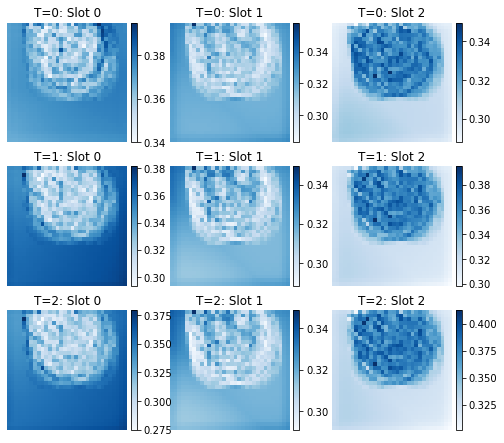

iter 500 , loss 0.48284322 , lr 2.9792774863111075e-05


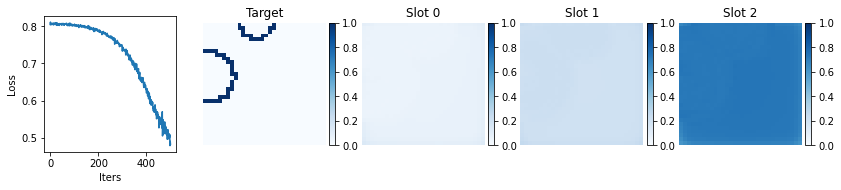

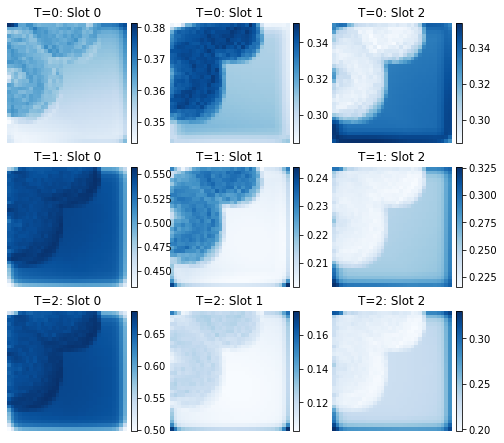

iter 750 , loss 0.22211686 , lr 4.4534549538684304e-05


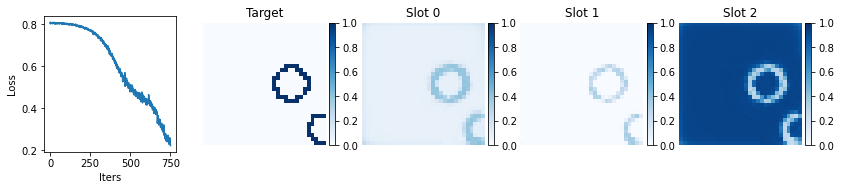

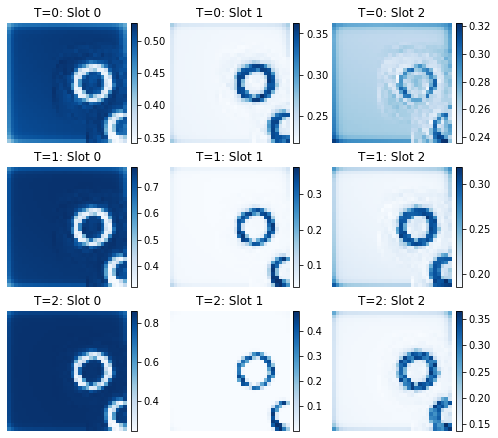

iter 1000 , loss 0.14200824 , lr 5.917396226960155e-05


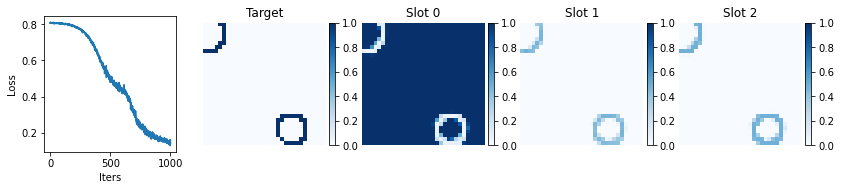

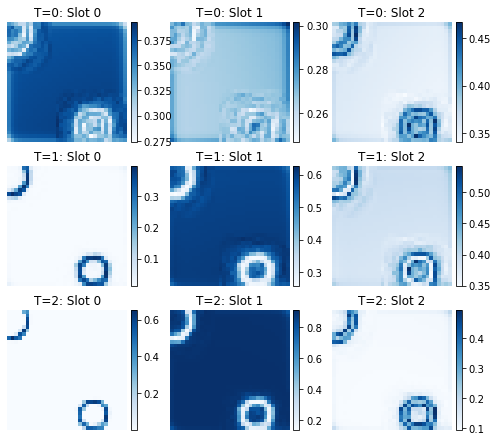

iter 1250 , loss 0.11983956 , lr 7.371154489089383e-05


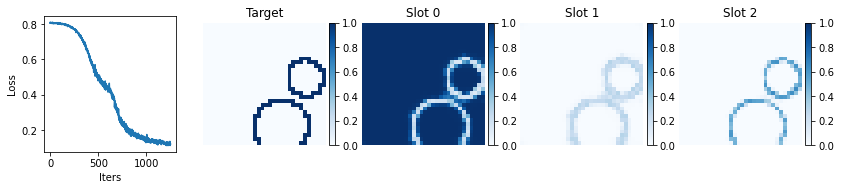

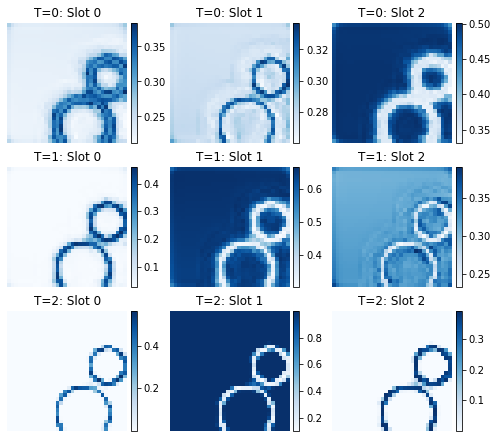

iter 1500 , loss 0.111341506 , lr 8.81478267828234e-05


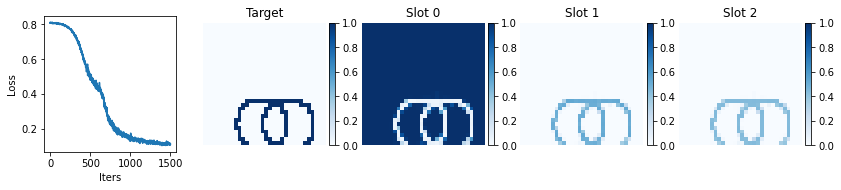

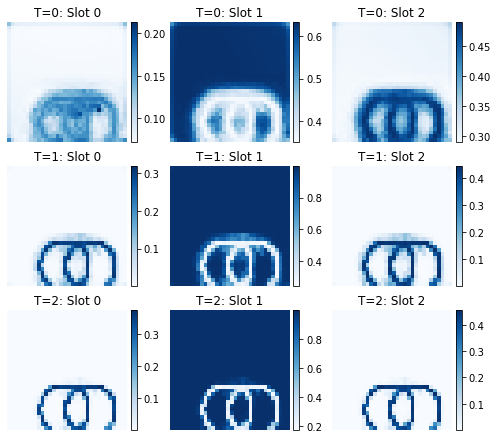

iter 1750 , loss 0.10067803 , lr 0.00010248333488150358


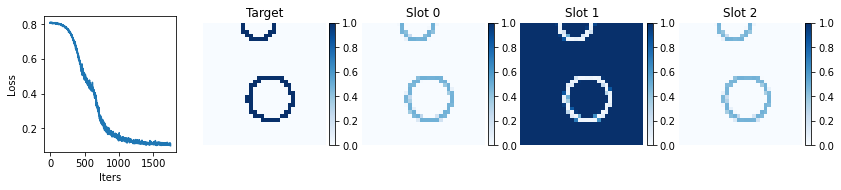

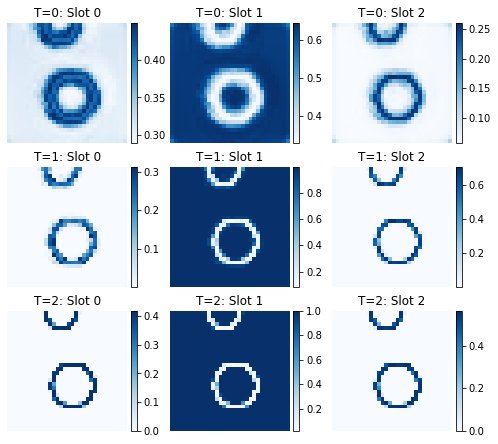

iter 2000 , loss 0.10787941 , lr 0.00011671859368947427


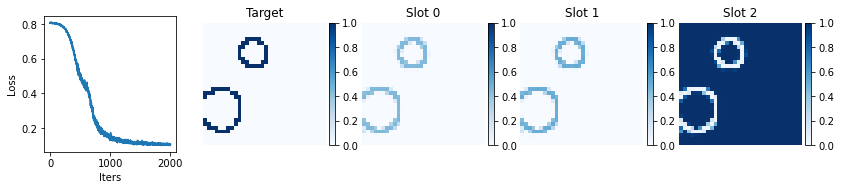

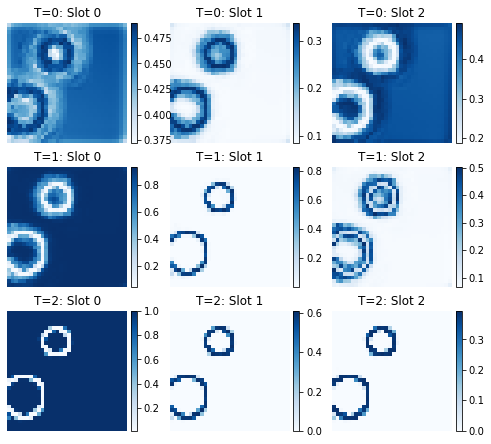

iter 2250 , loss 0.10564523 , lr 0.00013085412528623374


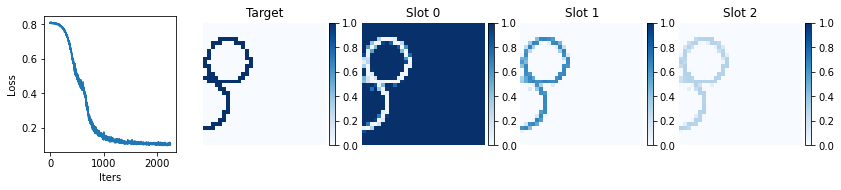

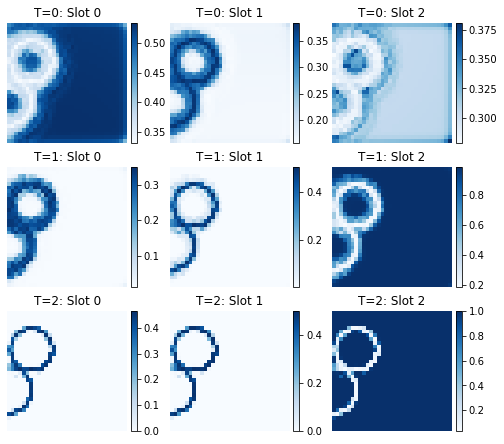

iter 2500 , loss 0.10548888 , lr 0.00014489044933872682


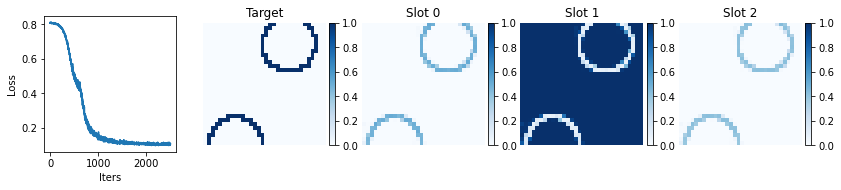

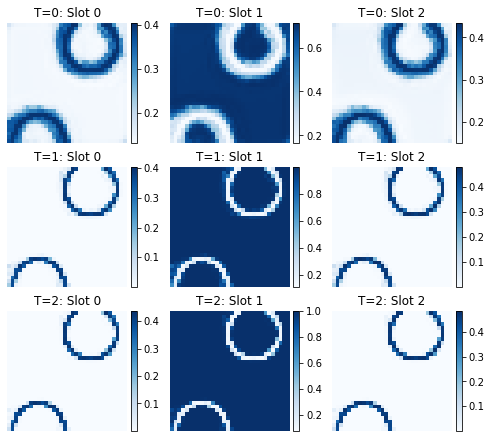

iter 2750 , loss 0.102579966 , lr 0.00015882808311178898


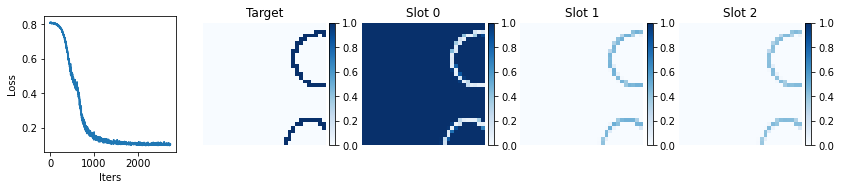

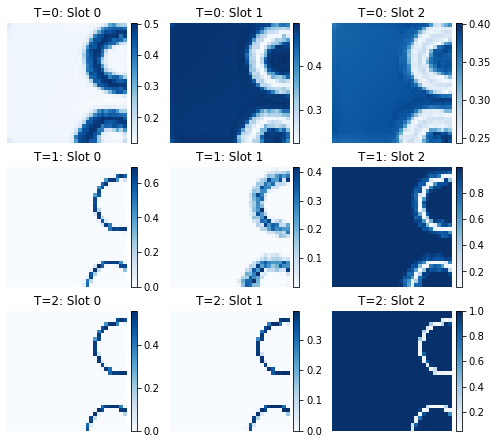

iter 3000 , loss 0.103868745 , lr 0.00017266754147854757


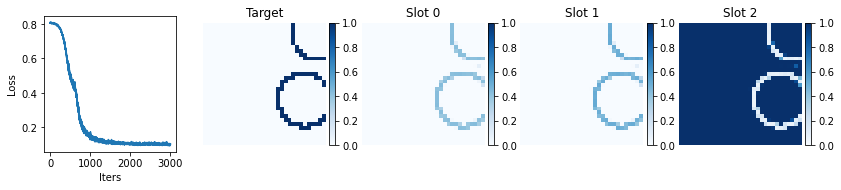

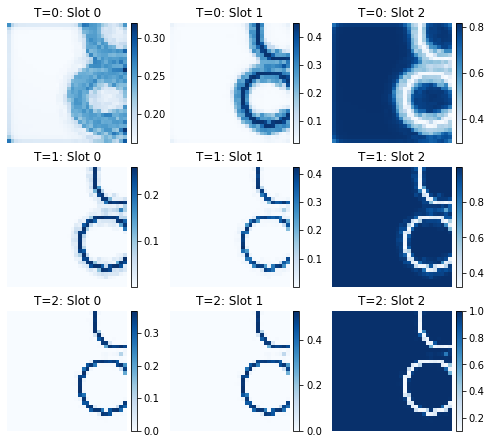

iter 3250 , loss 0.10050638 , lr 0.0001864093369307797


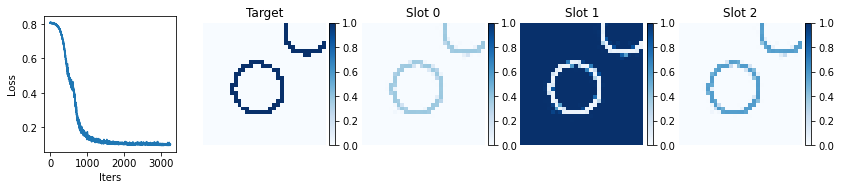

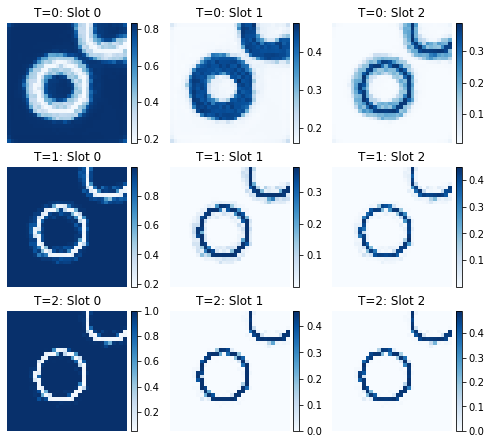

iter 3500 , loss 0.093418896 , lr 0.0002000539795892268


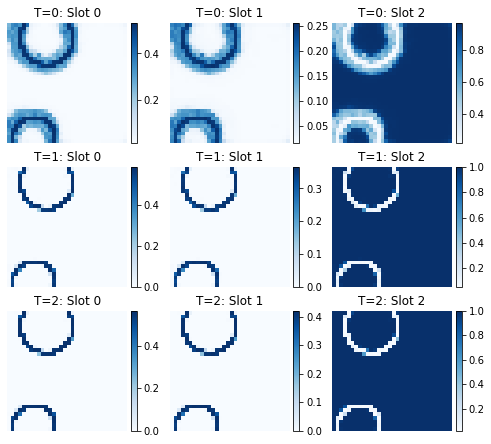

iter 3750 , loss 0.1019783 , lr 0.0002136019772138668


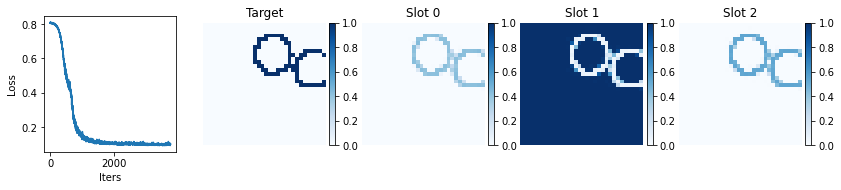

iter 4000 , loss 0.09531498 , lr 0.00022705383521414303


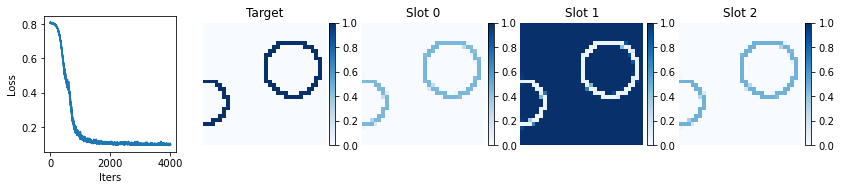

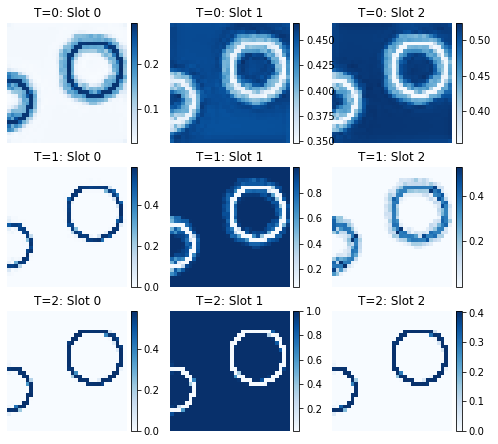

iter 4250 , loss 0.09926671 , lr 0.00024041005665915104


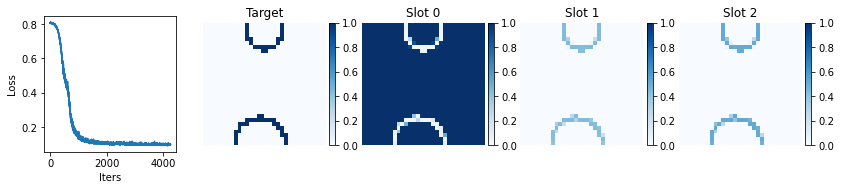

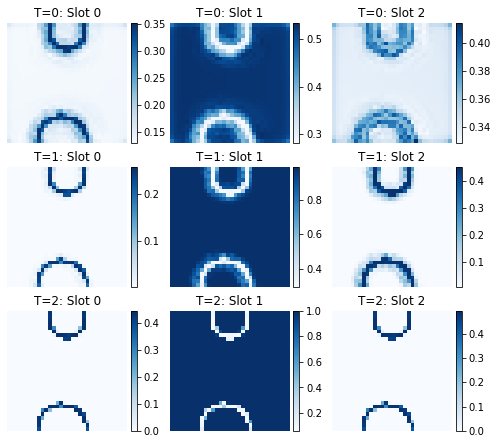

iter 4500 , loss 0.096845806 , lr 0.0002536711422877832


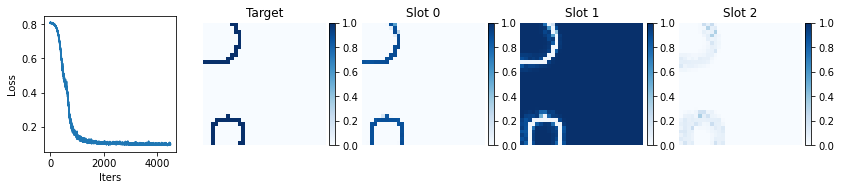

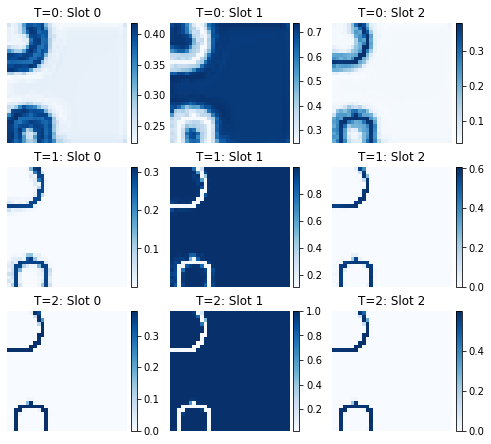

iter 4750 , loss 0.09337795 , lr 0.00026683759051883025


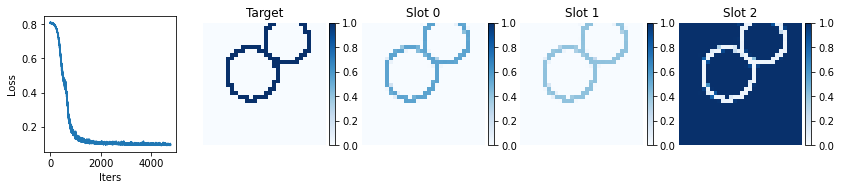

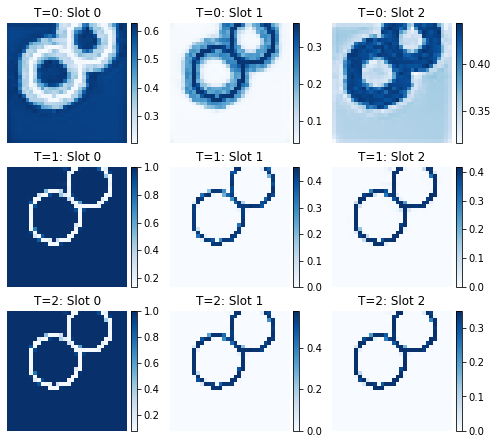

iter 5000 , loss 0.098151326 , lr 0.0002799098974610422


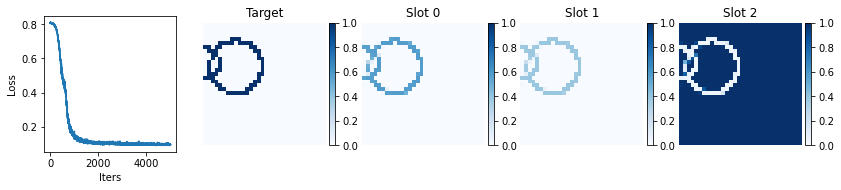

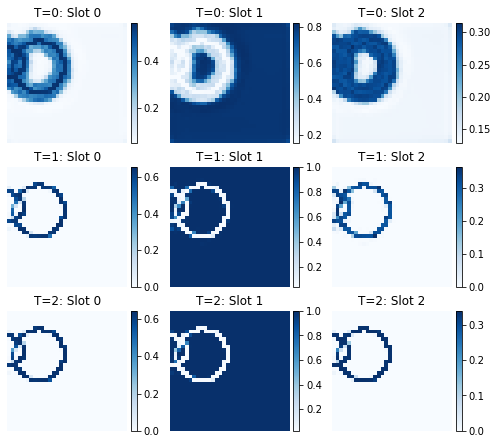

iter 5250 , loss 0.09797281 , lr 0.0002789414827839485


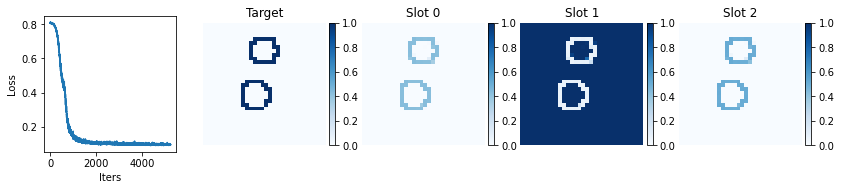

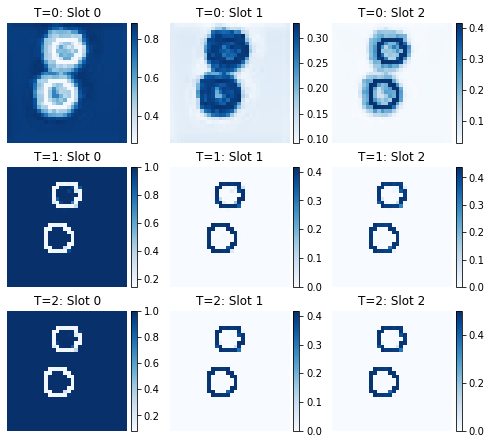

iter 5500 , loss 0.092142254 , lr 0.00027797641856711124


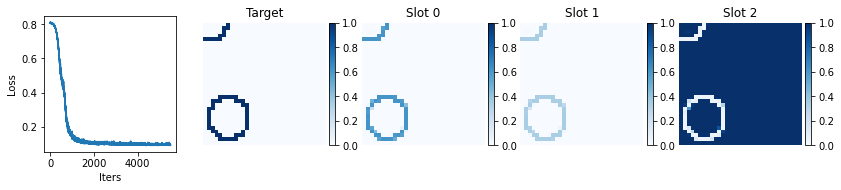

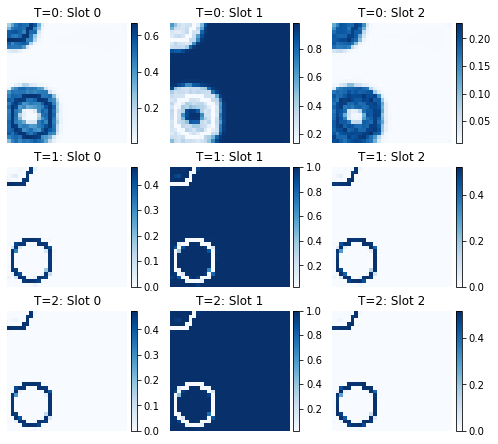

iter 5750 , loss 0.09517605 , lr 0.0002770146932188184


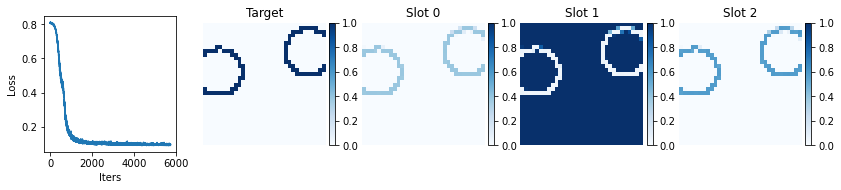

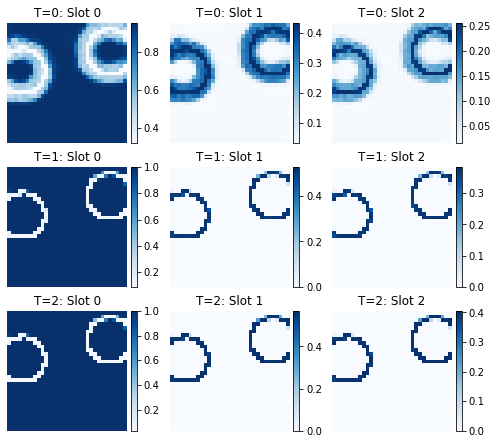

iter 6000 , loss 0.094758116 , lr 0.0002760562951874625


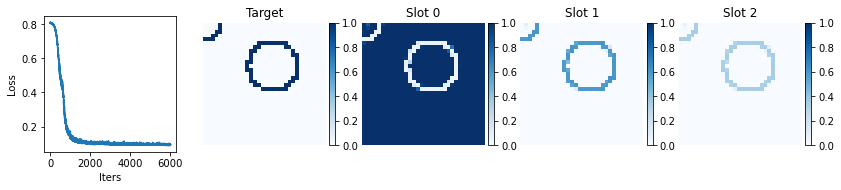

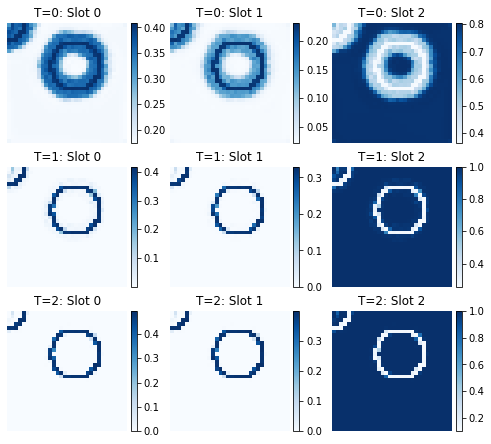

iter 6250 , loss 0.09385447 , lr 0.0002751012129614013


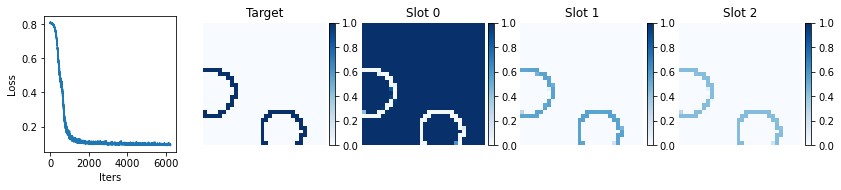

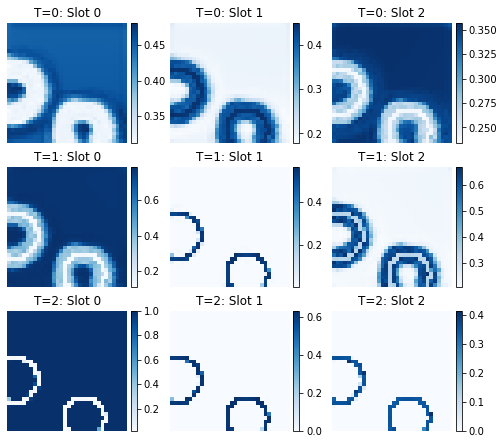

iter 6500 , loss 0.08992512 , lr 0.0002741494350688201


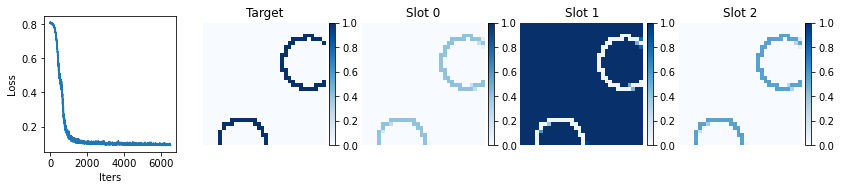

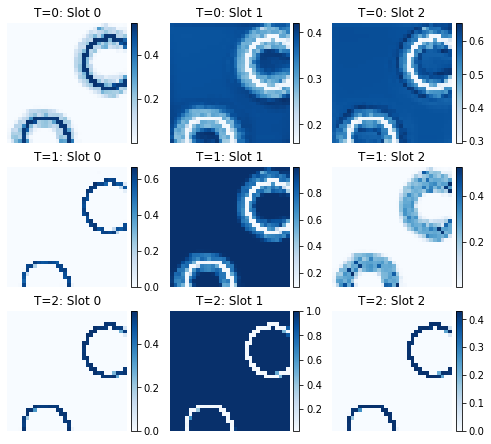

iter 6750 , loss 0.09227336 , lr 0.0002732009500775935


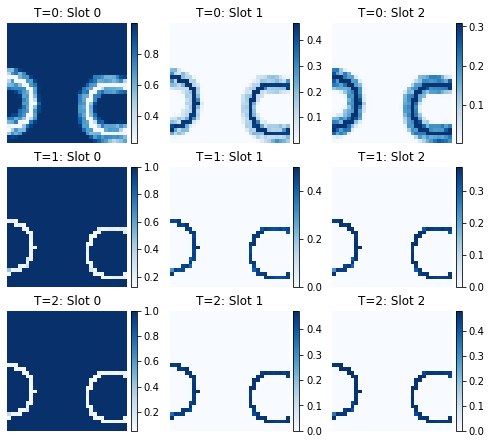

iter 7000 , loss 0.09306958 , lr 0.00027225574659514823


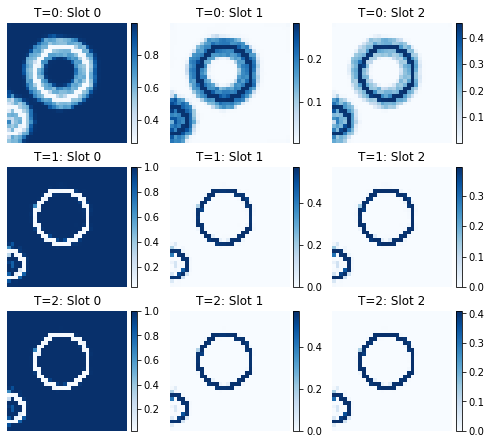

iter 7250 , loss 0.09448047 , lr 0.0002713138132683264


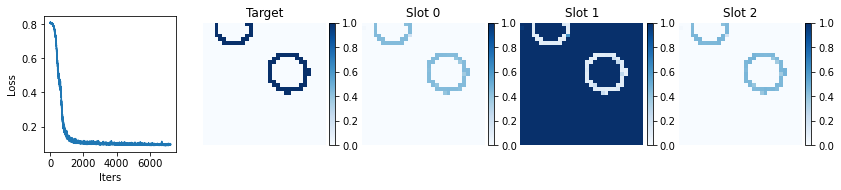

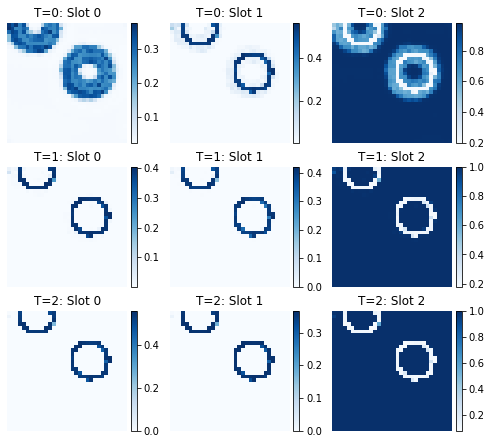

iter 7500 , loss 0.09091553 , lr 0.00027037513878324905


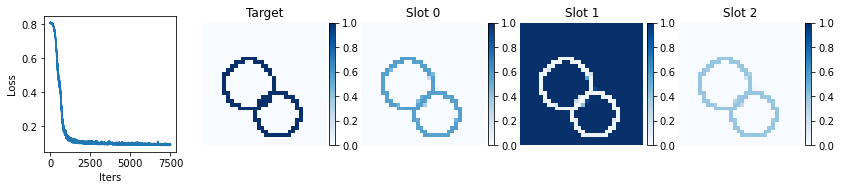

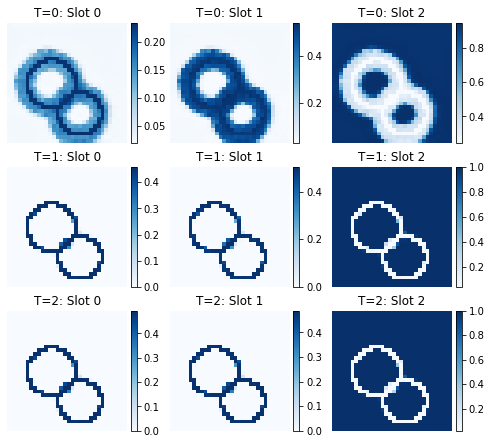

iter 7750 , loss 0.08858135 , lr 0.00026943971186518025


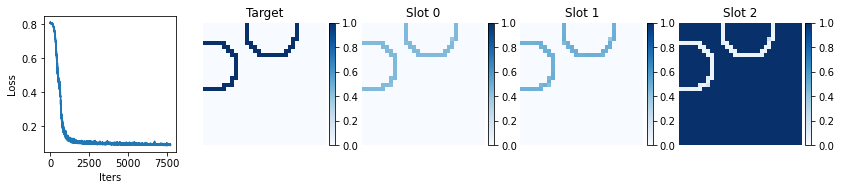

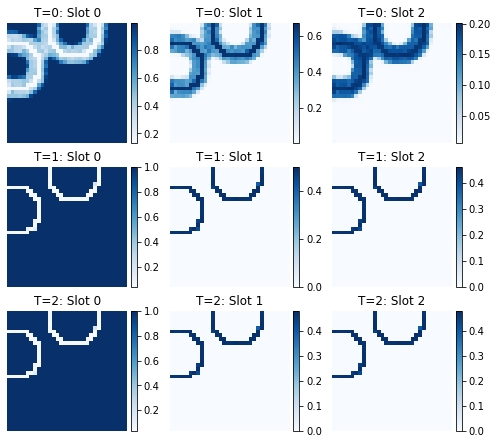

iter 8000 , loss 0.09191039 , lr 0.00026850752127839173


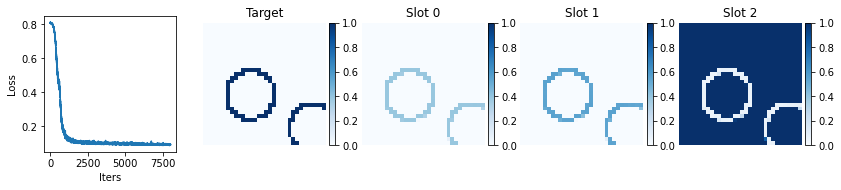

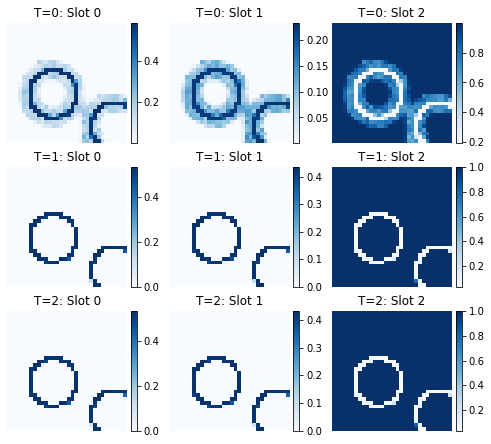

iter 8250 , loss 0.091421224 , lr 0.00026757855582602776


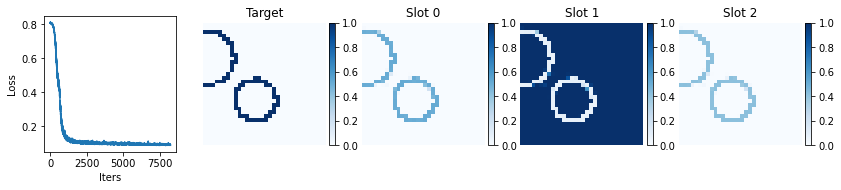

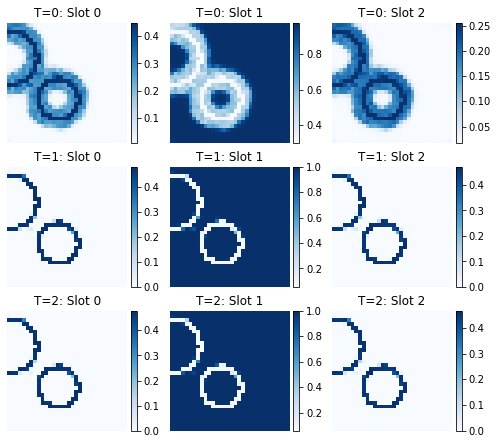

iter 8500 , loss 0.09041119 , lr 0.00026665280434997105


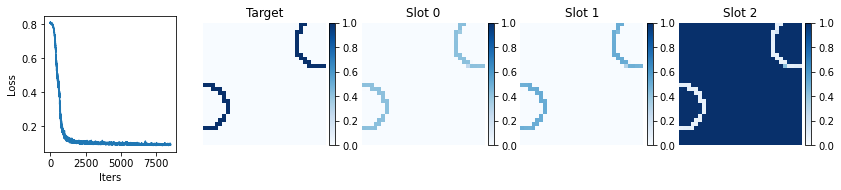

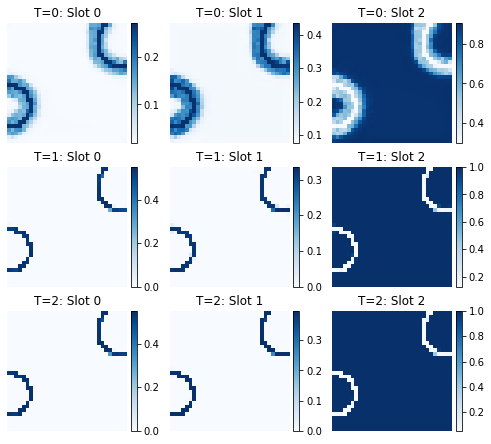

iter 8750 , loss 0.09239203 , lr 0.00026573025573070814


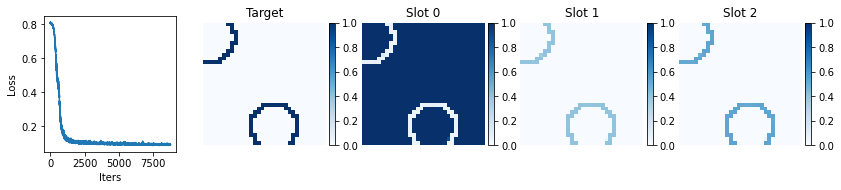

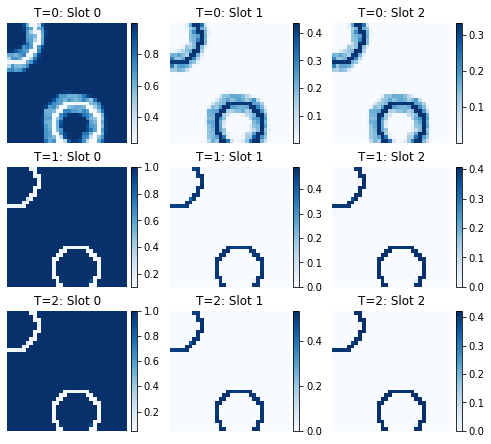

iter 9000 , loss 0.093192466 , lr 0.00026481089888719643


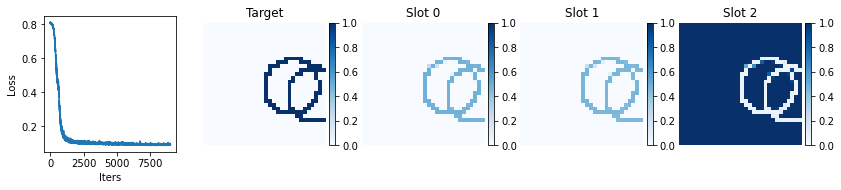

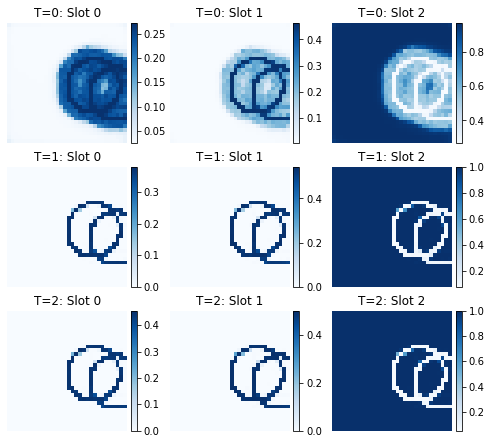

iter 9250 , loss 0.09128829 , lr 0.0002638947227767307


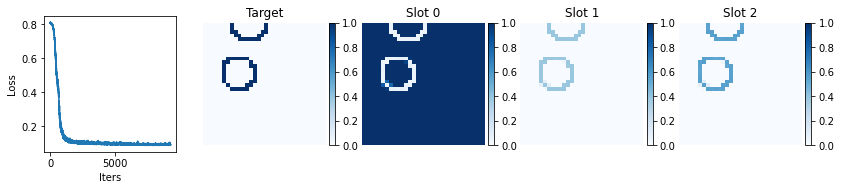

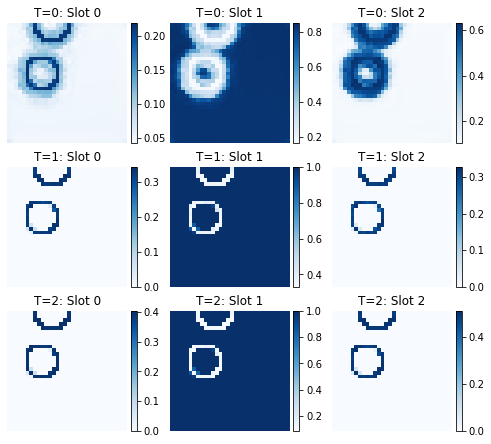

iter 9500 , loss 0.09393376 , lr 0.0002629817163948105


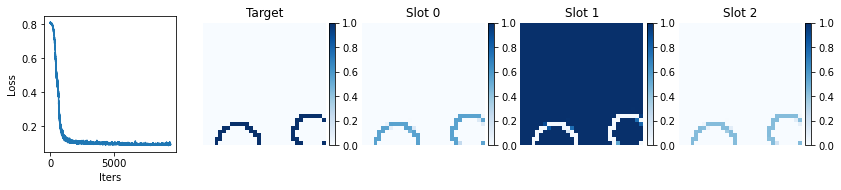

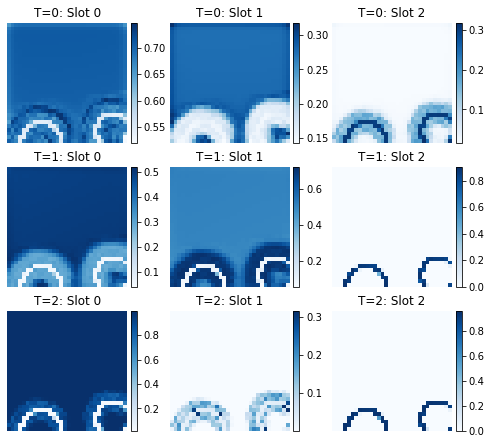

iter 9750 , loss 0.09228796 , lr 0.00026207186877500826


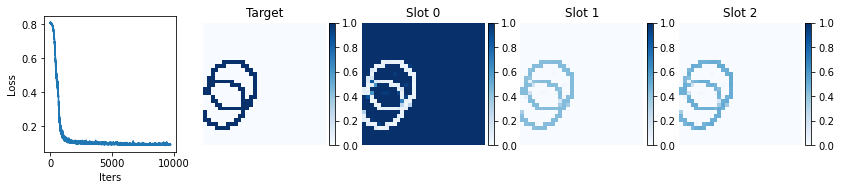

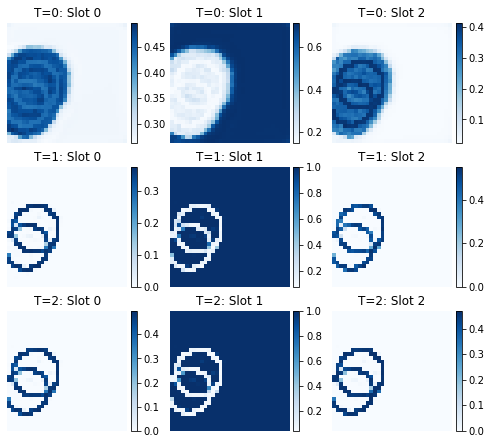

iter 10000 , loss 0.09382239 , lr 0.0002611651689888372


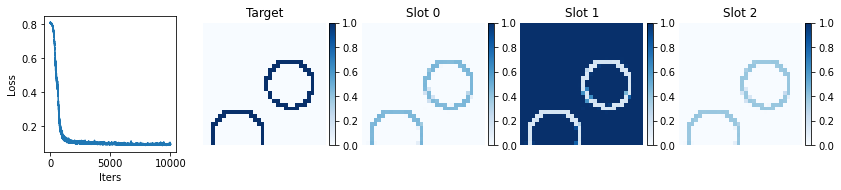

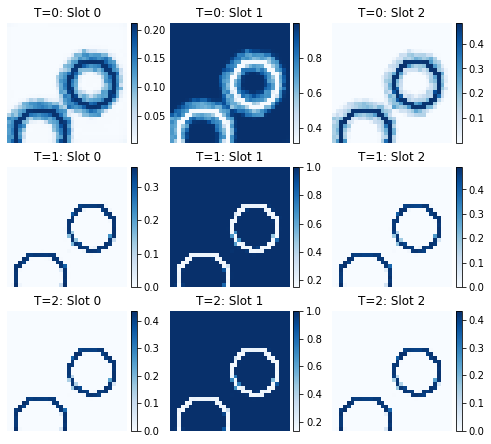

iter 10250 , loss 0.08762947 , lr 0.00026026160614562037


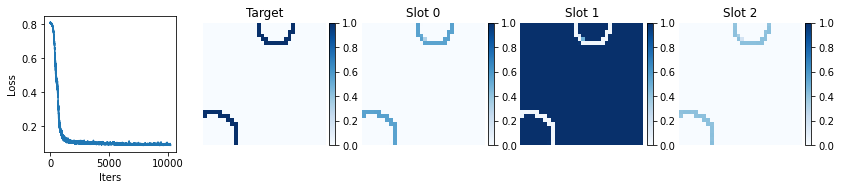

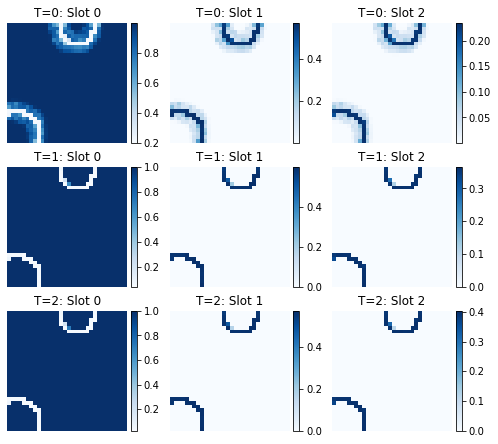

iter 10500 , loss 0.093900345 , lr 0.0002593611693923595


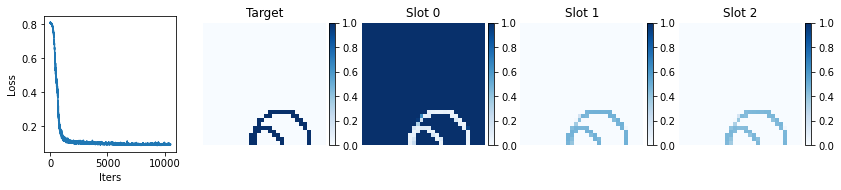

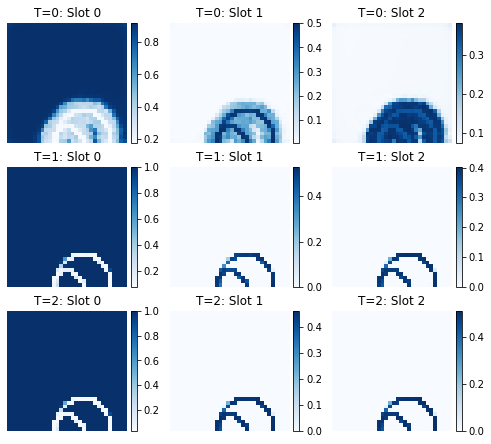

iter 10750 , loss 0.090569556 , lr 0.0002584638479136051


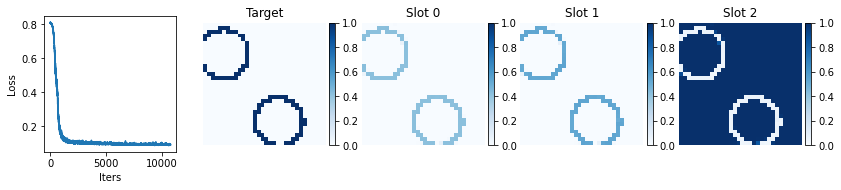

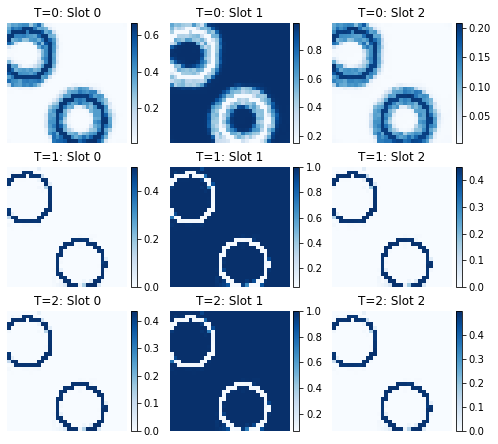

iter 11000 , loss 0.09268601 , lr 0.0002575696309313261


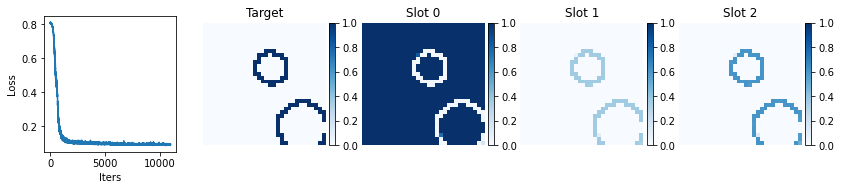

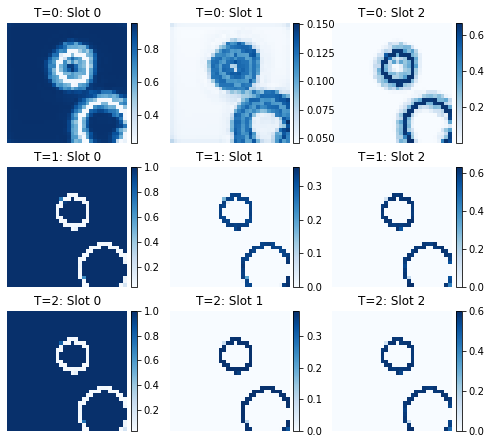

iter 11250 , loss 0.09106504 , lr 0.0002566785077047806


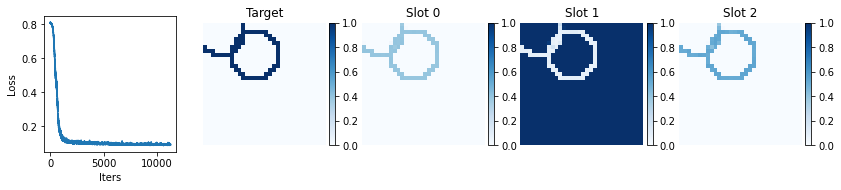

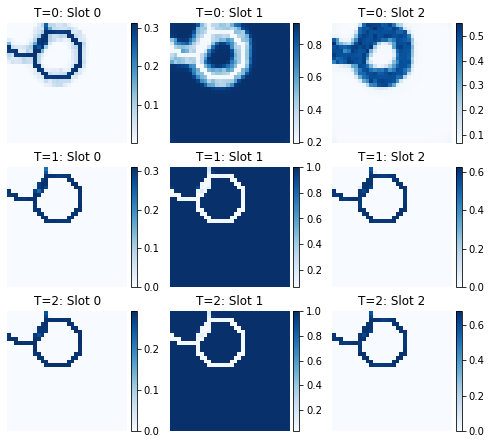

iter 11500 , loss 0.08675282 , lr 0.000255790467530387


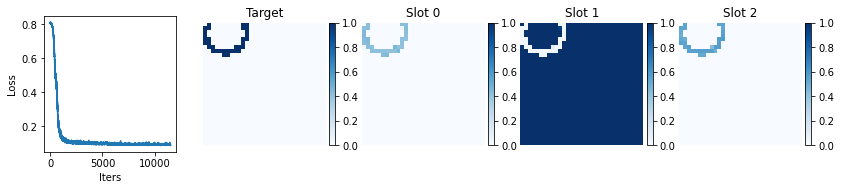

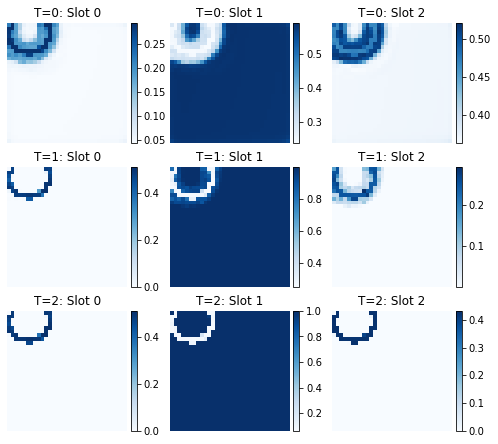

iter 11750 , loss 0.09153021 , lr 0.00025490549974159504


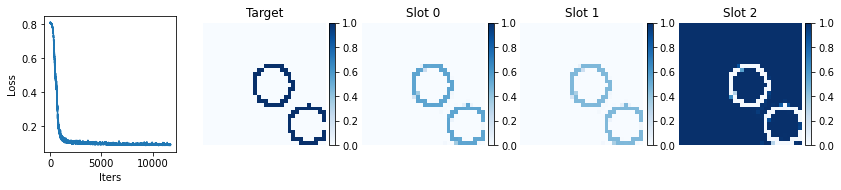

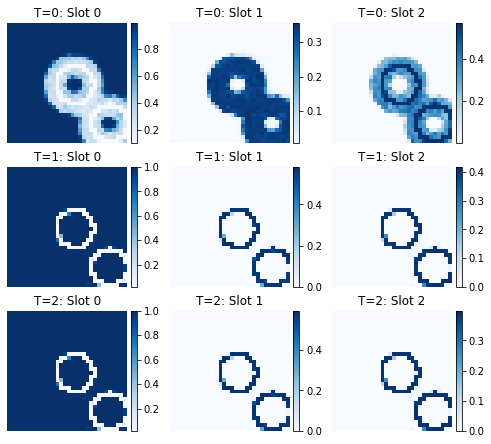

iter 12000 , loss 0.08798672 , lr 0.00025402359370875813


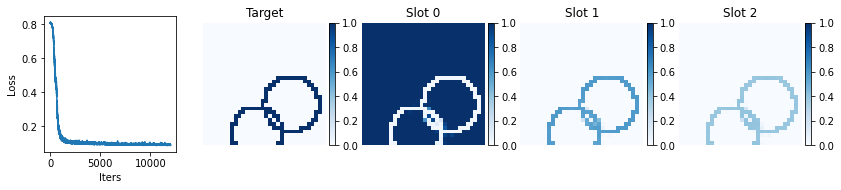

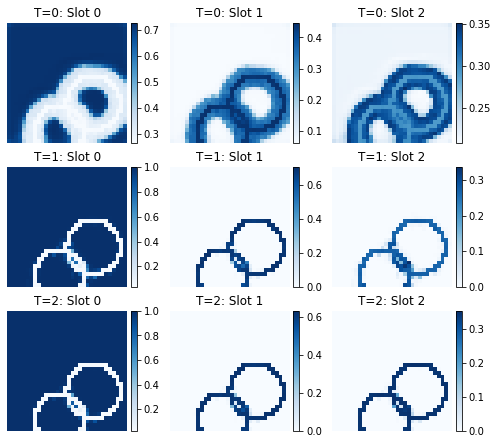

iter 12250 , loss 0.09297449 , lr 0.00025314473883900534


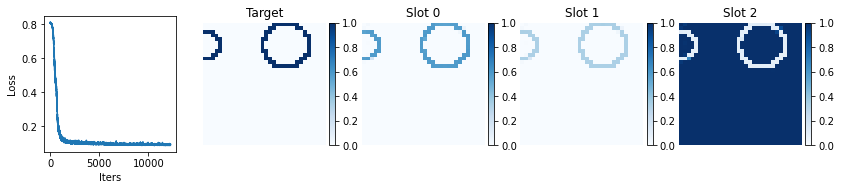

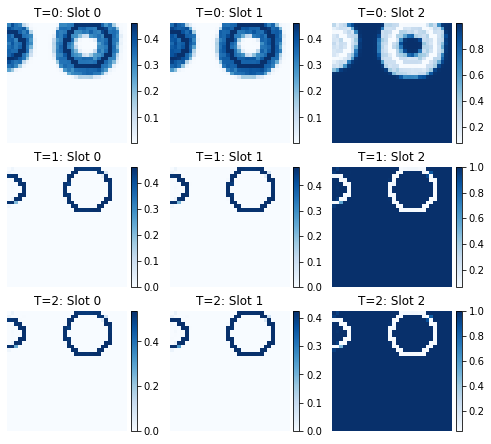

iter 12500 , loss 0.08788212 , lr 0.00025226892457611434


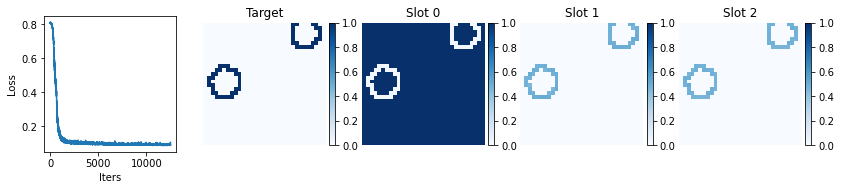

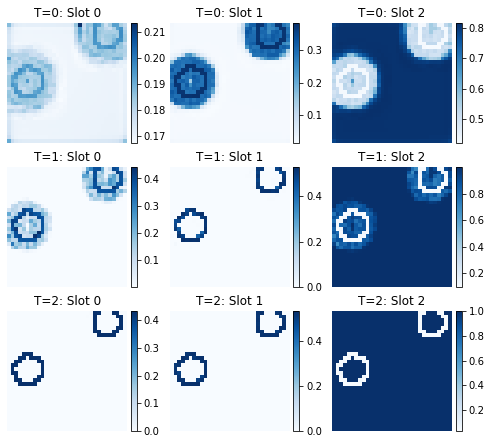

iter 12750 , loss 0.090042055 , lr 0.00025139614040038455


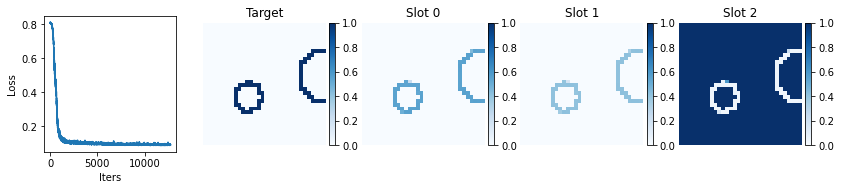

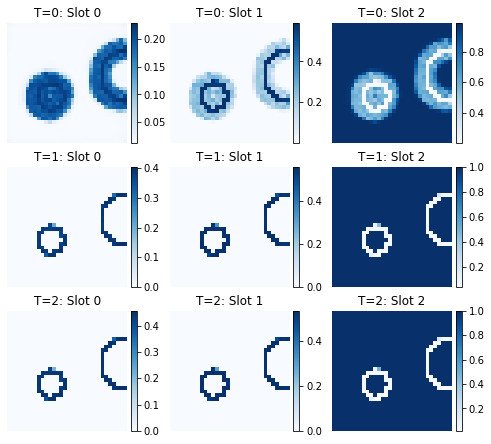

iter 13000 , loss 0.090282895 , lr 0.0002505263758285108


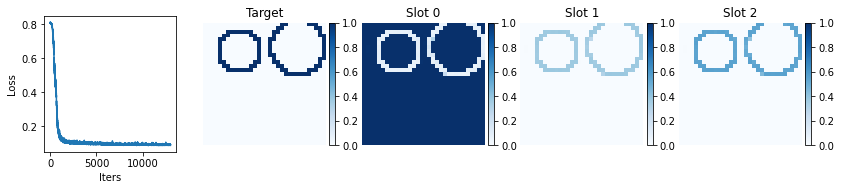

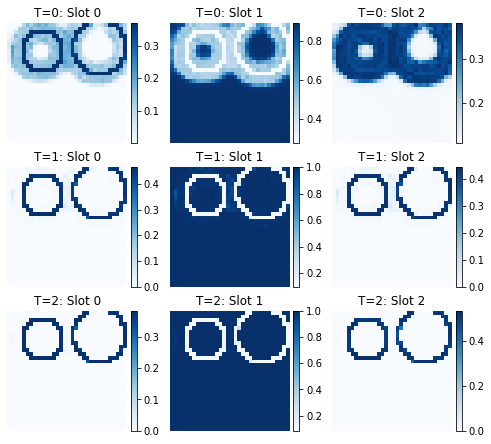

iter 13250 , loss 0.08996414 , lr 0.0002496596204134573


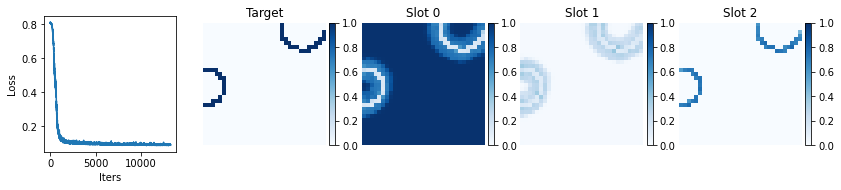

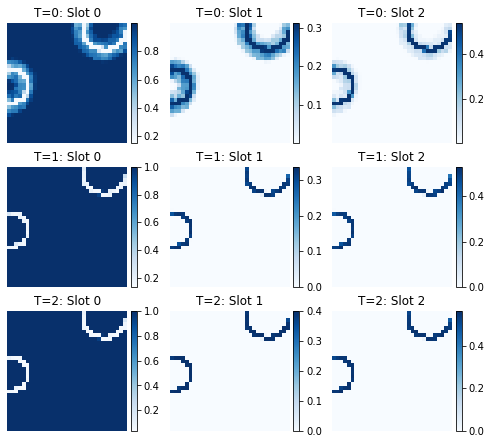

iter 13500 , loss 0.09425622 , lr 0.00024879586374433247


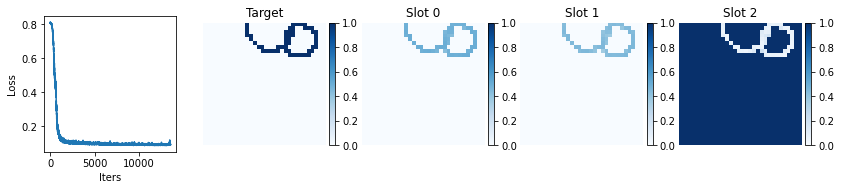

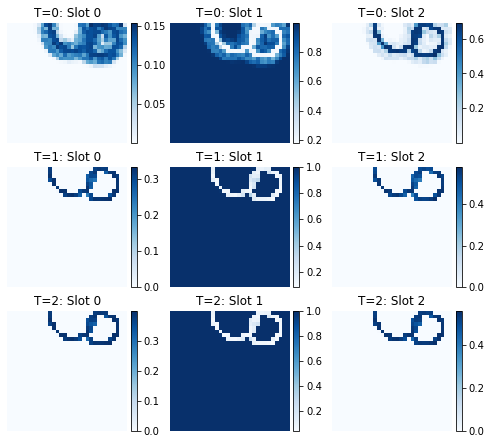

iter 13750 , loss 0.090015516 , lr 0.0002479350954462635


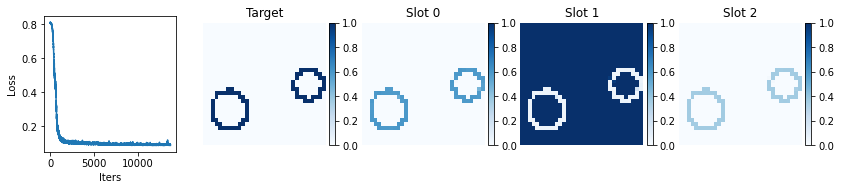

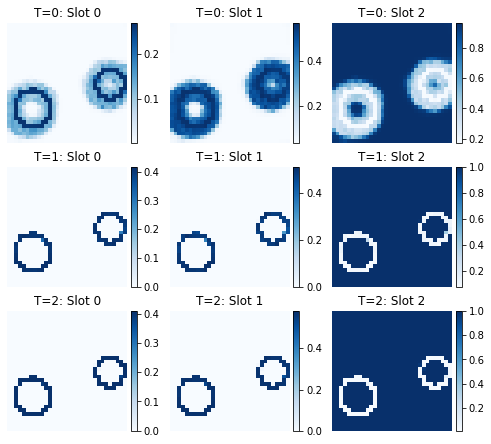

iter 14000 , loss 0.09150934 , lr 0.0002470773051802719


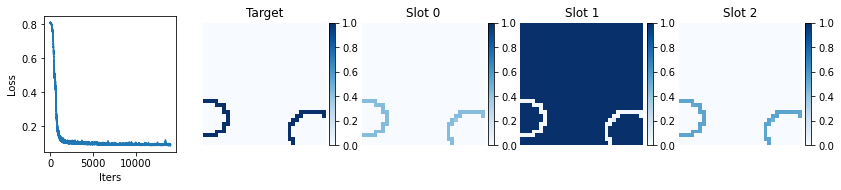

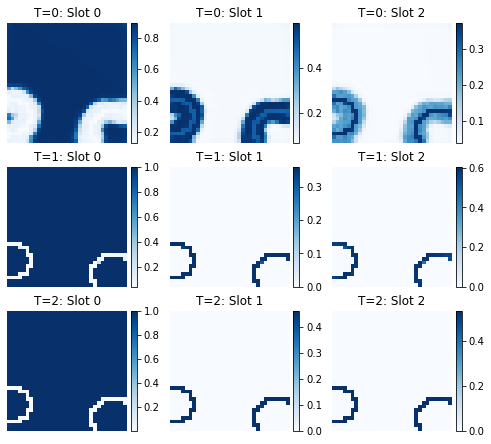

iter 14250 , loss 0.09157413 , lr 0.0002462224826431495


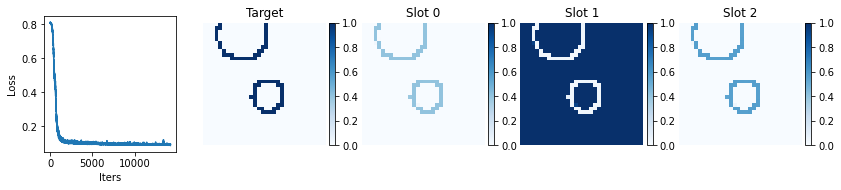

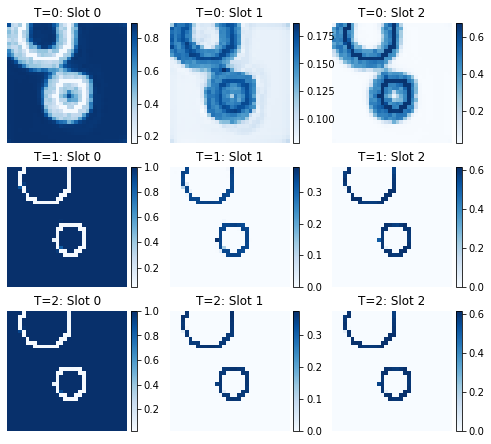

iter 14500 , loss 0.09360024 , lr 0.0002453706175673343


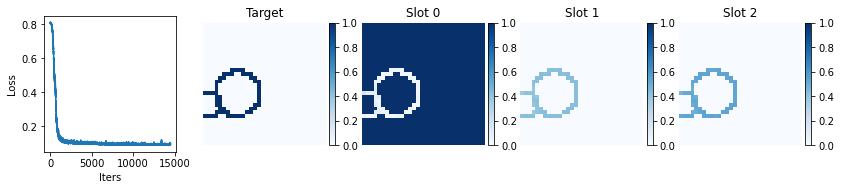

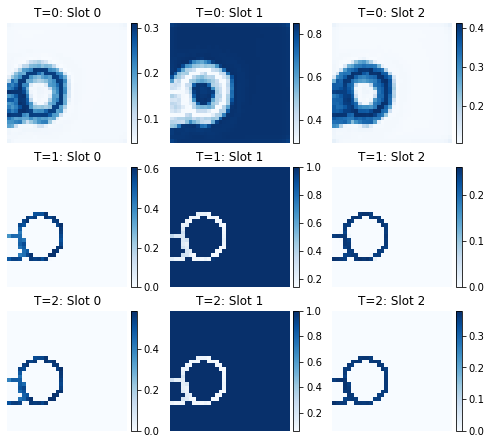

iter 14750 , loss 0.09731792 , lr 0.0002445216997207876


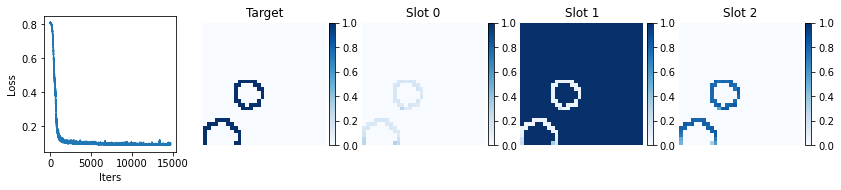

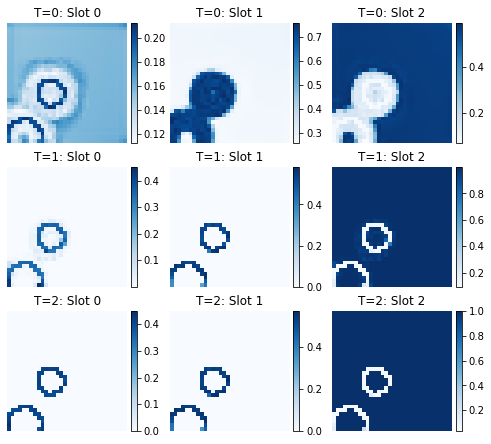

iter 15000 , loss 0.09010115 , lr 0.00024367571890687067


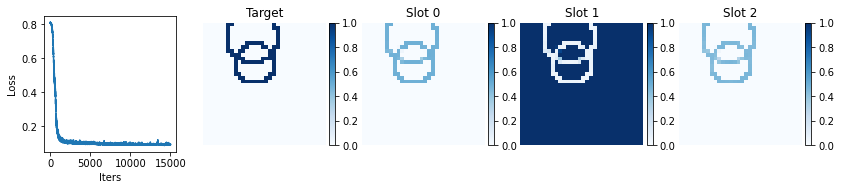

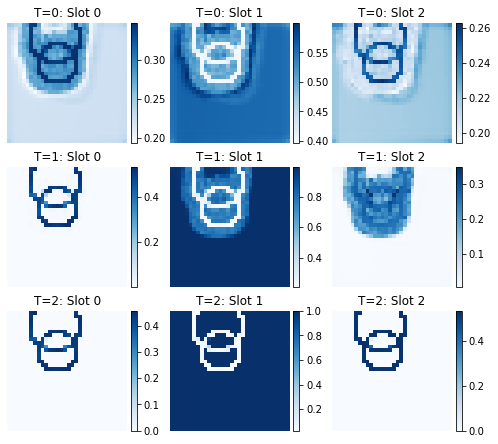

iter 15250 , loss 0.0903448 , lr 0.0002428326649642225


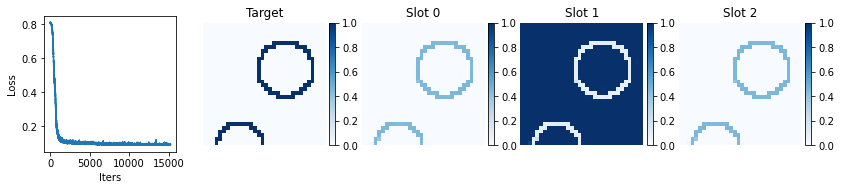

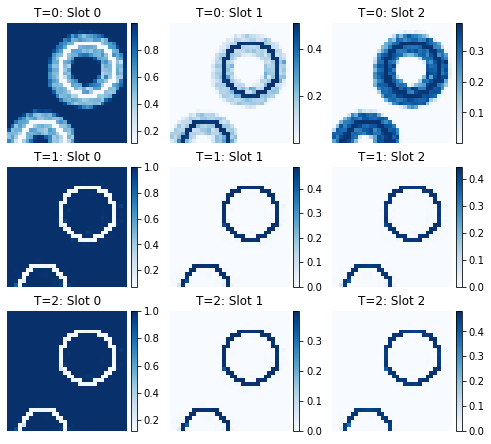

iter 15500 , loss 0.09326117 , lr 0.00024199252776663788


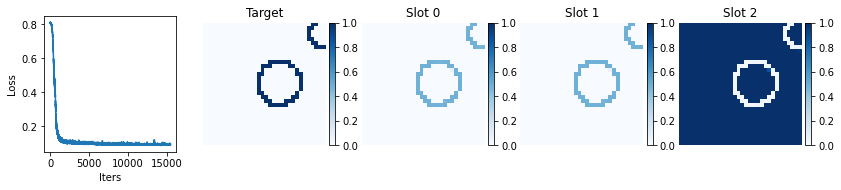

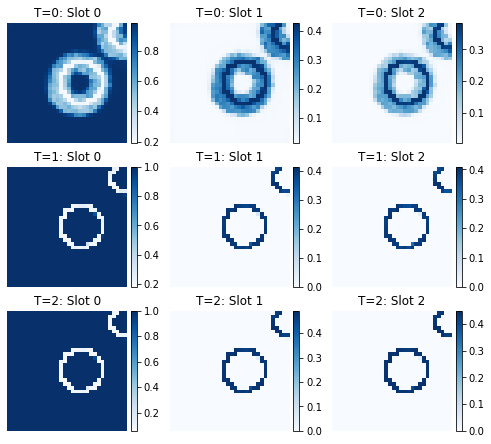

iter 15750 , loss 0.08984202 , lr 0.00024115529722294542


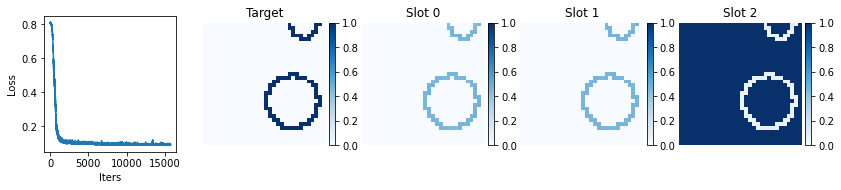

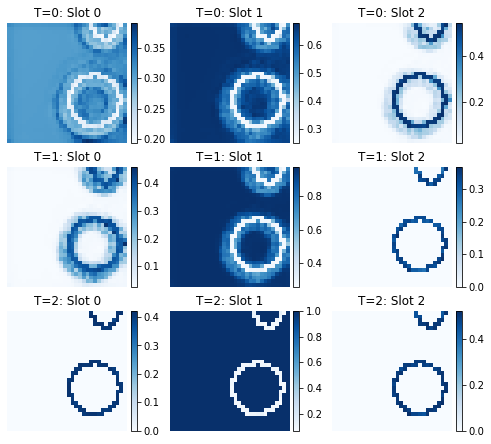

iter 16000 , loss 0.10017628 , lr 0.00024032096327688662


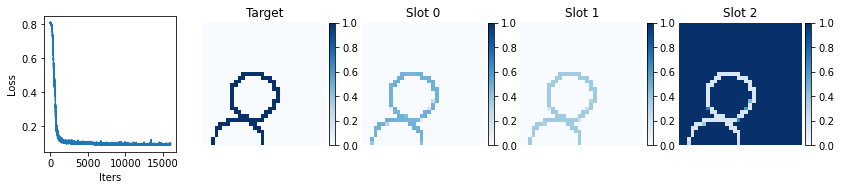

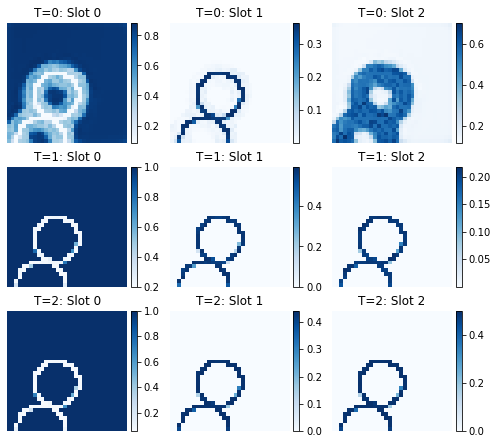

iter 16250 , loss 0.089707986 , lr 0.00023948951590699492


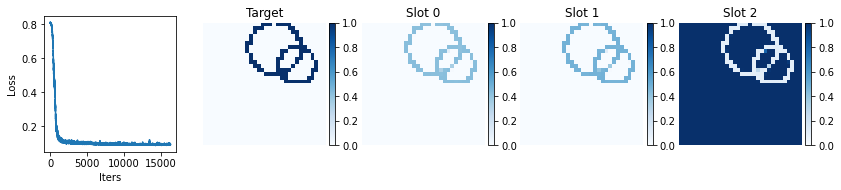

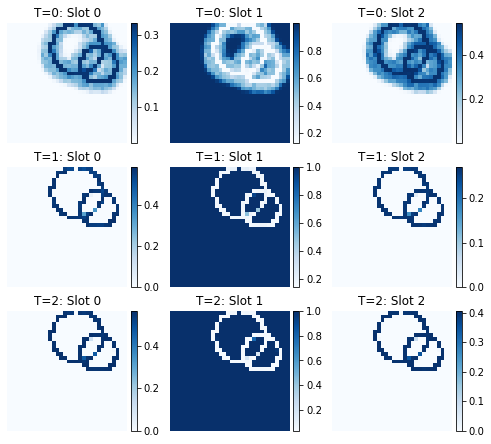

iter 16500 , loss 0.089293644 , lr 0.00023866094512647559


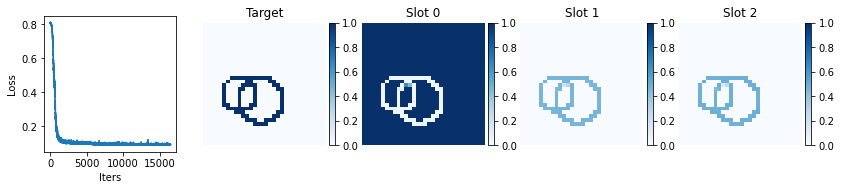

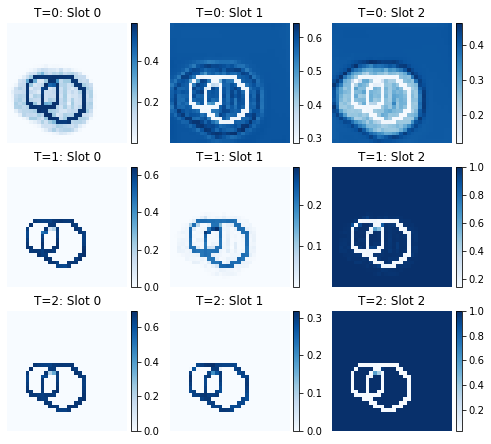

iter 16750 , loss 0.089628756 , lr 0.0002378352409830853


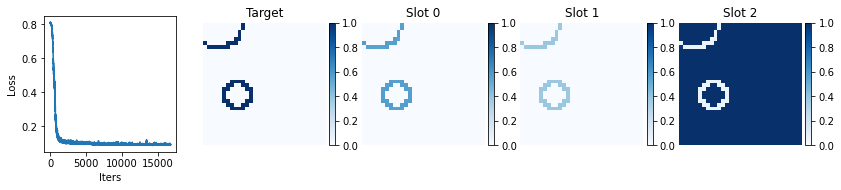

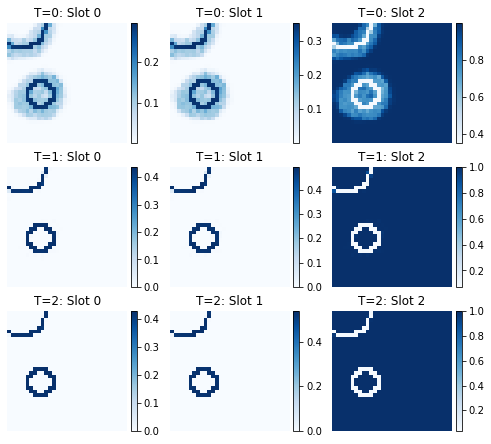

iter 17000 , loss 0.0904945 , lr 0.0002370123935590131


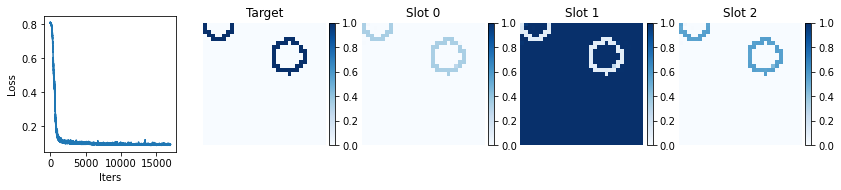

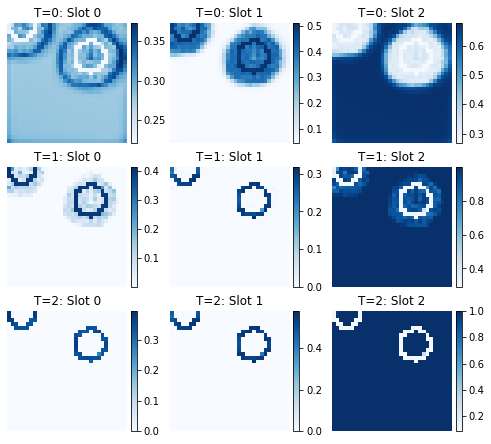

iter 17250 , loss 0.09011389 , lr 0.000236192392970761


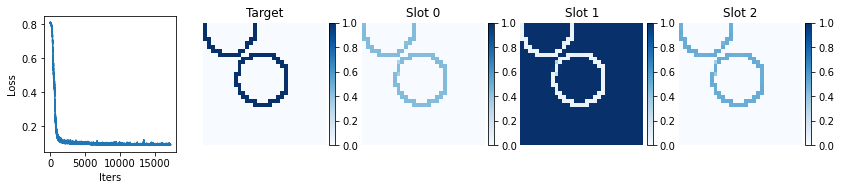

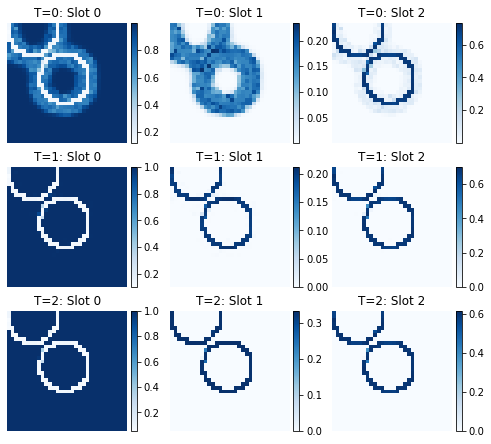

iter 17500 , loss 0.09030758 , lr 0.0002353752293690252


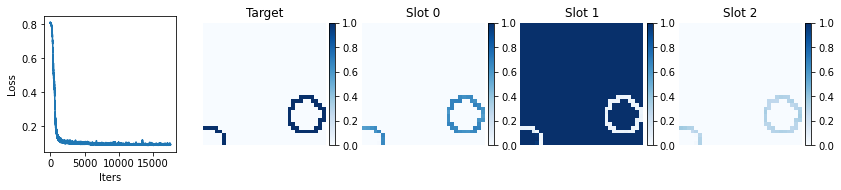

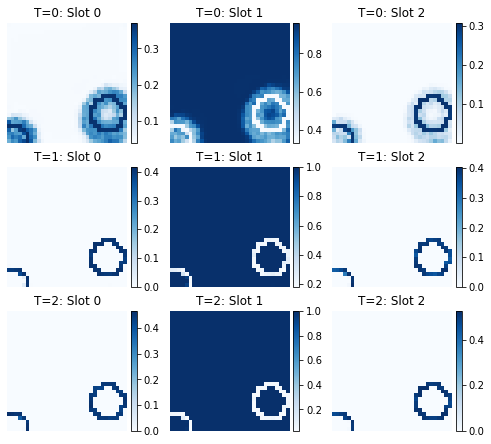

iter 17750 , loss 0.09885631 , lr 0.00023456089293857804


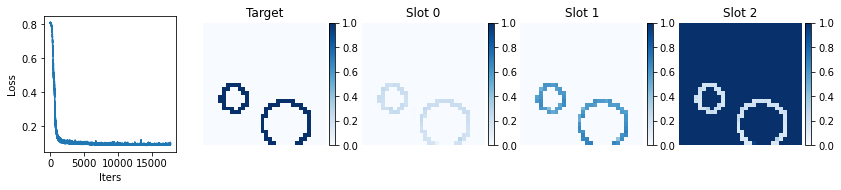

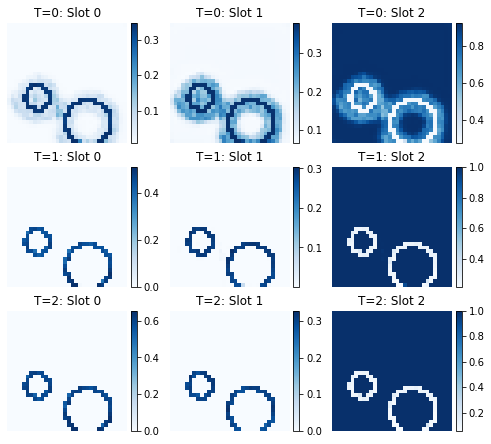

iter 18000 , loss 0.09546833 , lr 0.00023374937389814994


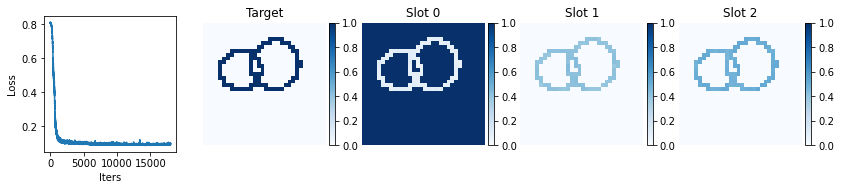

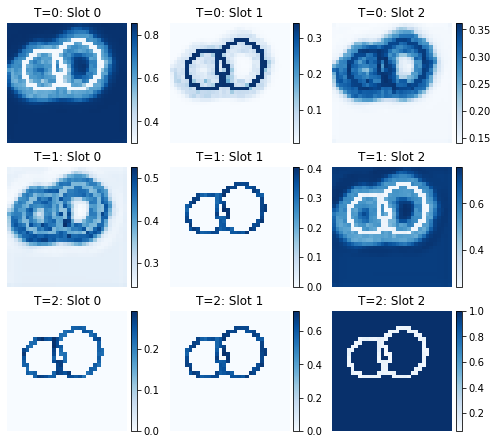

iter 18250 , loss 0.08591464 , lr 0.00023294066250031188


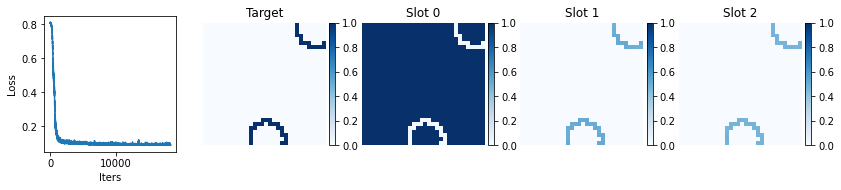

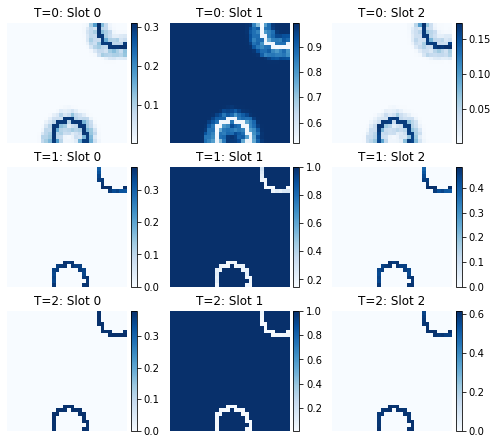

iter 18500 , loss 0.08912324 , lr 0.00023213474903135845


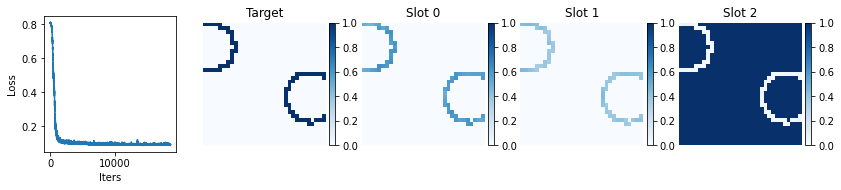

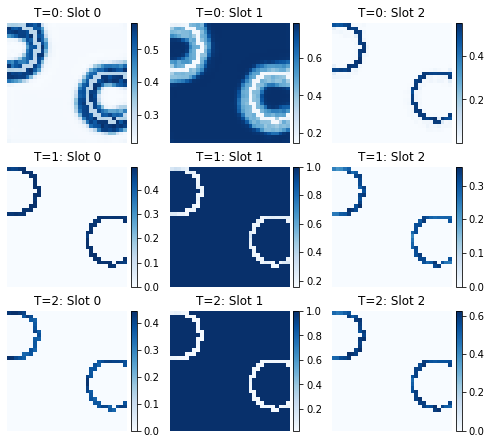

iter 18750 , loss 0.08742319 , lr 0.00023133162381119108


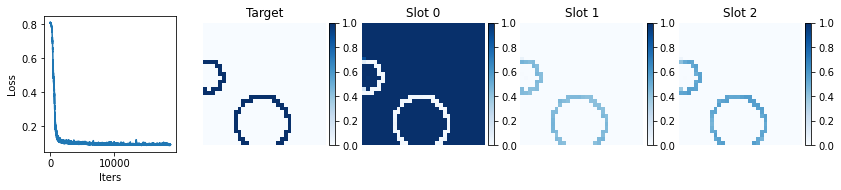

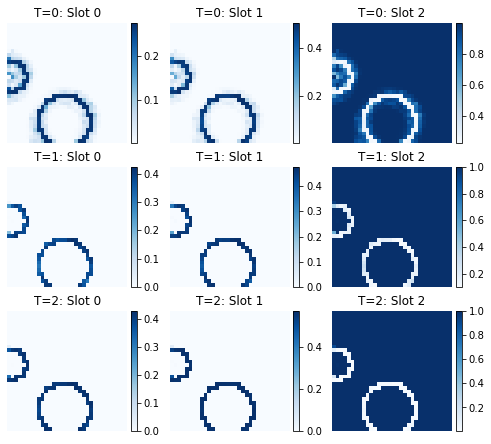

iter 19000 , loss 0.0933303 , lr 0.00023053127719320184


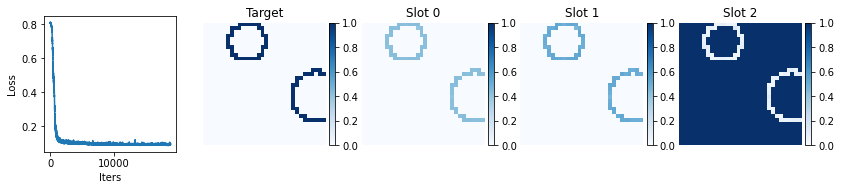

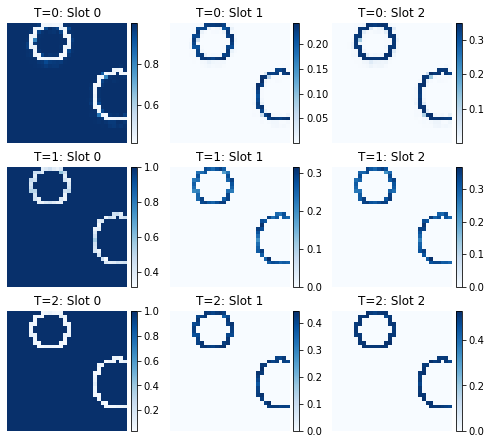

iter 19250 , loss 0.08781678 , lr 0.00022973369956415742


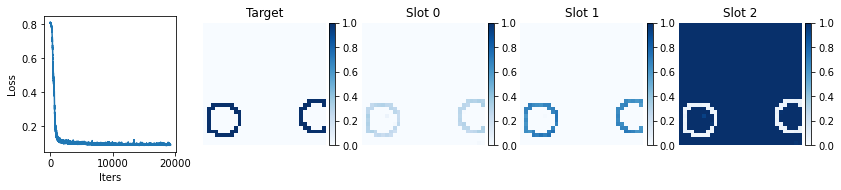

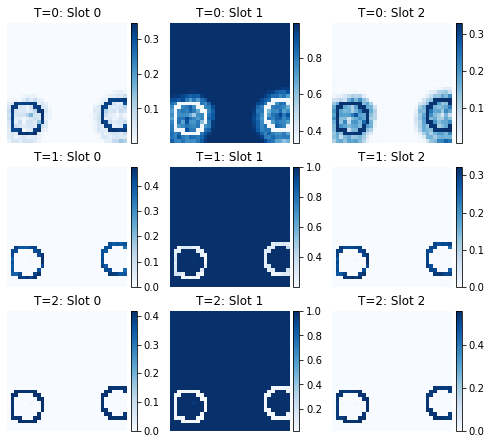

iter 19500 , loss 0.09219503 , lr 0.00022893888134408385


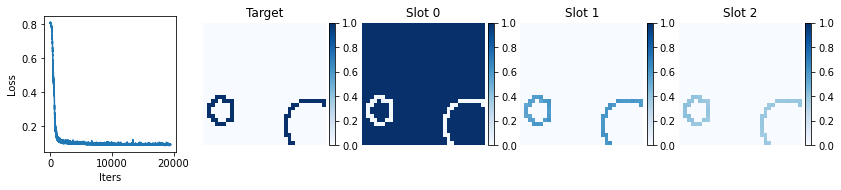

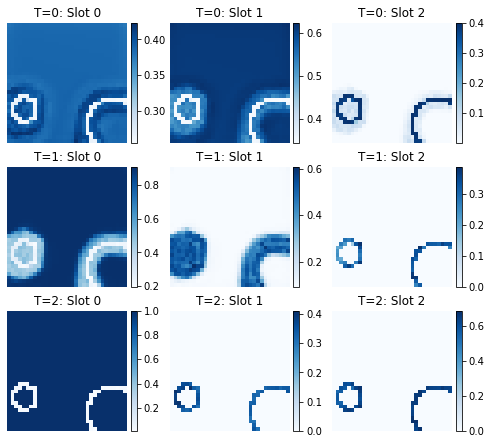

iter 19750 , loss 0.088627316 , lr 0.00022814681298615136


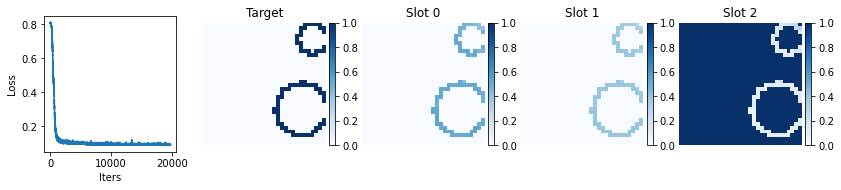

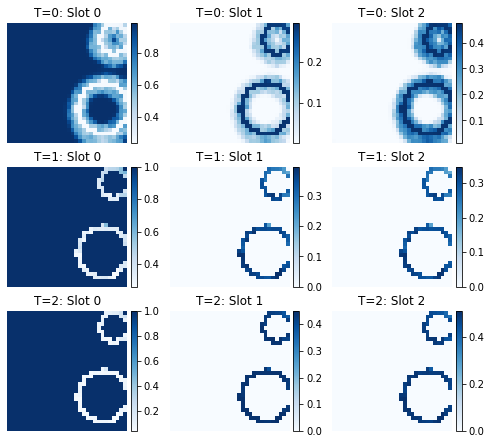

iter 20000 , loss 0.08926073 , lr 0.00022735748497655967


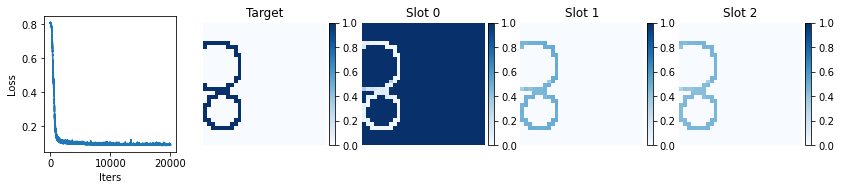

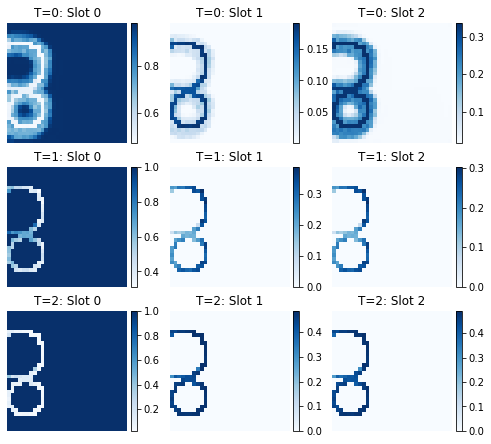

iter 20250 , loss 0.08893984 , lr 0.0002265708878344238


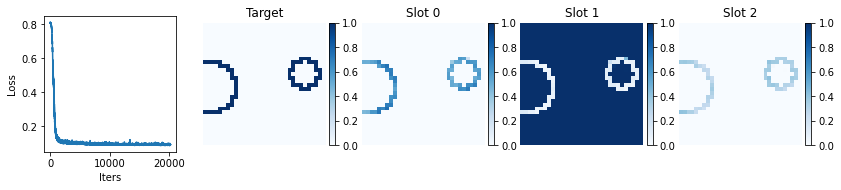

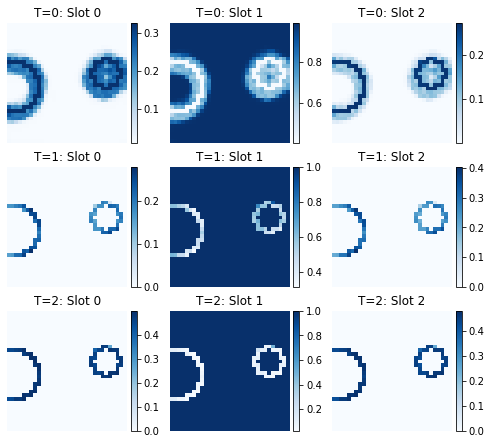

iter 20500 , loss 0.08677094 , lr 0.0002257870121116601


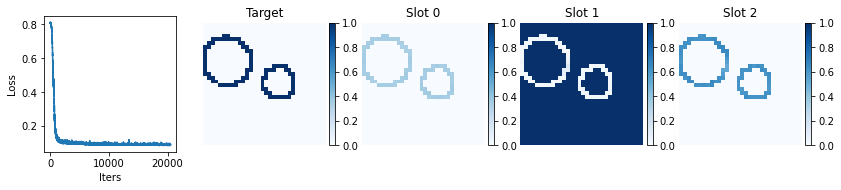

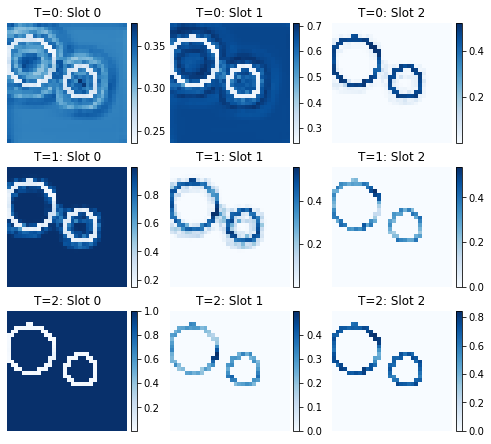

iter 20750 , loss 0.09051363 , lr 0.0002250058483928727


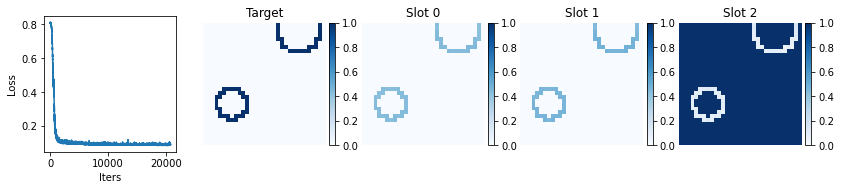

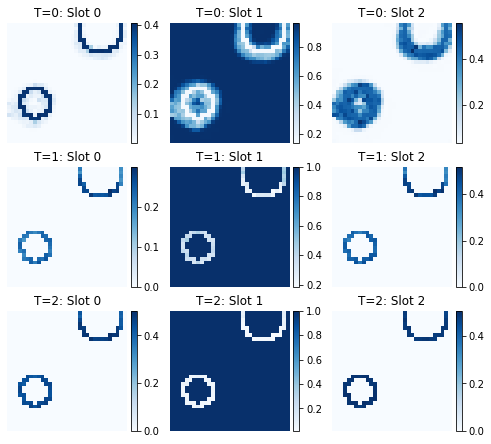

iter 21000 , loss 0.08957731 , lr 0.00022422738729524077


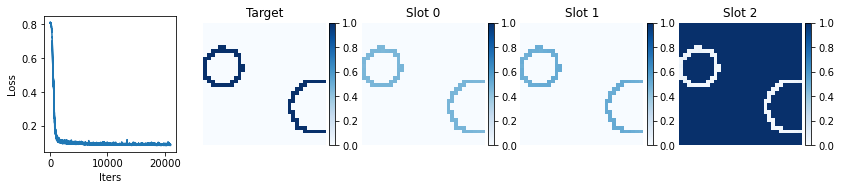

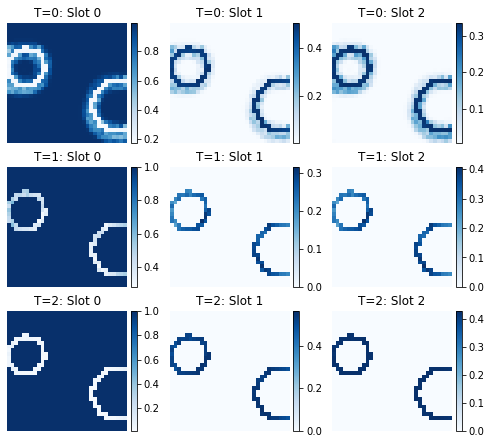

iter 21250 , loss 0.087254755 , lr 0.00022345161946840534


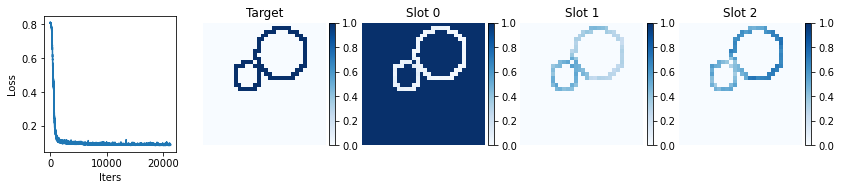

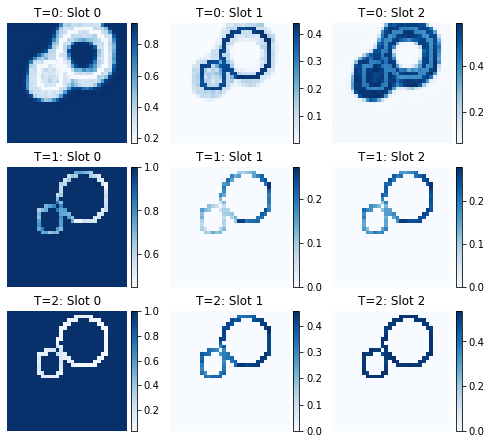

iter 21500 , loss 0.0916266 , lr 0.00022267853559435736


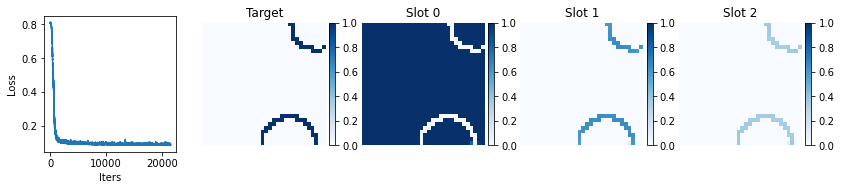

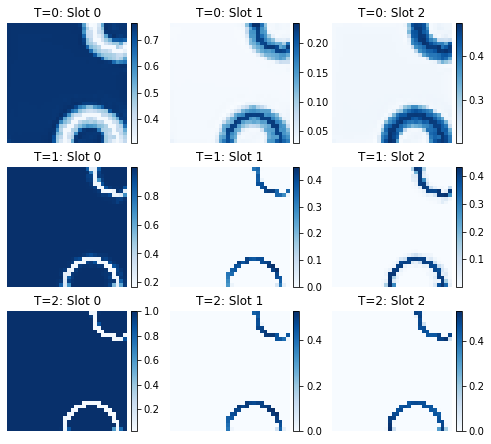

iter 21750 , loss 0.087547734 , lr 0.0002219081263873256


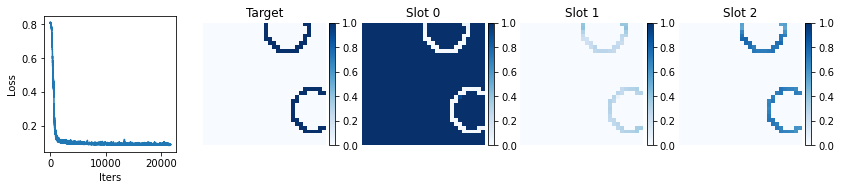

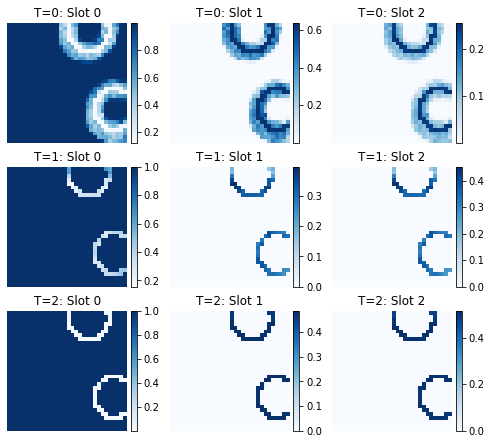

iter 22000 , loss 0.08947982 , lr 0.00022114038259366515


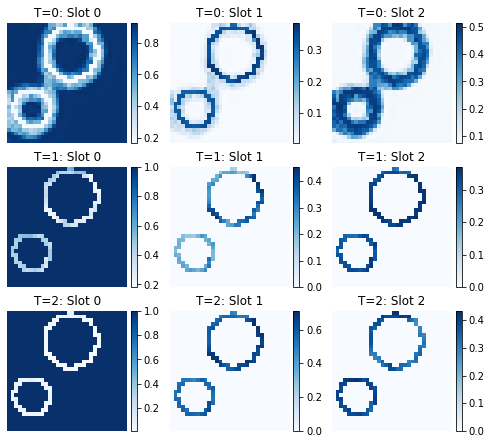

iter 22250 , loss 0.08365584 , lr 0.0002203752949917463


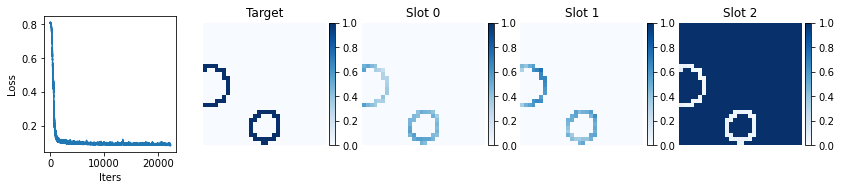

iter 22500 , loss 0.08629398 , lr 0.00021961285439184378


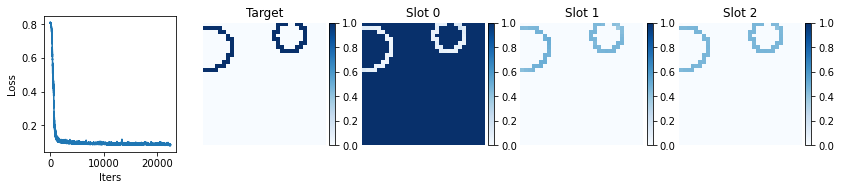

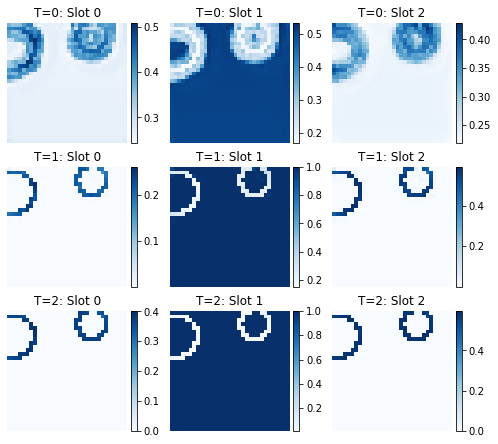

iter 22750 , loss 0.08518021 , lr 0.00021885305163602627


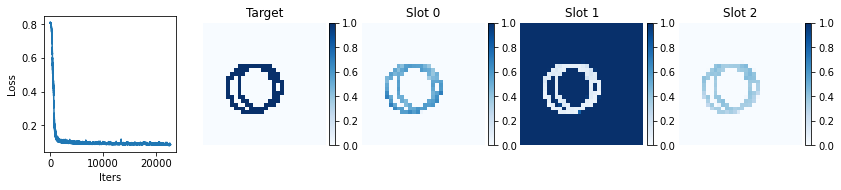

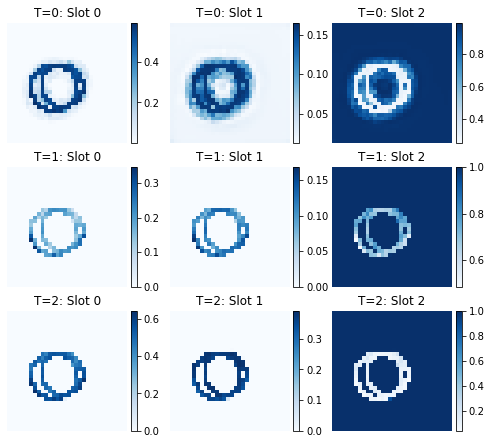

iter 23000 , loss 0.08378632 , lr 0.00021809587759804658


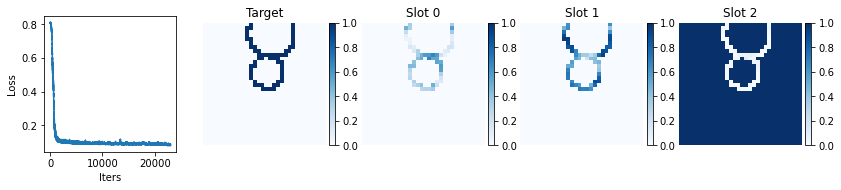

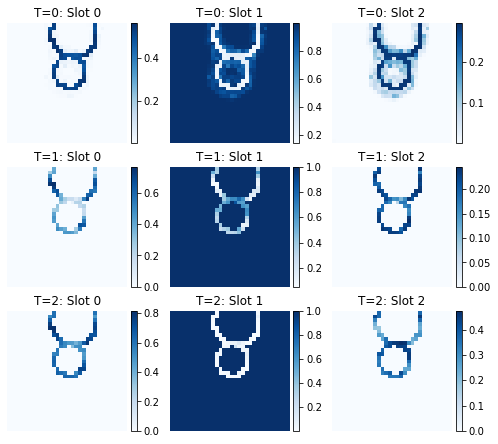

iter 23250 , loss 0.08310564 , lr 0.0002173413231832318


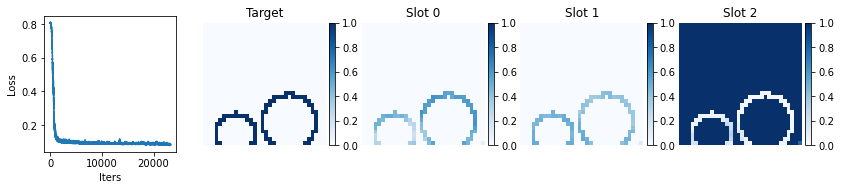

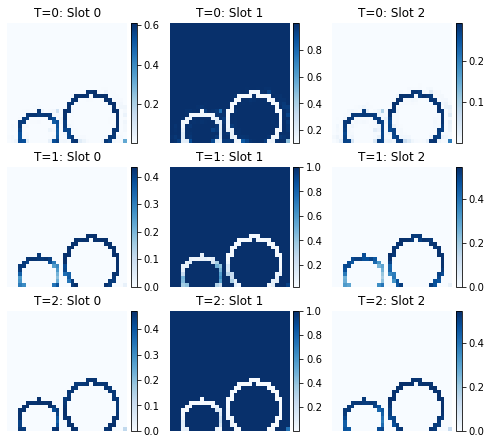

iter 23500 , loss 0.087000415 , lr 0.00021658937932837443


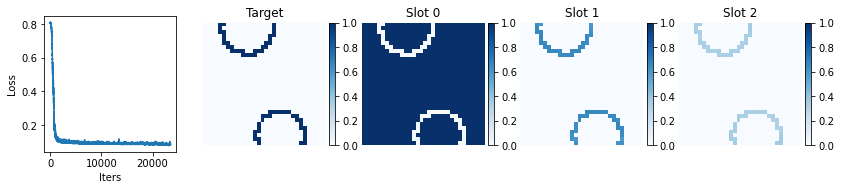

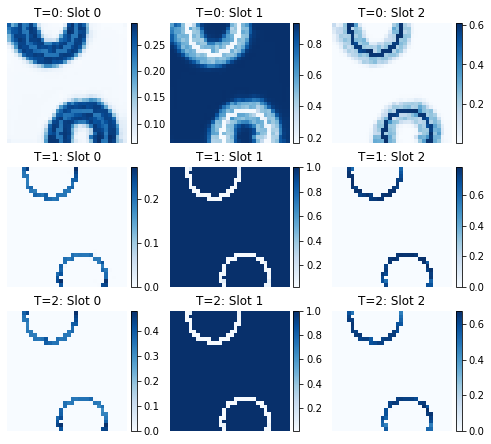

iter 23750 , loss 0.08369544 , lr 0.00021584003700162298


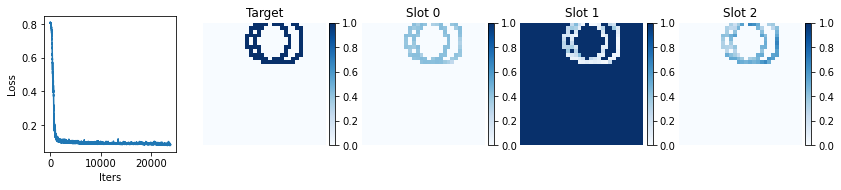

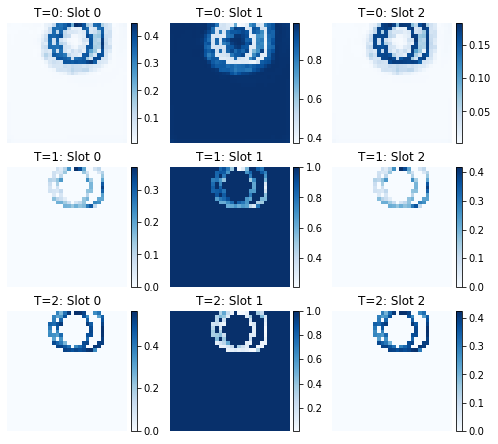

iter 24000 , loss 0.084889375 , lr 0.00021509328720237407


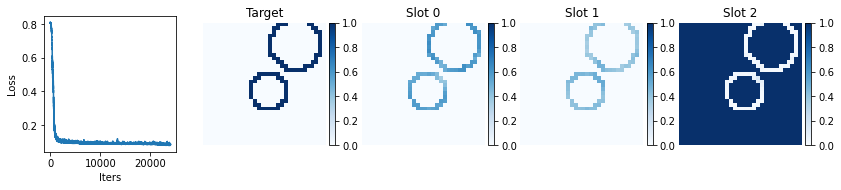

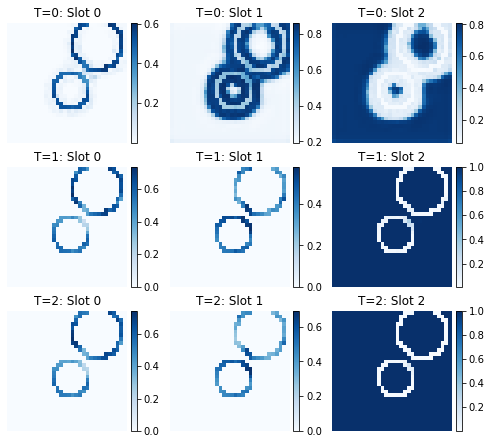

iter 24250 , loss 0.082274355 , lr 0.00021434912096116393


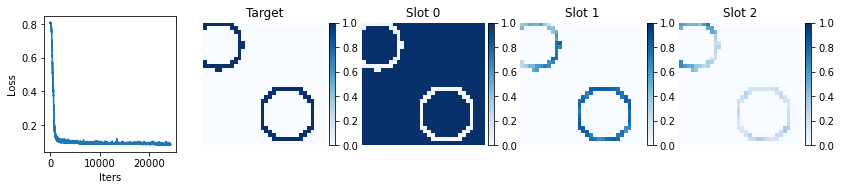

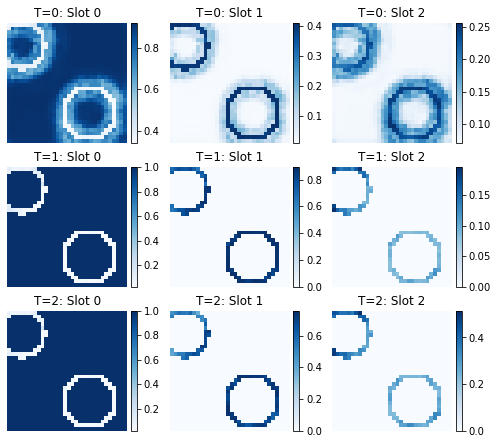

iter 24500 , loss 0.0830849 , lr 0.00021360752933956073


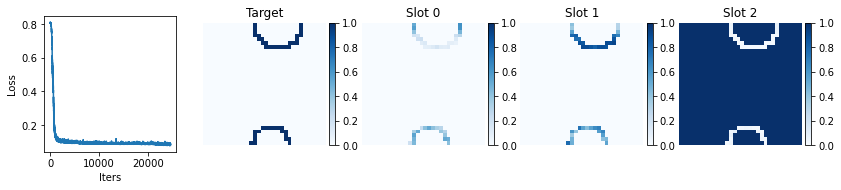

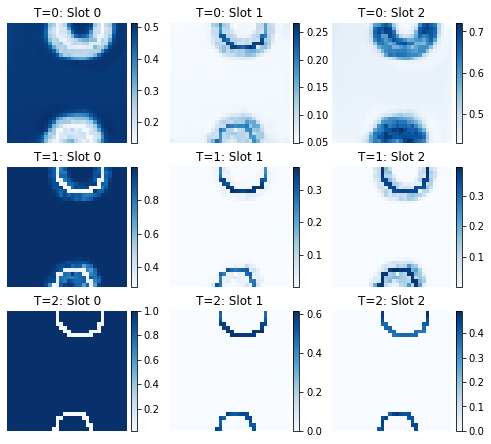

iter 24750 , loss 0.08531347 , lr 0.00021286850343005733


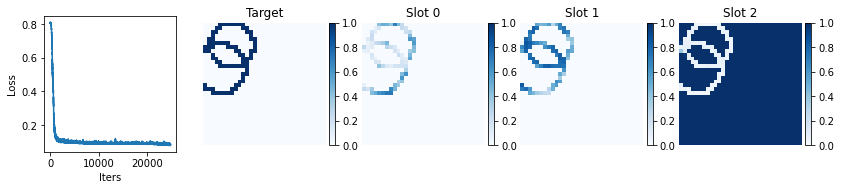

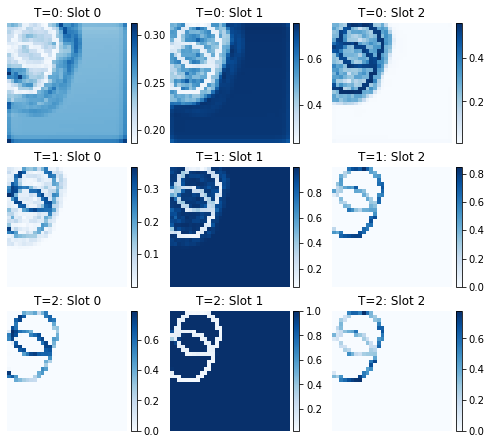

iter 25000 , loss 0.077930376 , lr 0.00021213203435596425


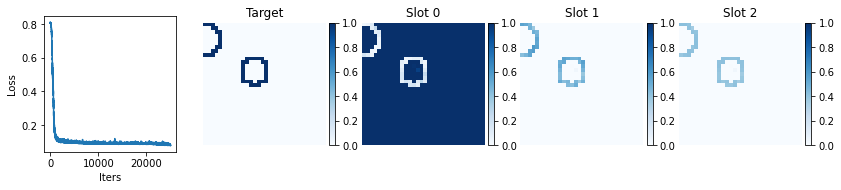

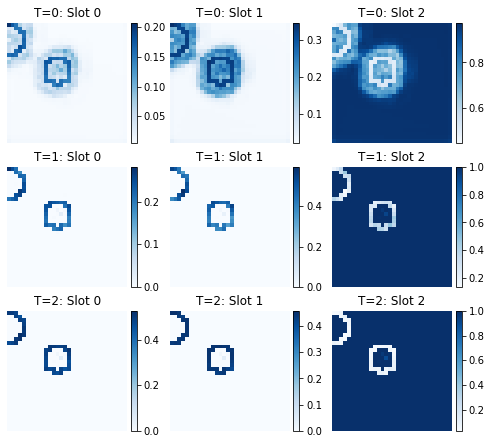

iter 25250 , loss 0.08603041 , lr 0.0002113981132713029


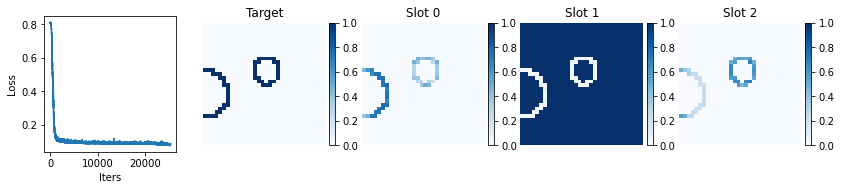

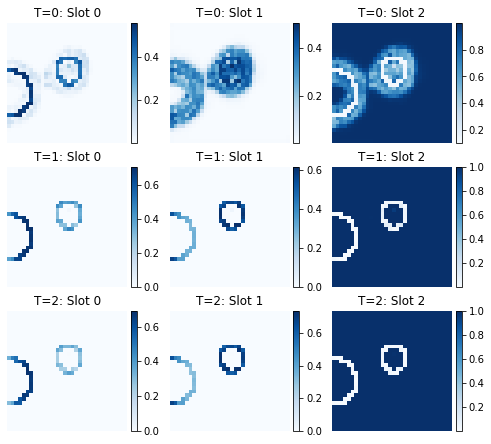

iter 25500 , loss 0.07619662 , lr 0.00021066673136069957


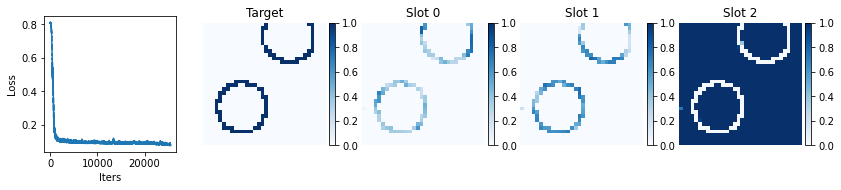

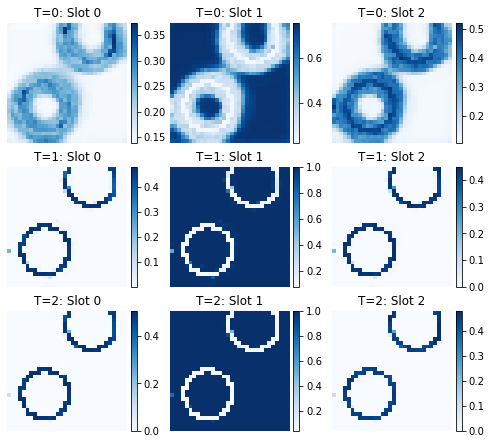

iter 25750 , loss 0.0893379 , lr 0.00020993787983927936


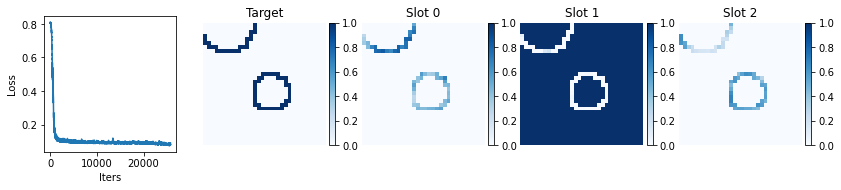

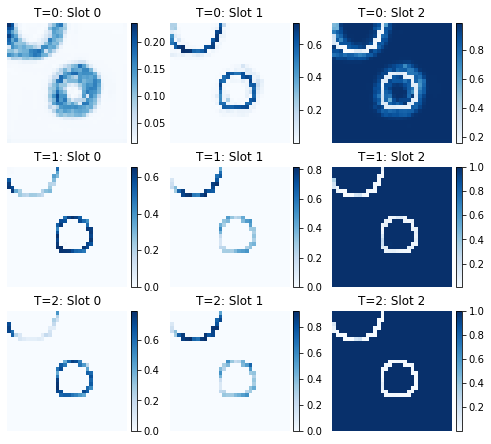

iter 26000 , loss 0.07724044 , lr 0.00020921154995256079


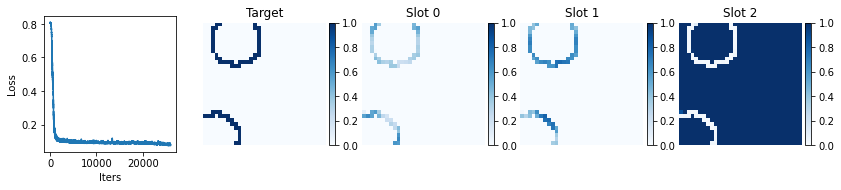

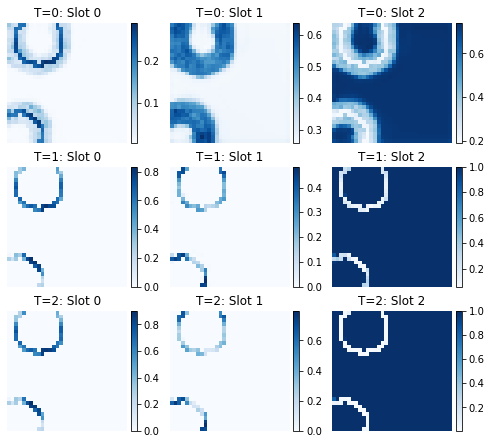

iter 26250 , loss 0.0770306 , lr 0.00020848773297635052


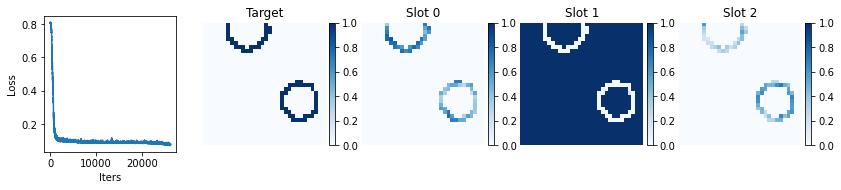

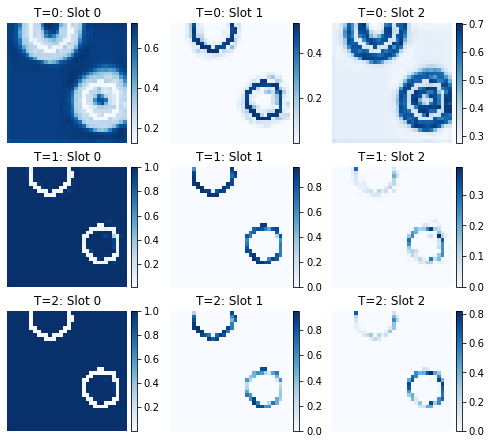

iter 26500 , loss 0.07711062 , lr 0.00020776642021663868


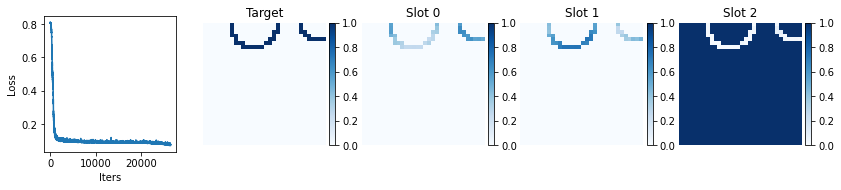

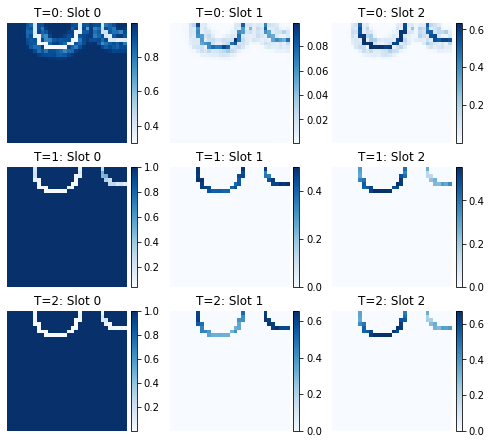

iter 26750 , loss 0.08310147 , lr 0.00020704760300949433


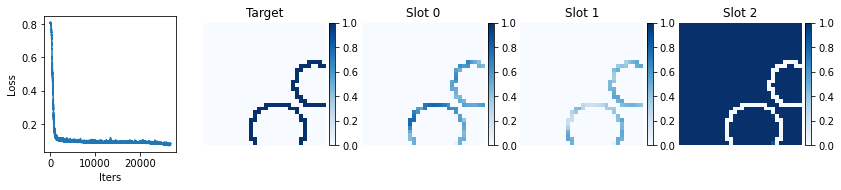

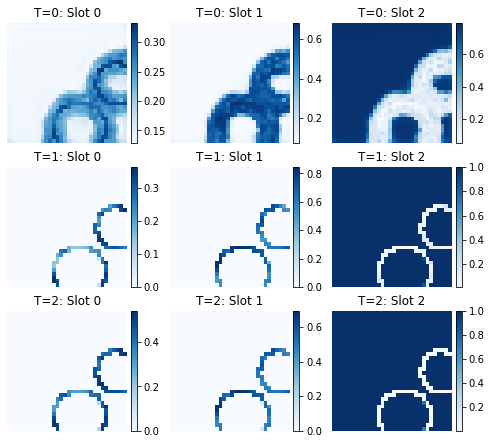

iter 27000 , loss 0.08037864 , lr 0.00020633127272096154


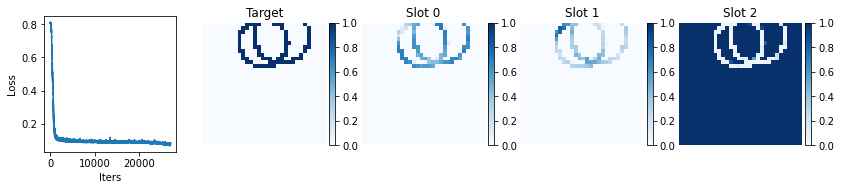

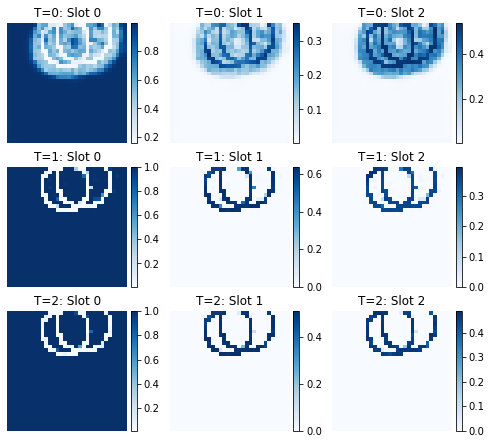

iter 27250 , loss 0.07649744 , lr 0.00020561742074695549


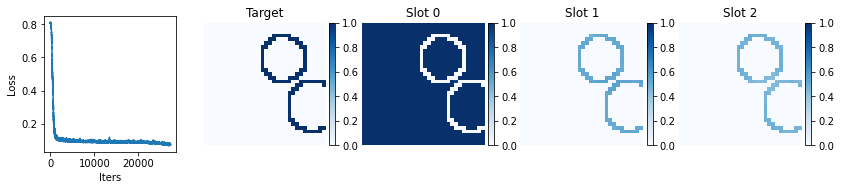

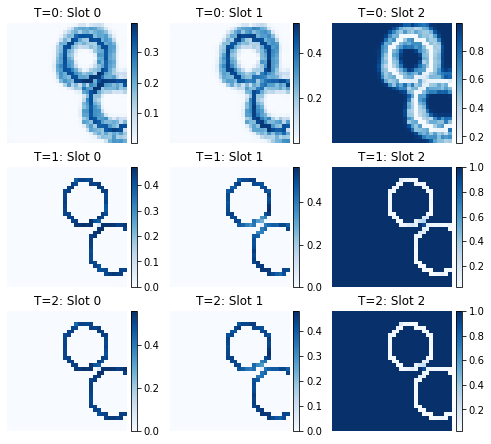

iter 27500 , loss 0.07545285 , lr 0.0002049060385131593


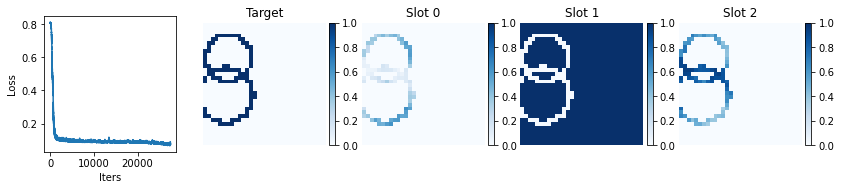

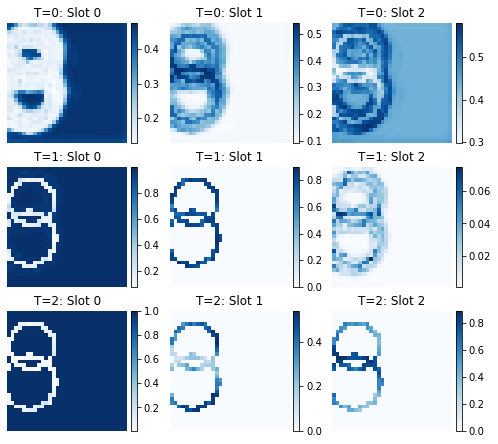

iter 27750 , loss 0.0746439 , lr 0.00020419711747492097


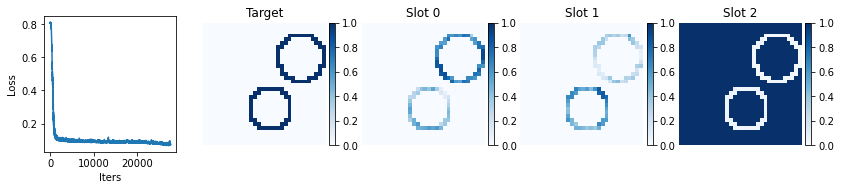

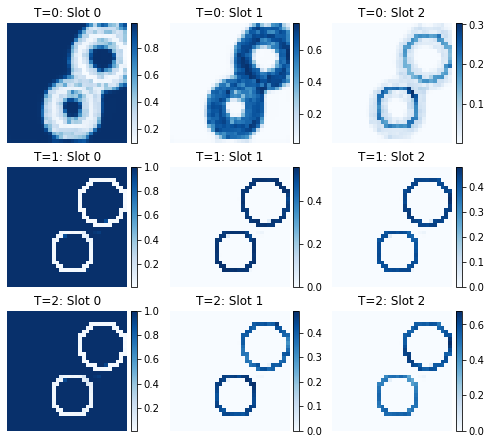

iter 28000 , loss 0.076564535 , lr 0.00020349064911715076


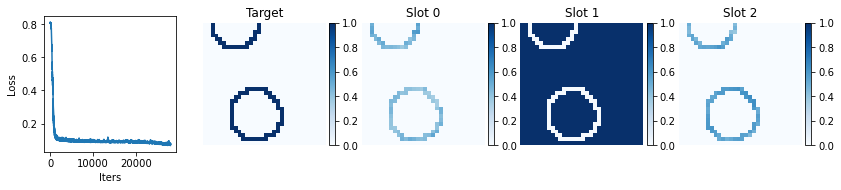

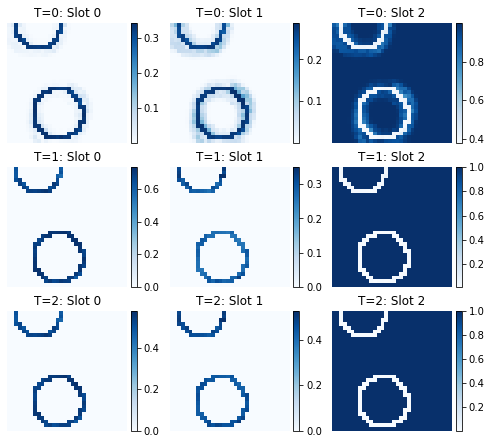

iter 28250 , loss 0.074366756 , lr 0.00020278662495421885


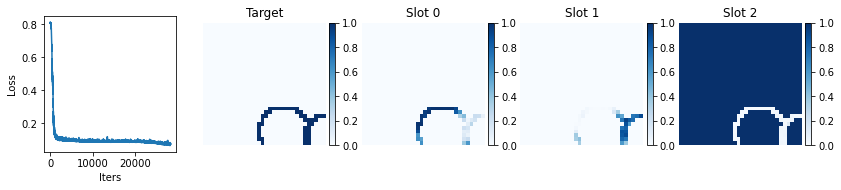

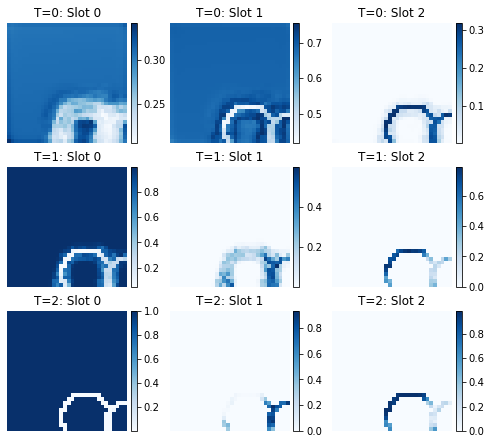

iter 28500 , loss 0.070007876 , lr 0.0002020850365298535


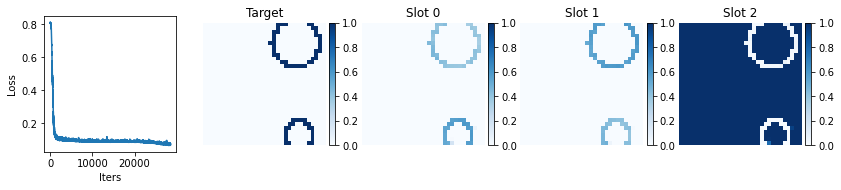

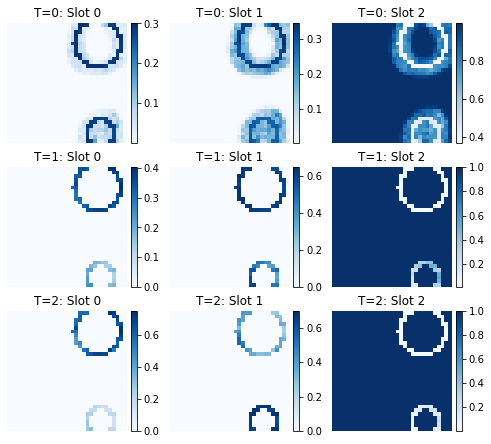

iter 28750 , loss 0.07369052 , lr 0.0002013858754170395


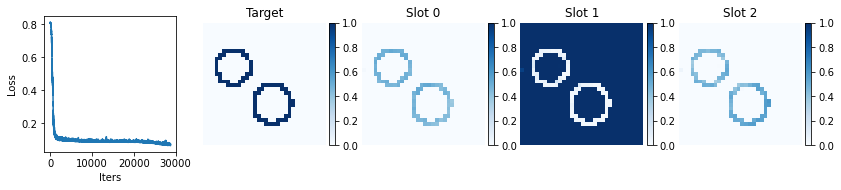

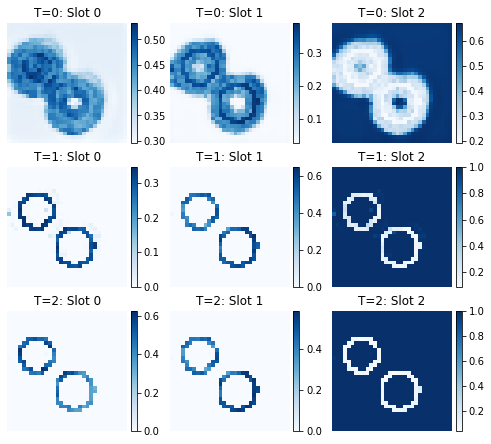

iter 29000 , loss 0.065484084 , lr 0.00020068913321791678


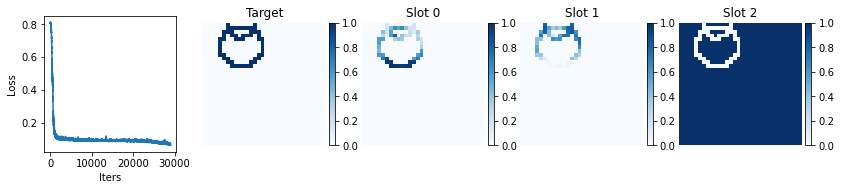

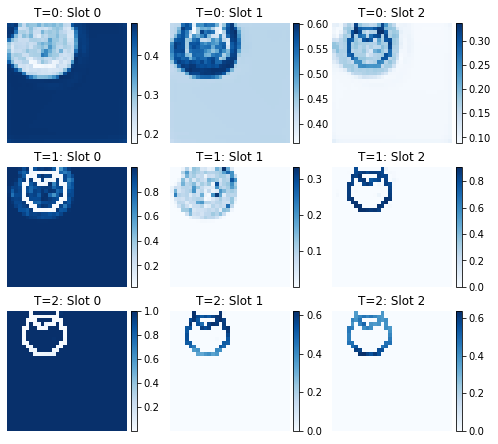

iter 29250 , loss 0.07084005 , lr 0.0001999948015636798


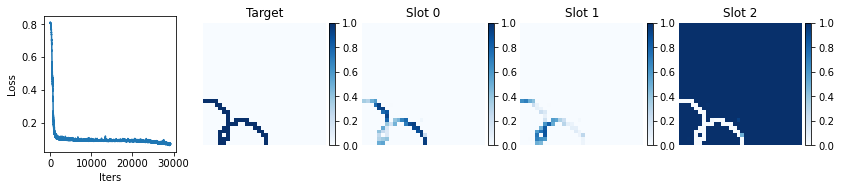

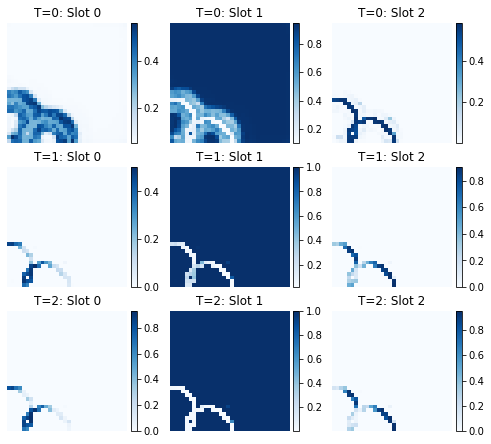

iter 29500 , loss 0.069466725 , lr 0.00019930287211447674


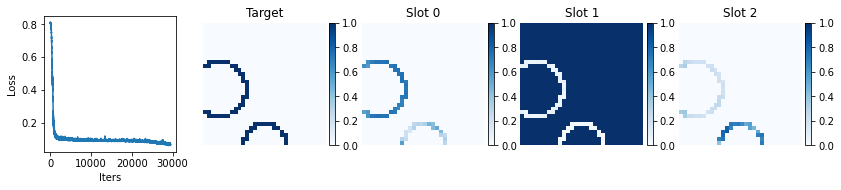

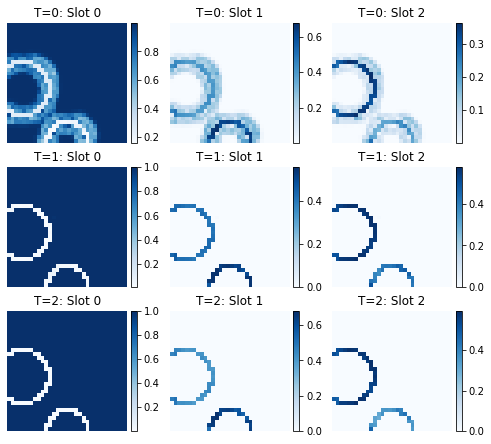

iter 29750 , loss 0.07131608 , lr 0.00019861333655930957


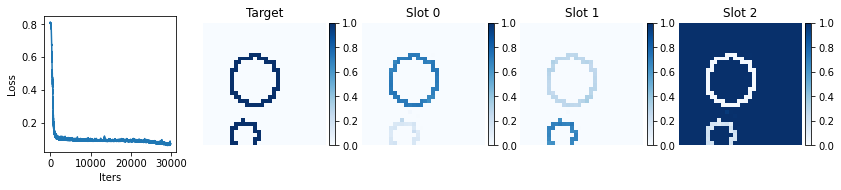

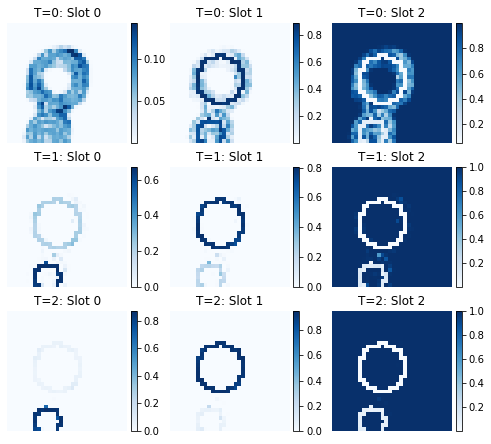

iter 30000 , loss 0.06914514 , lr 0.00019792618661593412


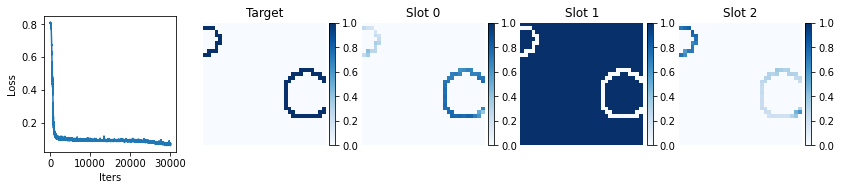

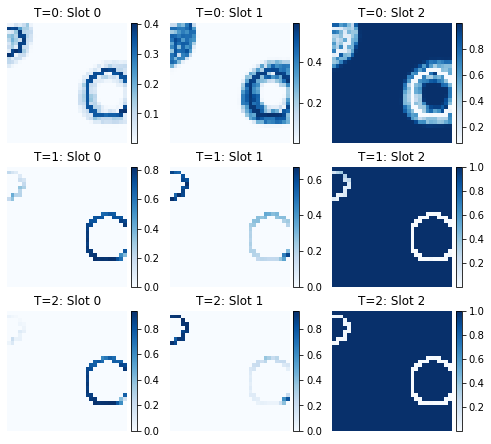

iter 30250 , loss 0.06756214 , lr 0.00019724141403076062


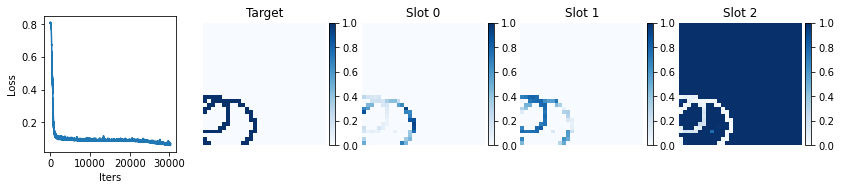

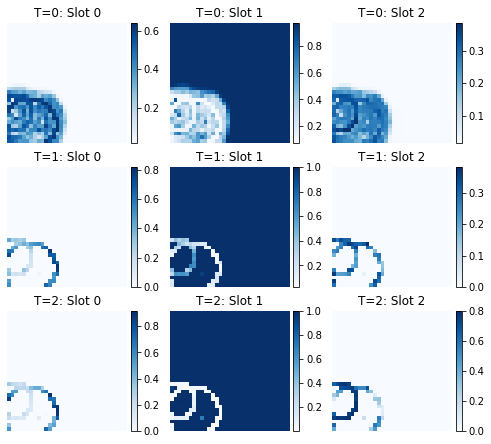

iter 30500 , loss 0.06602791 , lr 0.0001965590105787545


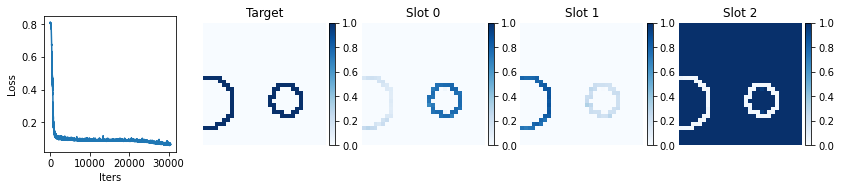

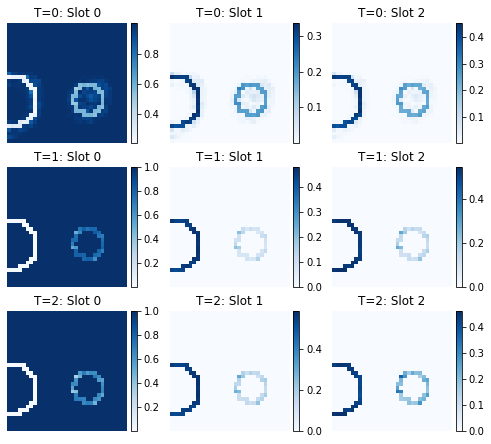

iter 30750 , loss 0.071898386 , lr 0.00019587896806333763


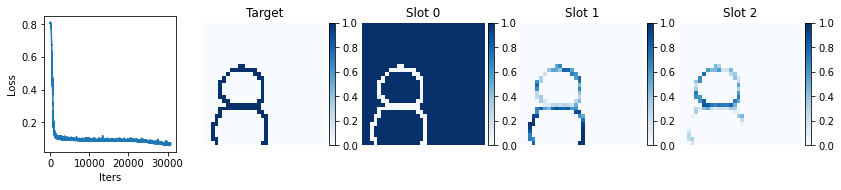

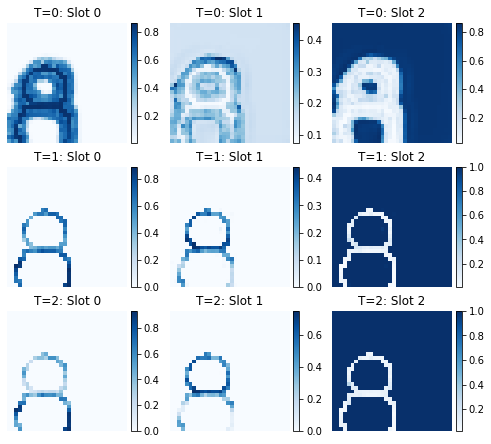

iter 31000 , loss 0.06500685 , lr 0.00019520127831629003


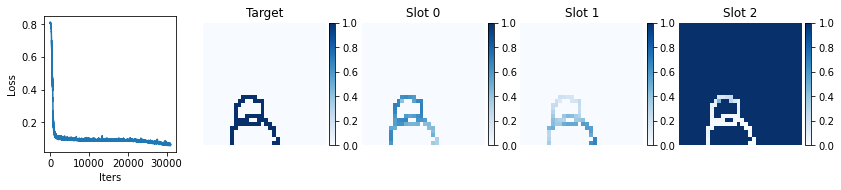

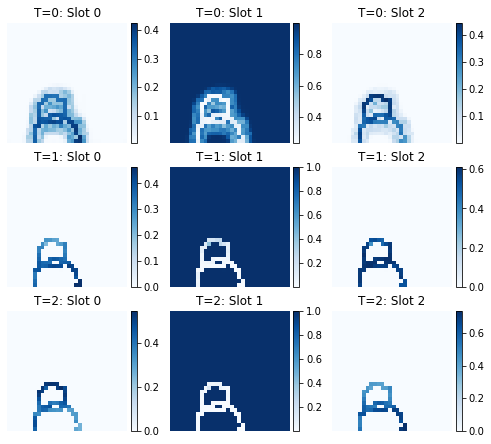

iter 31250 , loss 0.06178741 , lr 0.00019452593319765142


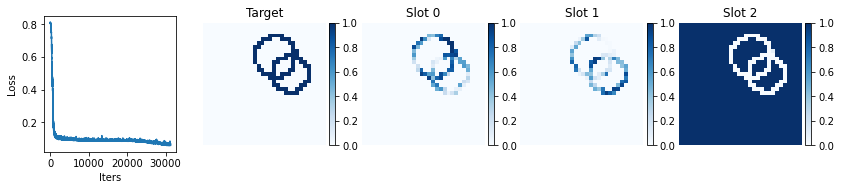

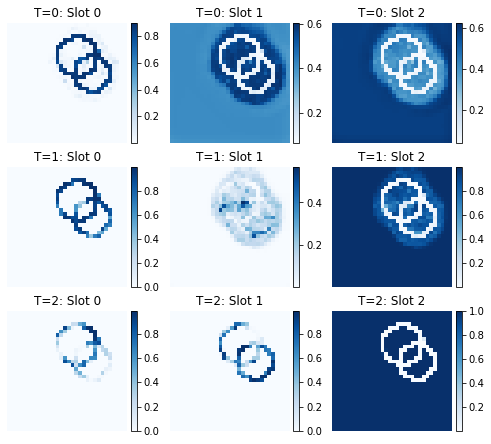

iter 31500 , loss 0.062275983 , lr 0.00019385292459562383


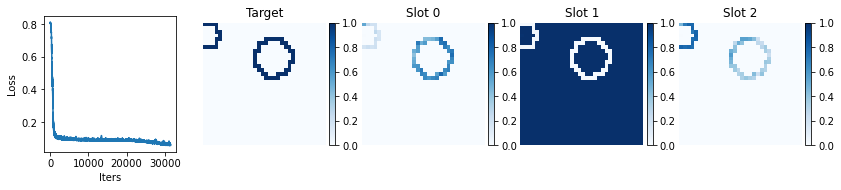

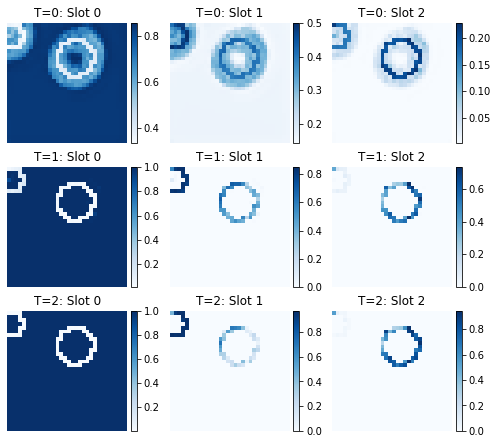

iter 31750 , loss 0.06398206 , lr 0.0001931822444264738


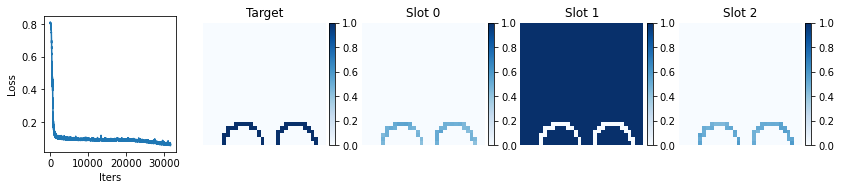

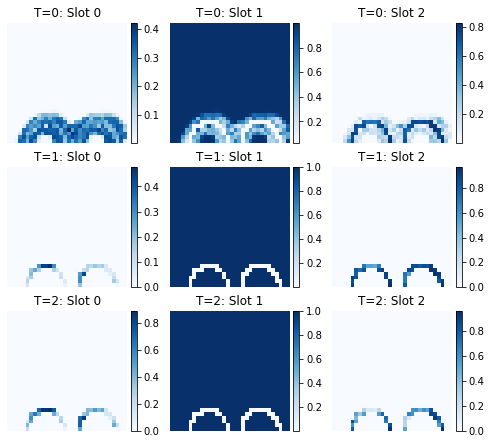

iter 32000 , loss 0.063995905 , lr 0.00019251388463443562


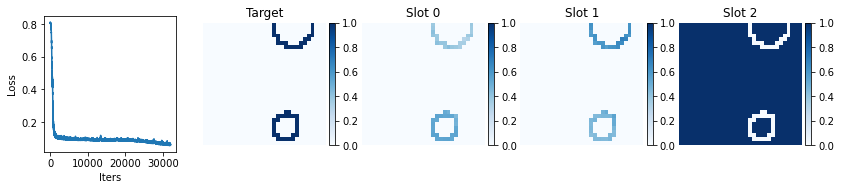

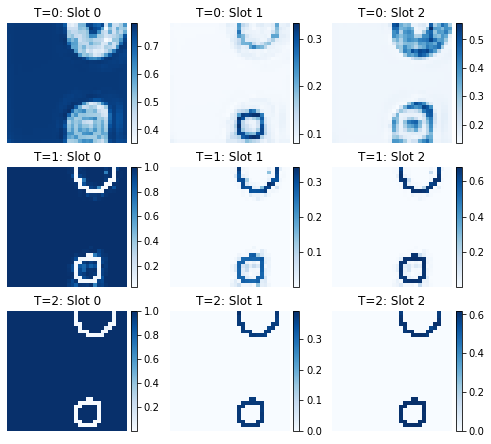

iter 32250 , loss 0.06491491 , lr 0.00019184783719161427


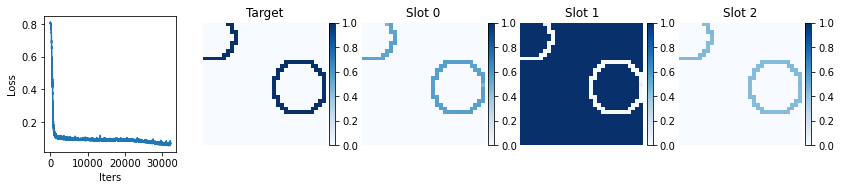

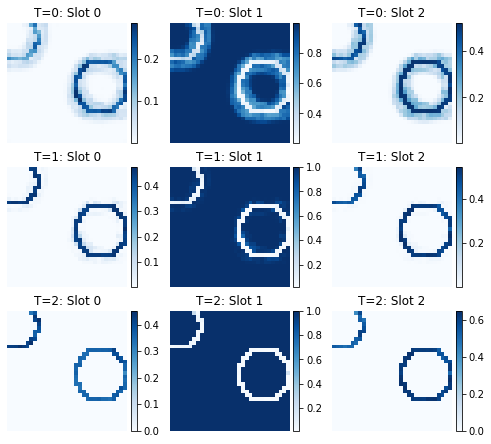

iter 32500 , loss 0.06626359 , lr 0.00019118409409788932


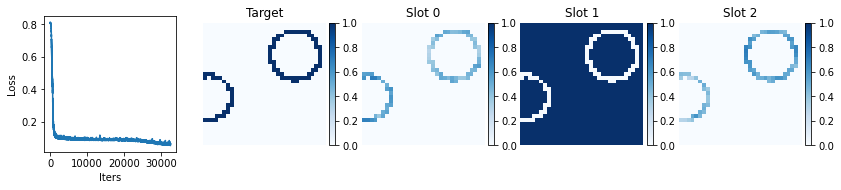

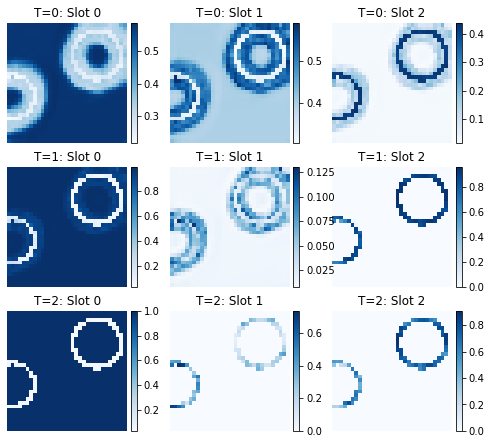

iter 32750 , loss 0.061583288 , lr 0.0001905226473808184


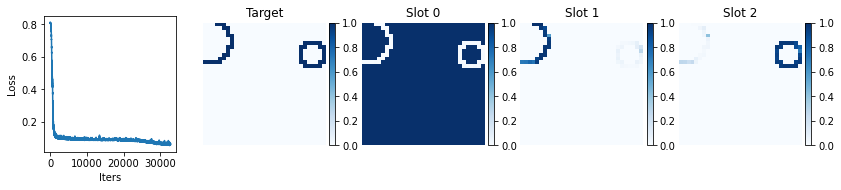

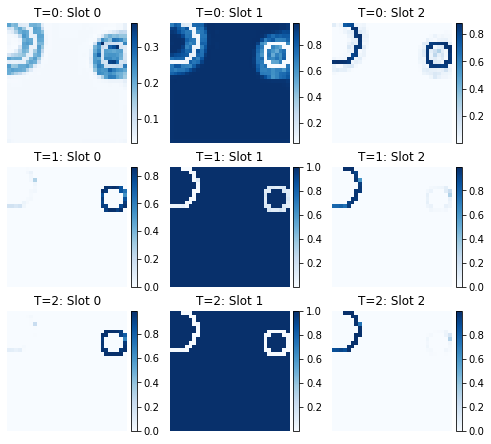

iter 33000 , loss 0.063879624 , lr 0.00018986348909554197


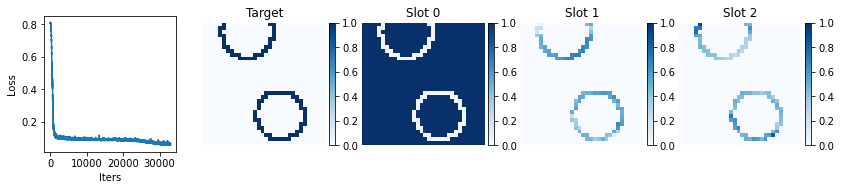

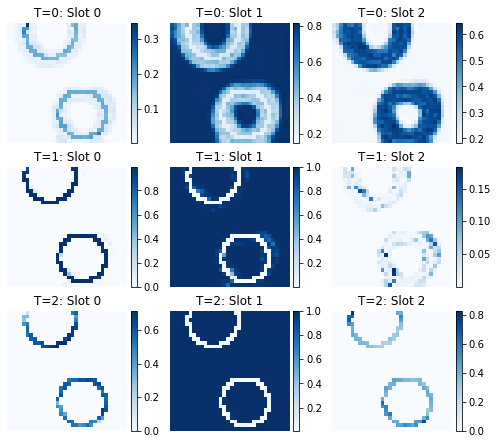

iter 33250 , loss 0.062848285 , lr 0.0001892066113246874


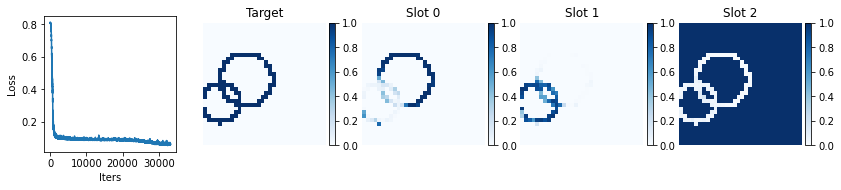

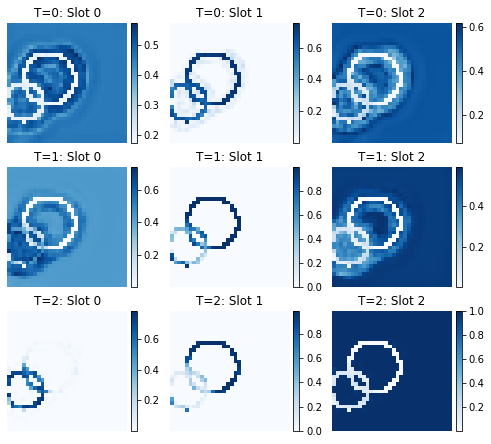

iter 33500 , loss 0.062358804 , lr 0.00018855200617827423


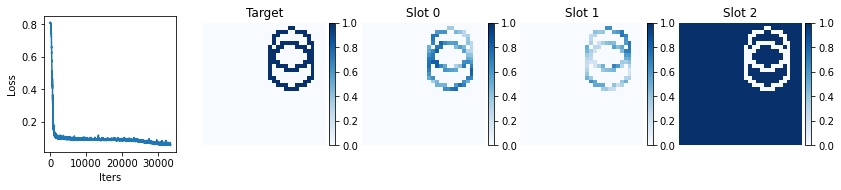

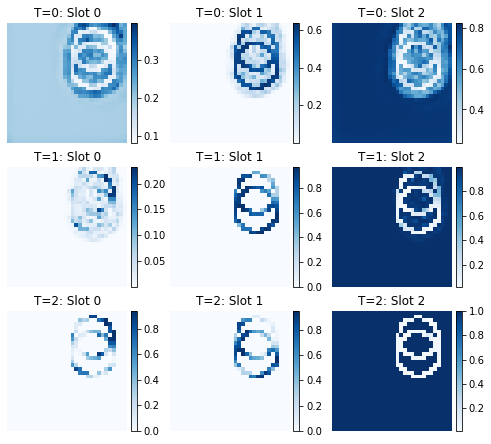

iter 33750 , loss 0.06354902 , lr 0.00018789966579361918


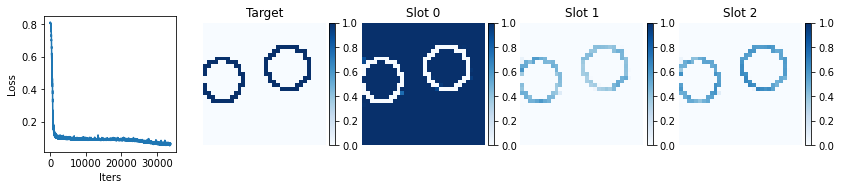

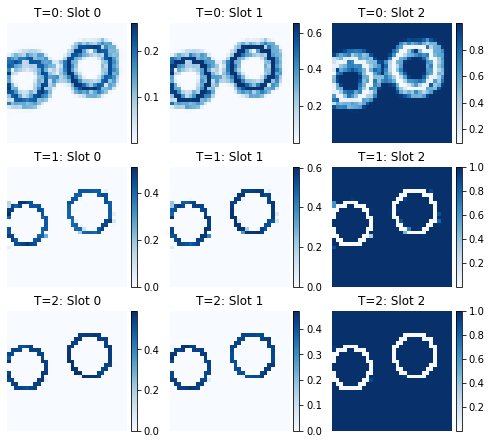

iter 34000 , loss 0.065358214 , lr 0.00018724958233524178


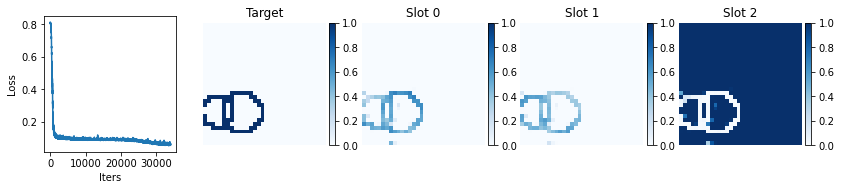

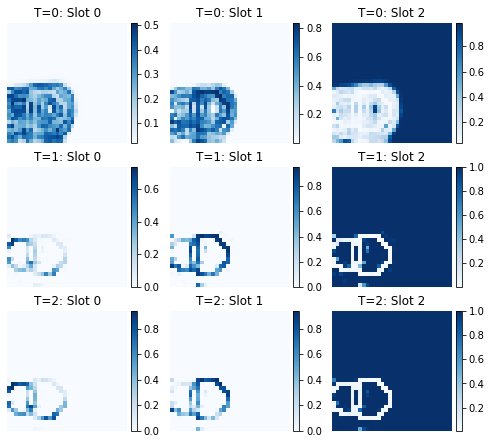

iter 34250 , loss 0.06284644 , lr 0.00018660174799477031


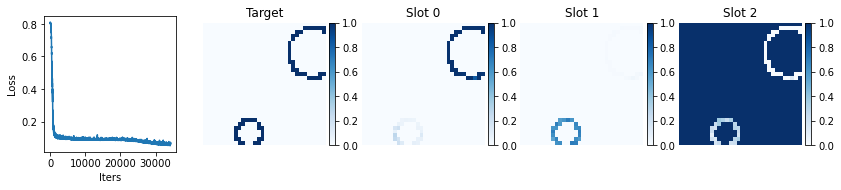

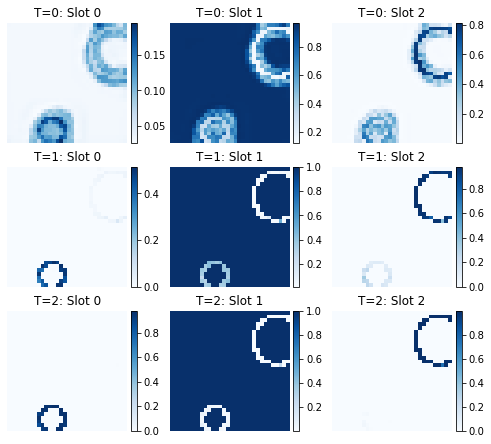

iter 34500 , loss 0.055995226 , lr 0.000185956154990848


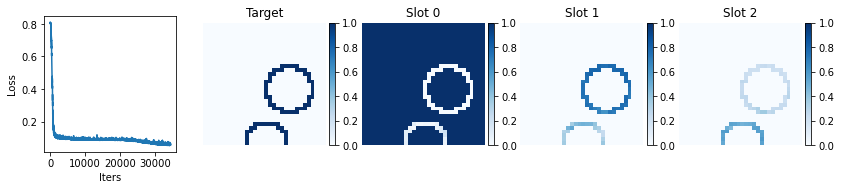

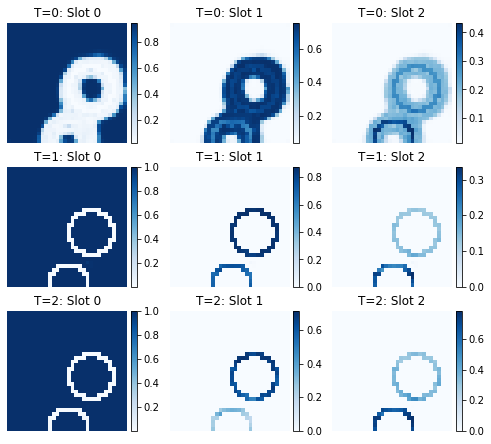

iter 34750 , loss 0.057338733 , lr 0.00018531279556903936


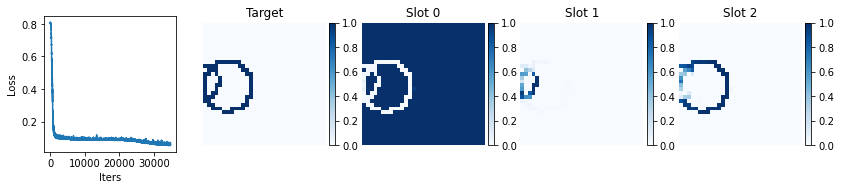

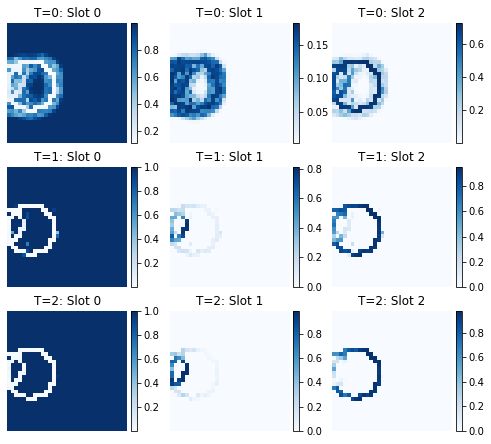

iter 35000 , loss 0.059663236 , lr 0.00018467166200173744


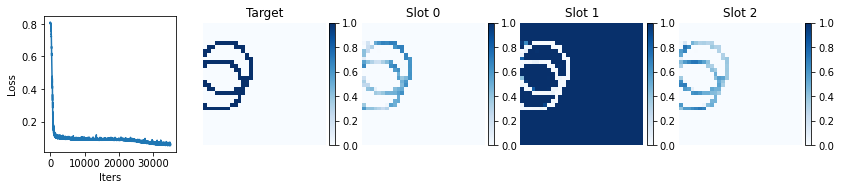

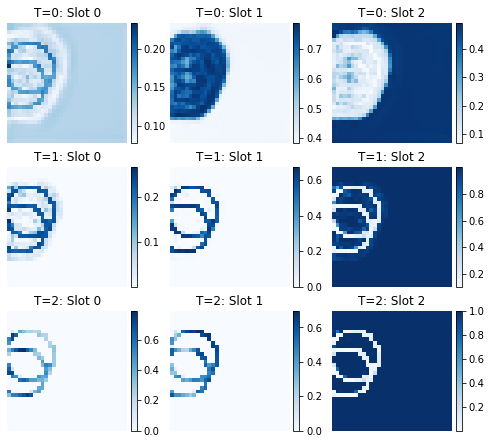

iter 35250 , loss 0.06029053 , lr 0.00018403274658807057


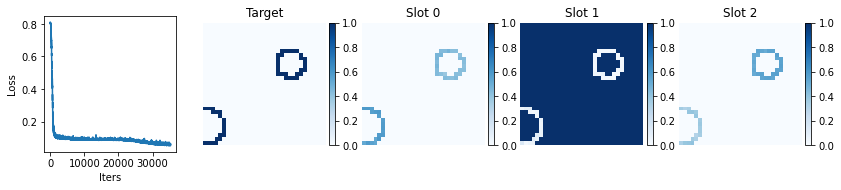

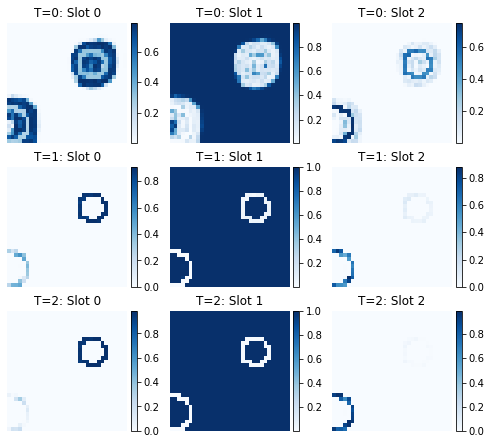

iter 35500 , loss 0.058741987 , lr 0.0001833960416538103


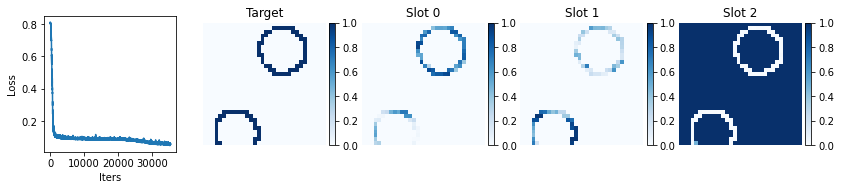

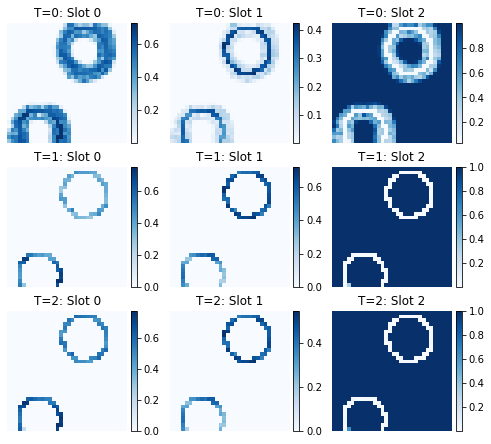

iter 35750 , loss 0.057678618 , lr 0.00018276153955127866


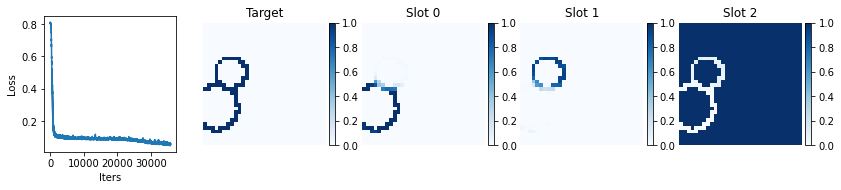

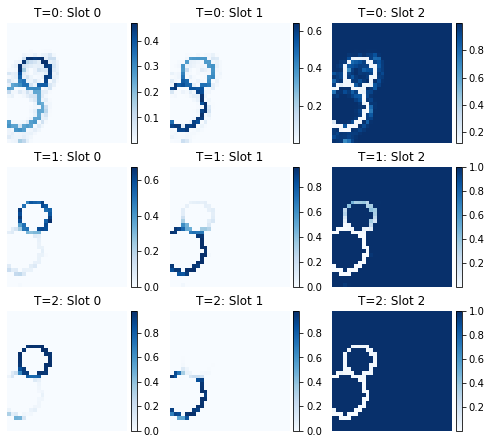

iter 36000 , loss 0.057842396 , lr 0.00018212923265925702


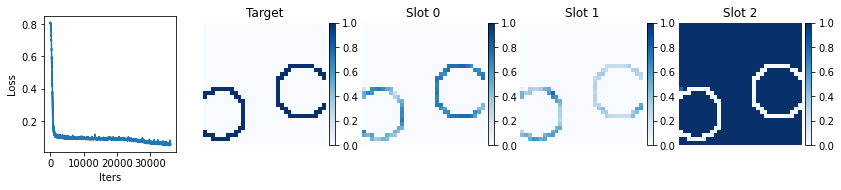

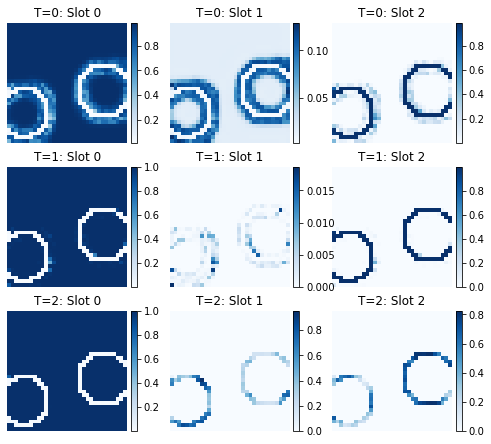

iter 36250 , loss 0.058468595 , lr 0.00018149911338289387


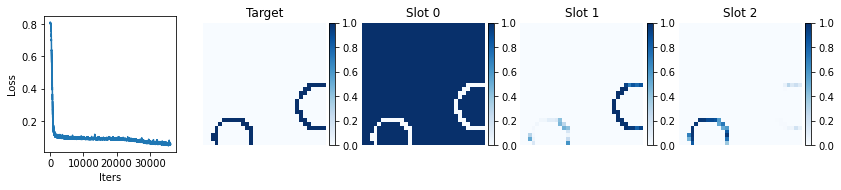

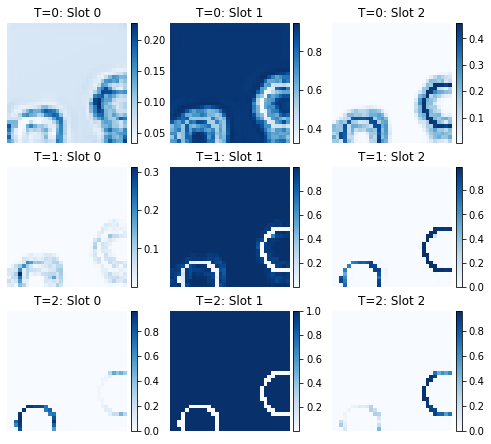

iter 36500 , loss 0.062056262 , lr 0.00018087117415361404


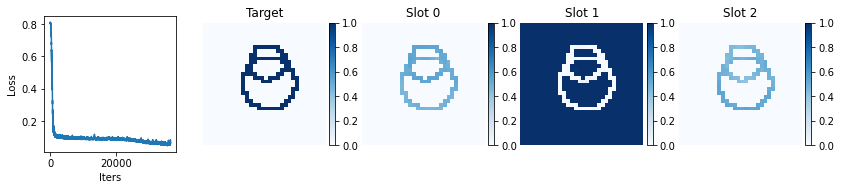

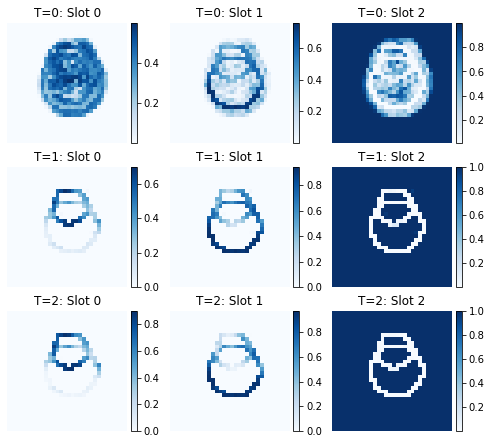

iter 36750 , loss 0.0578339 , lr 0.0001802454074290276


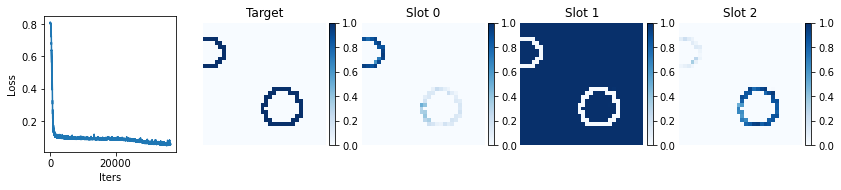

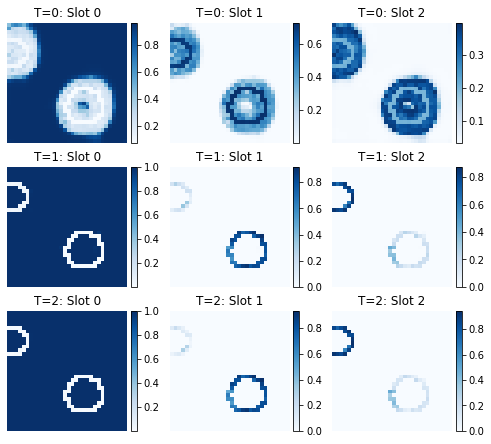

iter 37000 , loss 0.062321752 , lr 0.00017962180569283928


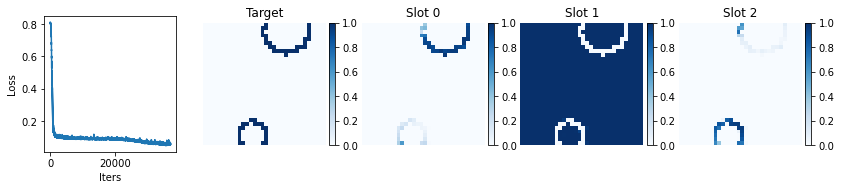

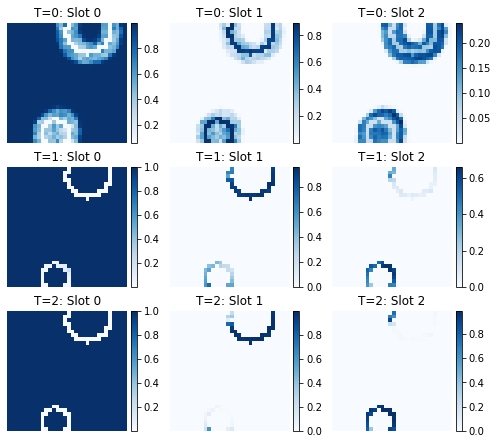

iter 37250 , loss 0.053003803 , lr 0.00017900036145475828


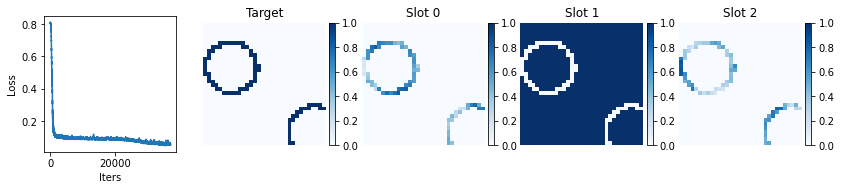

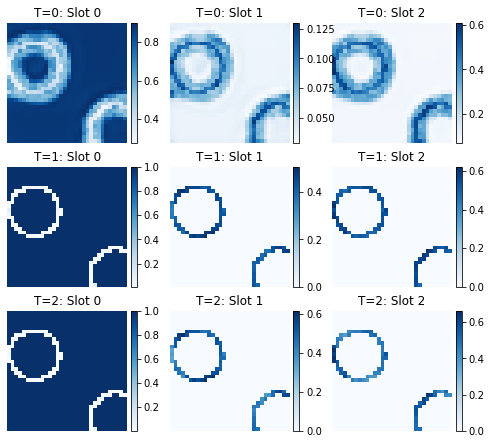

iter 37500 , loss 0.062346347 , lr 0.00017838106725040815


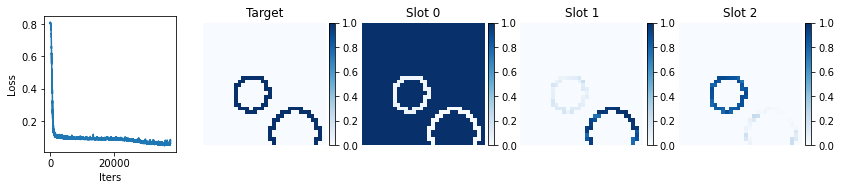

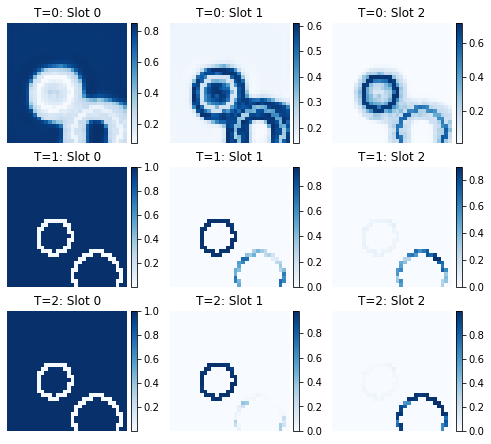

iter 37750 , loss 0.053938158 , lr 0.0001777639156412373


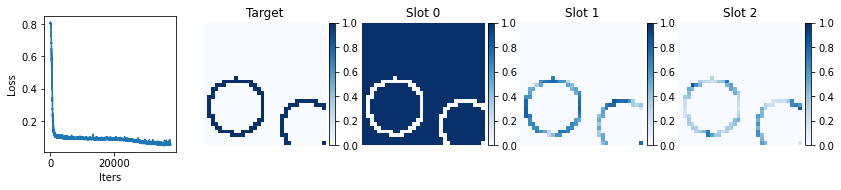

iter 38000 , loss 0.05574346 , lr 0.00017714889921442953


iter 38250 , loss 0.059491217 , lr 0.0001765360105828151


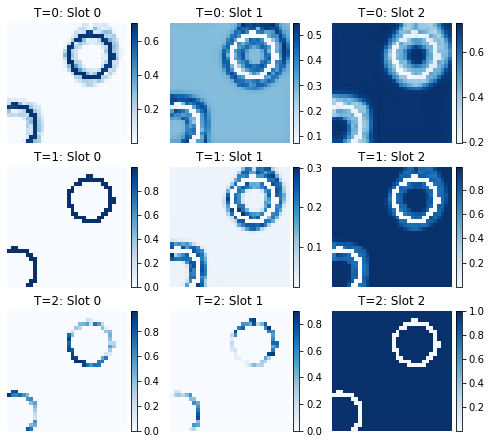

iter 38500 , loss 0.05482595 , lr 0.0001759252423847818


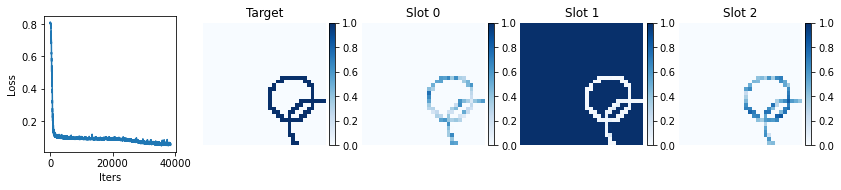

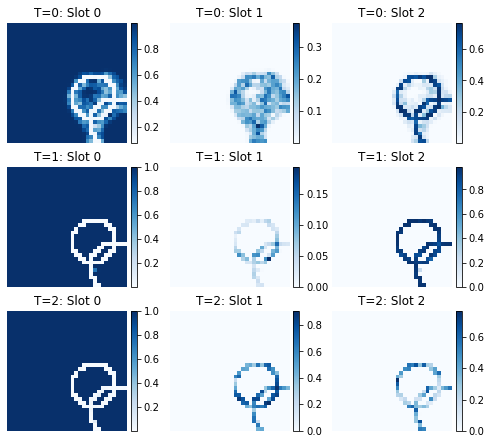

iter 38750 , loss 0.061163656 , lr 0.00017531658728418682


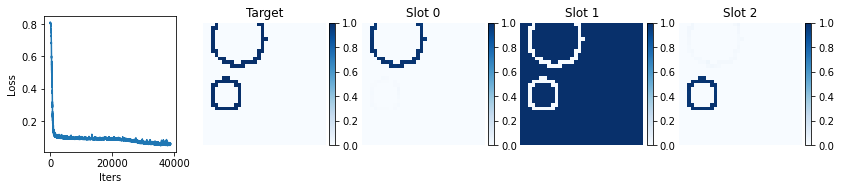

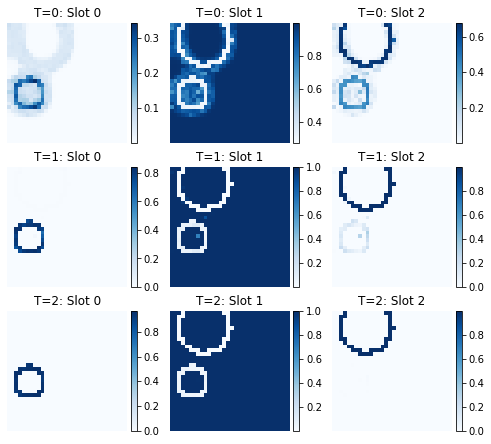

iter 39000 , loss 0.05600053 , lr 0.00017471003797026835


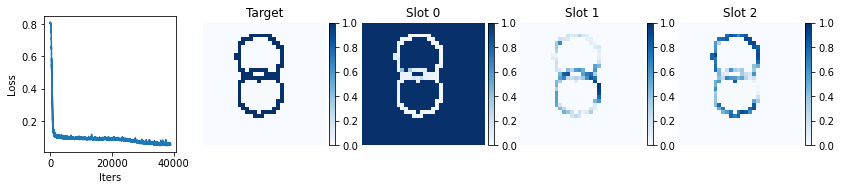

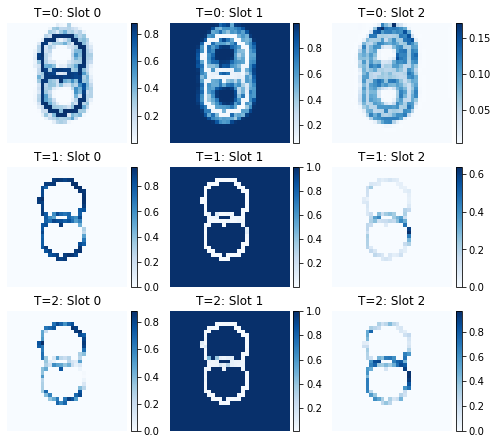

iter 39250 , loss 0.05410201 , lr 0.000174105587157558


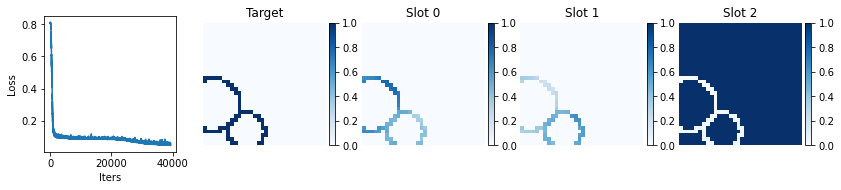

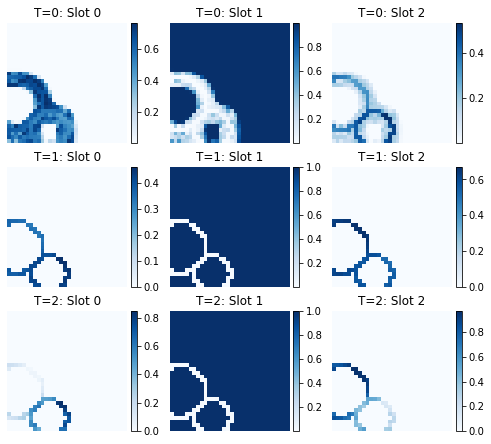

iter 39500 , loss 0.052091718 , lr 0.0001735032275857931


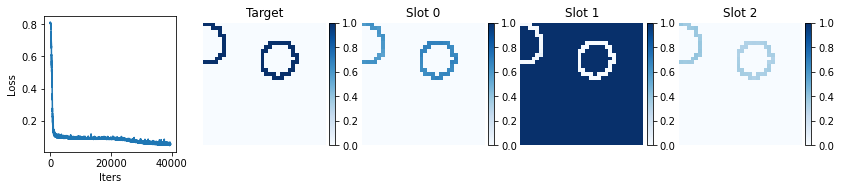

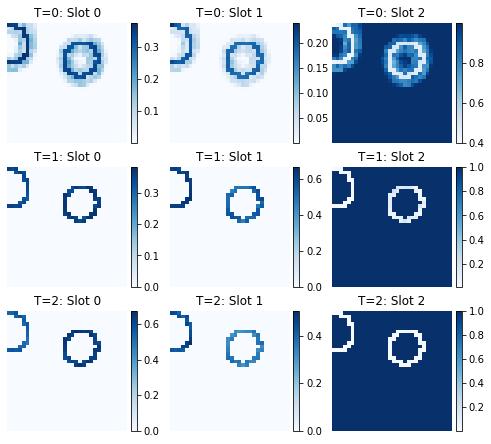

iter 39750 , loss 0.06810976 , lr 0.00017290295201982962


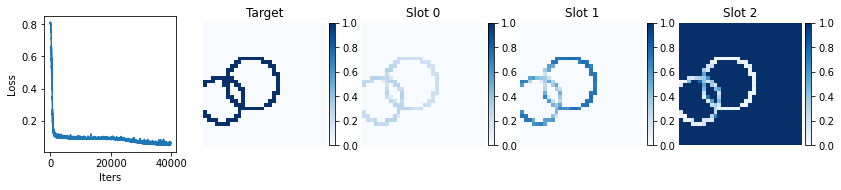

iter 40000 , loss 0.07593037 , lr 0.00017230475324955523


iter 40250 , loss 0.06941131 , lr 0.0001717086240898027


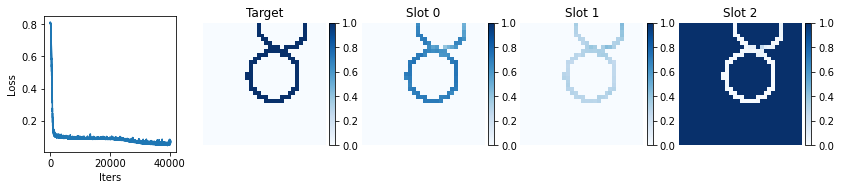

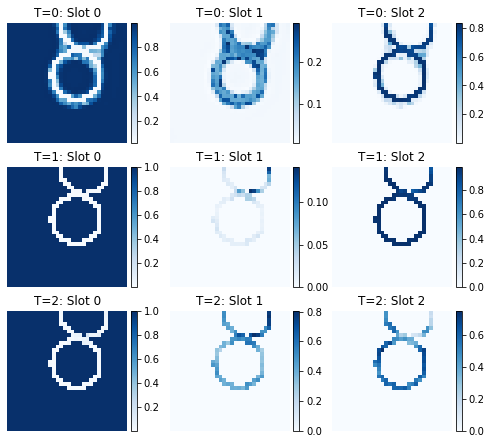

iter 40500 , loss 0.057593703 , lr 0.00017111455738026354


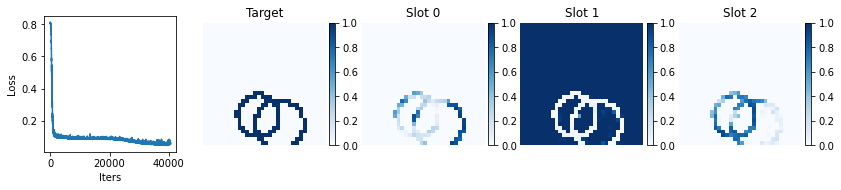

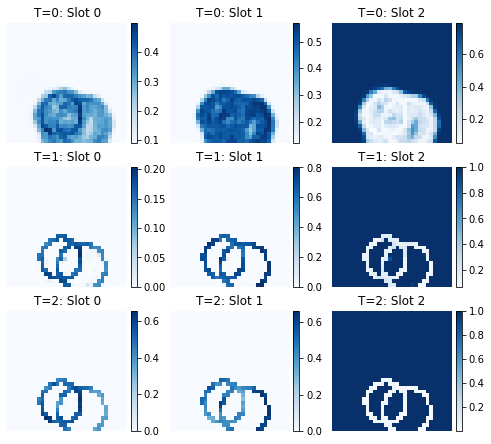

iter 40750 , loss 0.055613376 , lr 0.0001705225459854021


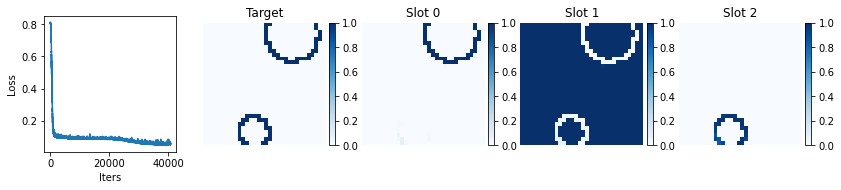

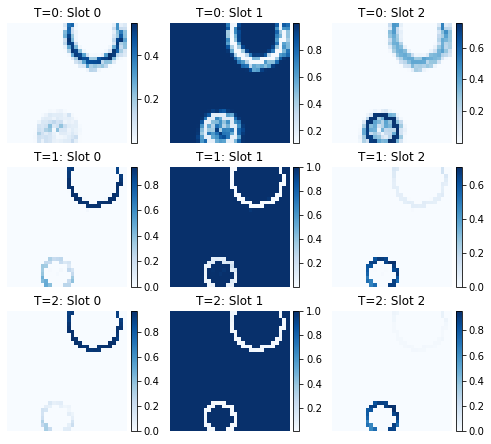

iter 41000 , loss 0.058313195 , lr 0.0001699325827943698


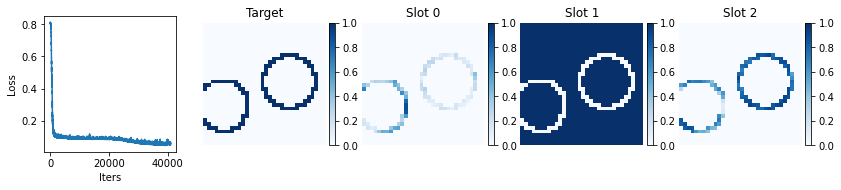

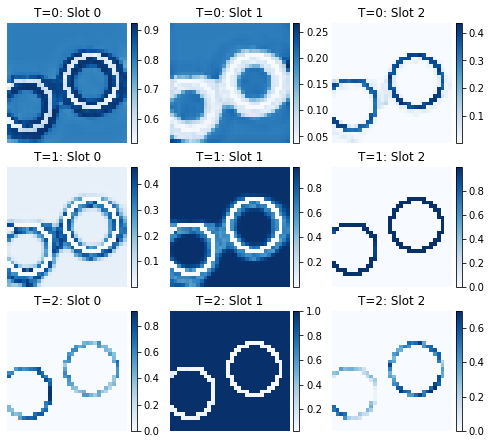

iter 41250 , loss 0.053015843 , lr 0.0001693446607209197


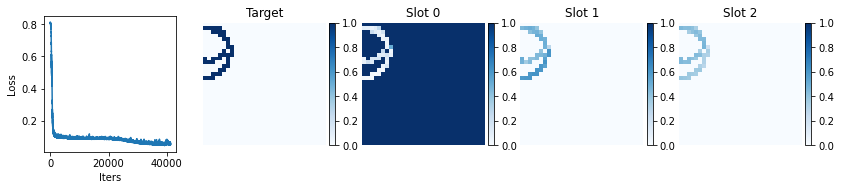

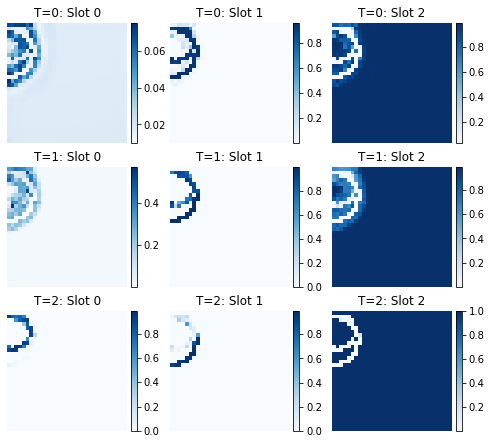

iter 41500 , loss 0.052866906 , lr 0.0001687587727033214


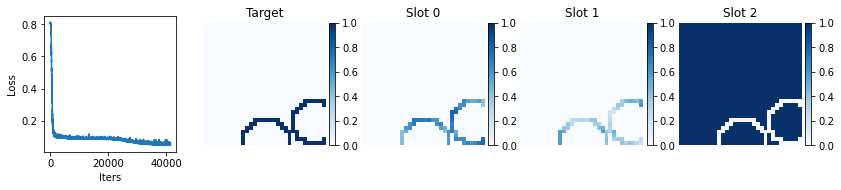

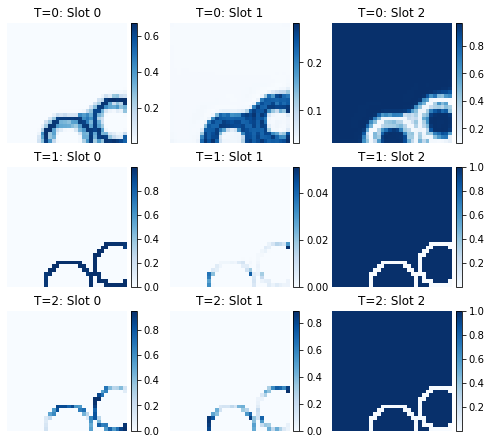

iter 41750 , loss 0.05694333 , lr 0.0001681749117042763


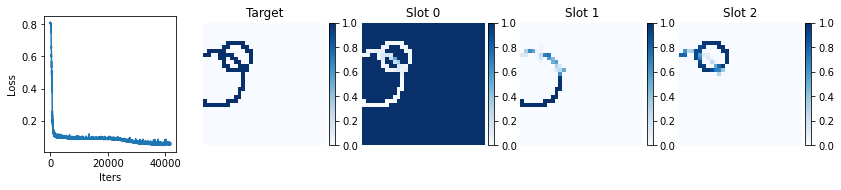

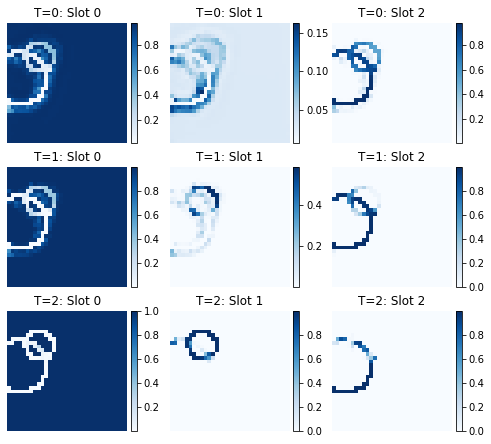

iter 42000 , loss 0.056743126 , lr 0.000167593070710833


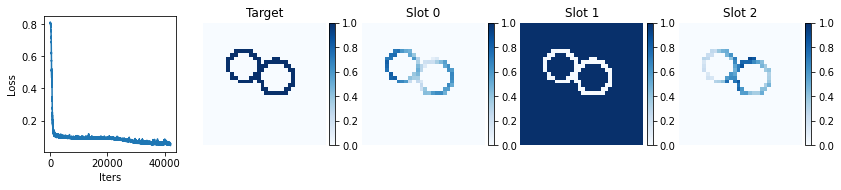

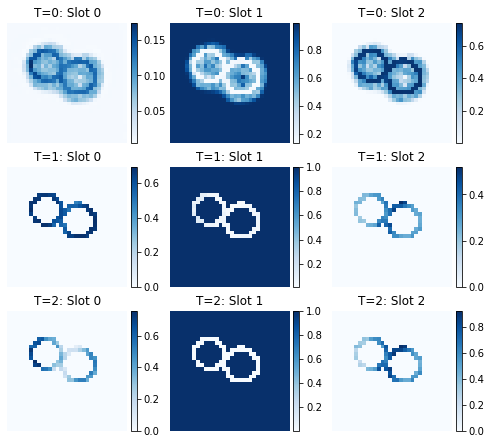

iter 42250 , loss 0.0555305 , lr 0.00016701324273430296


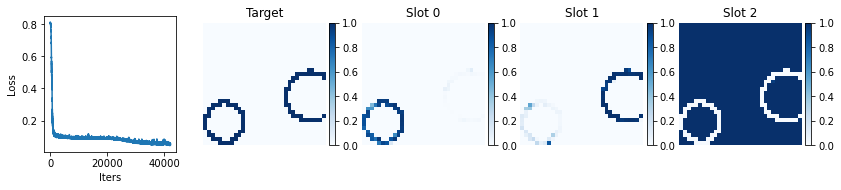

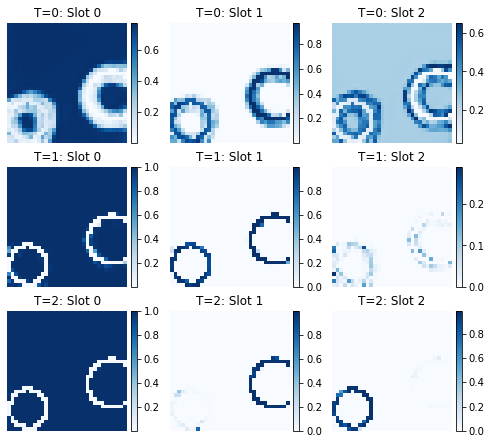

iter 42500 , loss 0.052628018 , lr 0.00016643542081017676


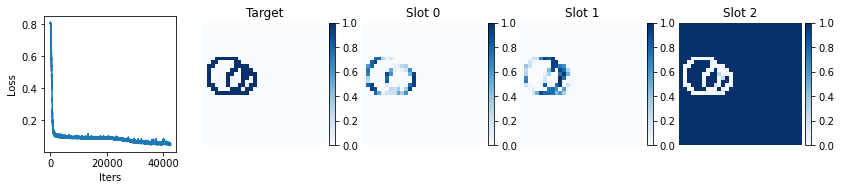

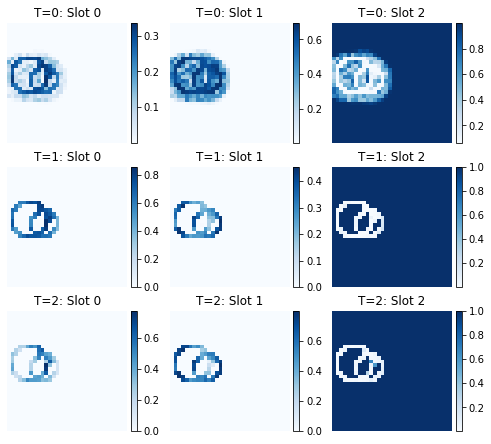

iter 42750 , loss 0.054127857 , lr 0.00016585959799804033


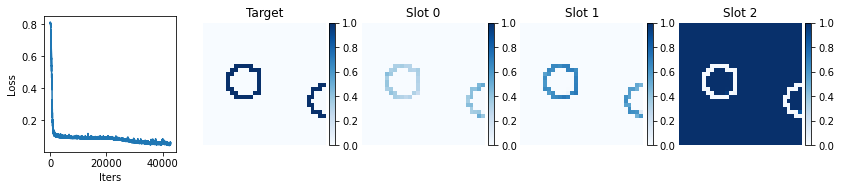

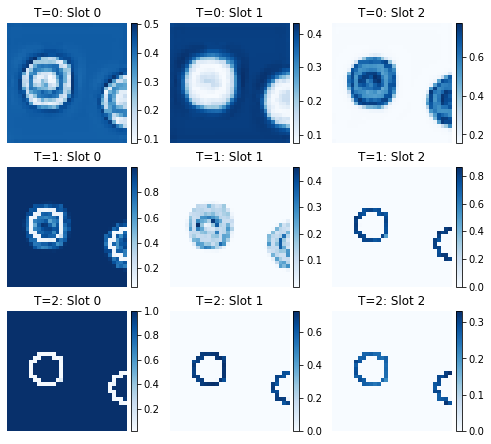

iter 43000 , loss 0.0566796 , lr 0.0001652857673814916


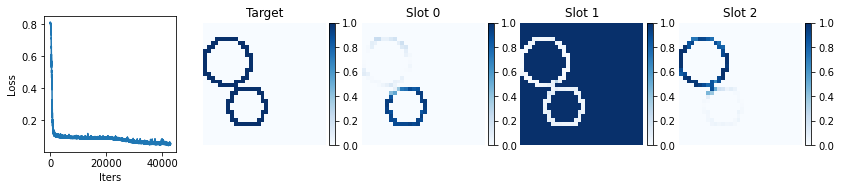

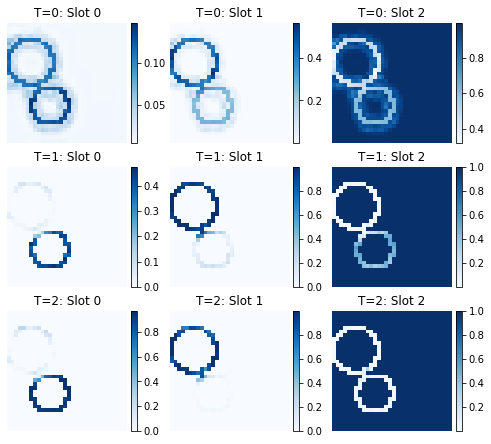

iter 43250 , loss 0.054079574 , lr 0.00016471392206805747


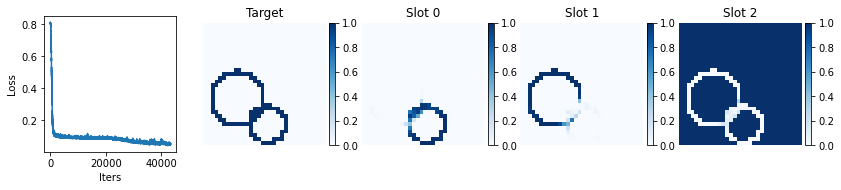

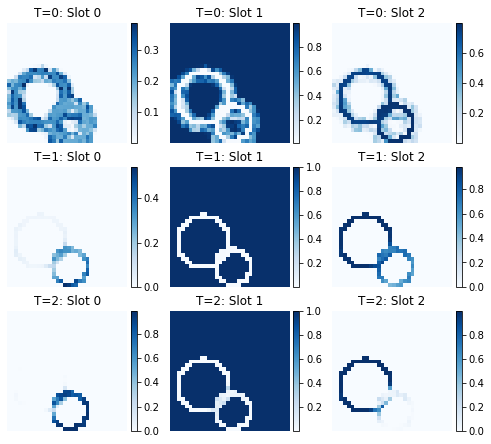

iter 43500 , loss 0.058155254 , lr 0.0001641440551891109


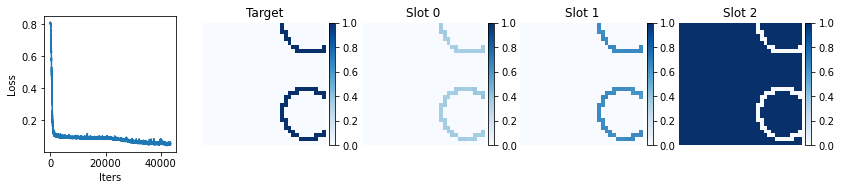

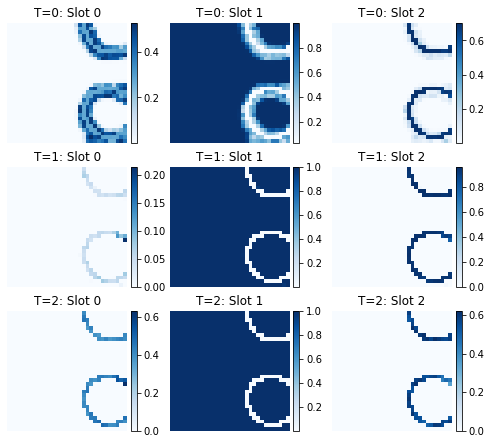

iter 43750 , loss 0.050493017 , lr 0.00016357615989978863


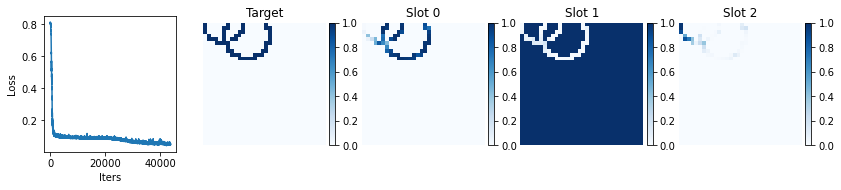

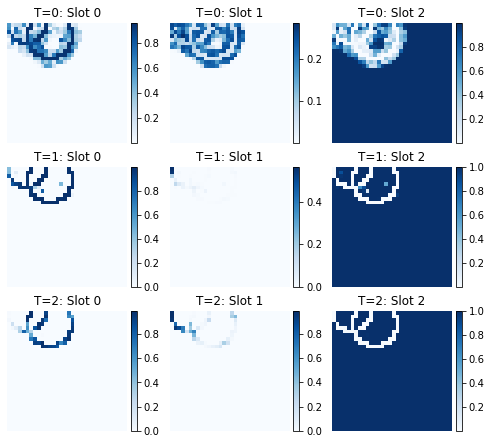

iter 44000 , loss 0.0655086 , lr 0.0001630102293789087


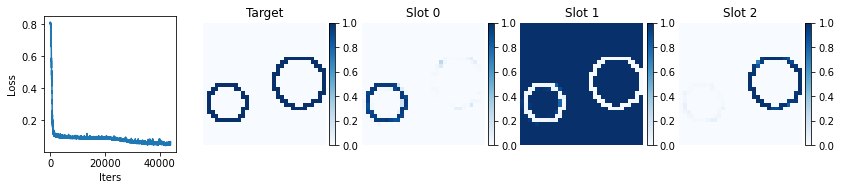

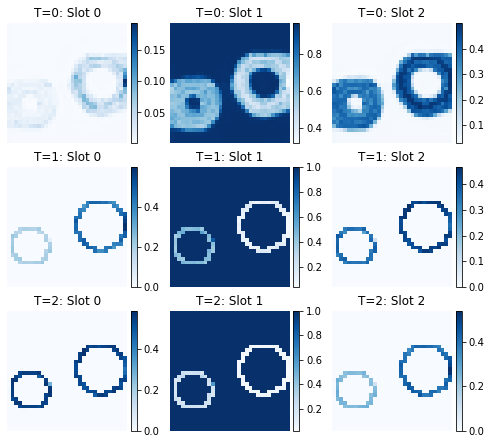

iter 44250 , loss 0.04910514 , lr 0.0001624462568288887


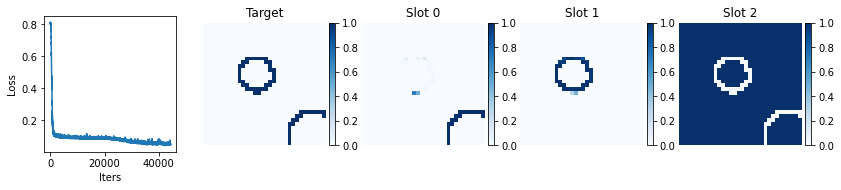

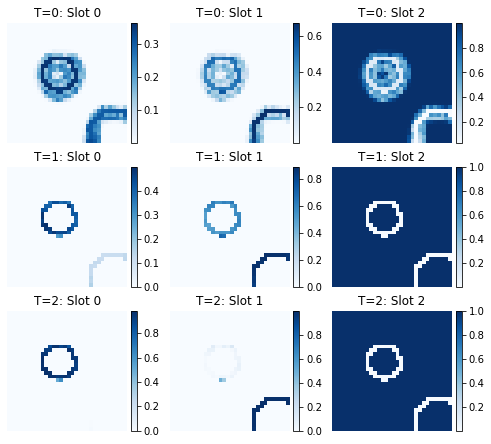

iter 44500 , loss 0.054424874 , lr 0.00016188423547566406


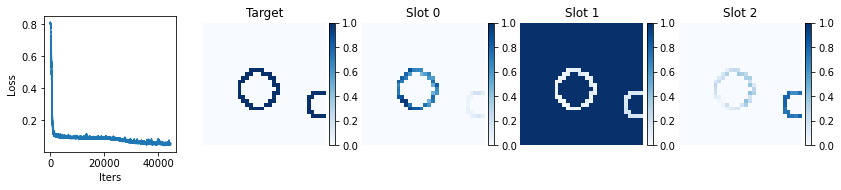

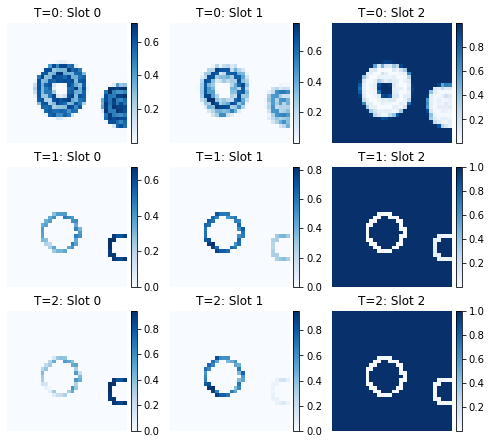

iter 44750 , loss 0.051619858 , lr 0.00016132415856860672


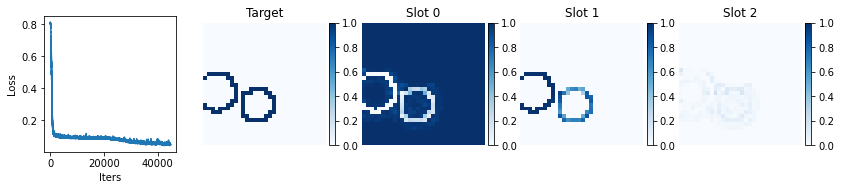

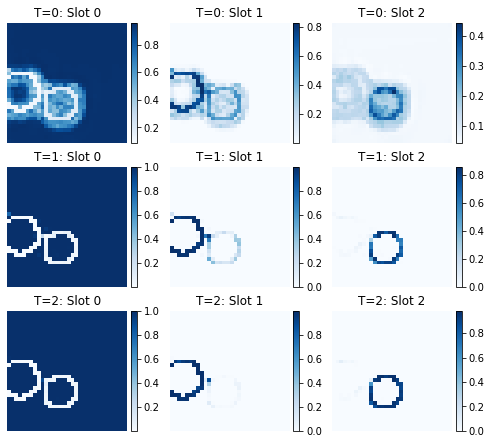

iter 45000 , loss 0.053456414 , lr 0.00016076601938044396


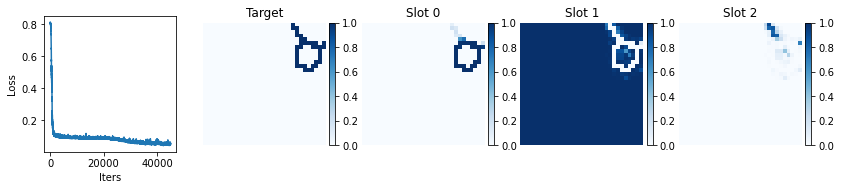

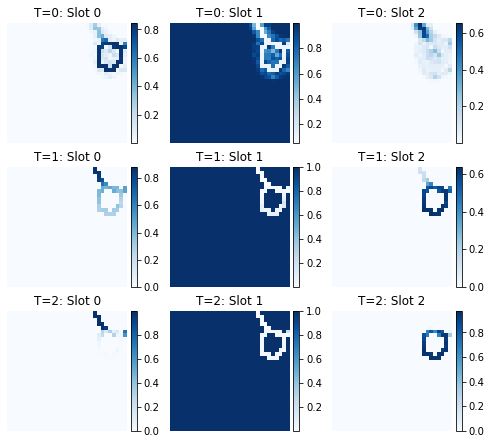

iter 45250 , loss 0.0524778 , lr 0.0001602098112071777


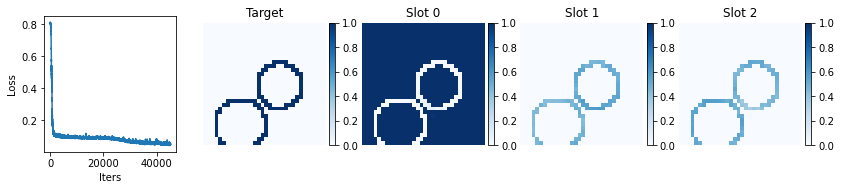

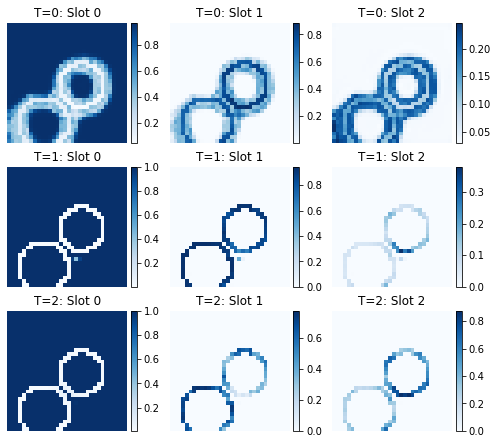

iter 45500 , loss 0.050389007 , lr 0.00015965552736800395


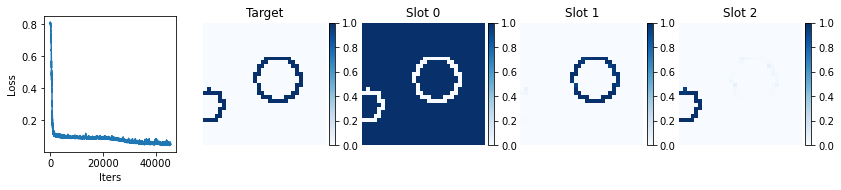

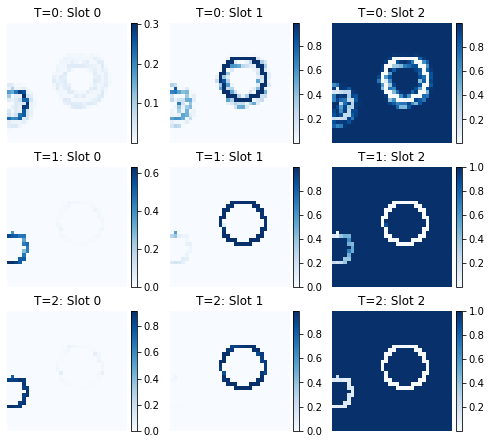

iter 45750 , loss 0.04947983 , lr 0.00015910316120523252


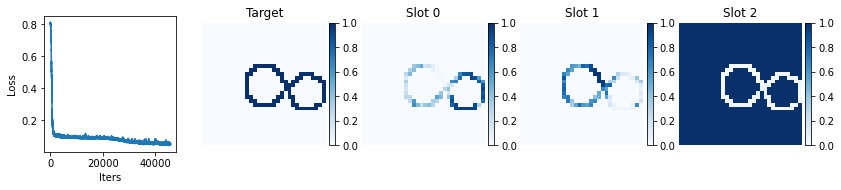

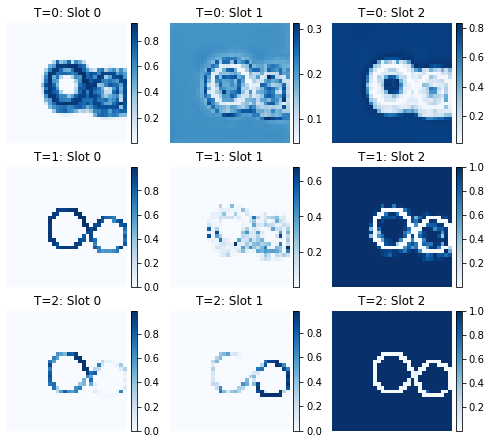

iter 46000 , loss 0.05147197 , lr 0.00015855270608420704


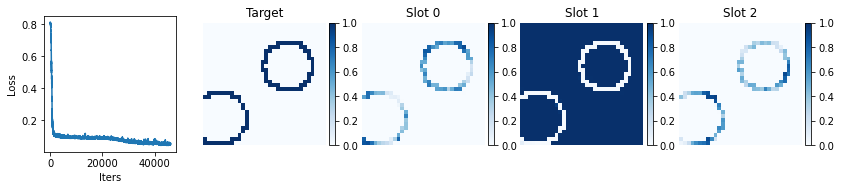

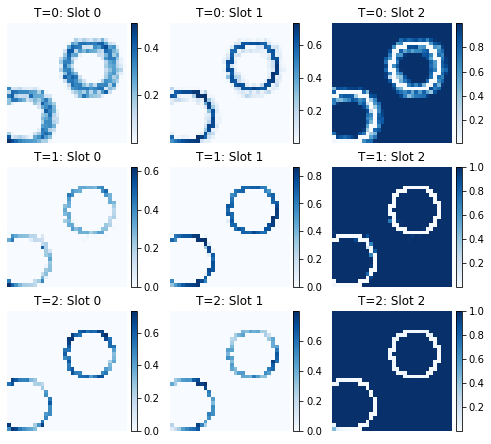

In [ ]:
train(sa, 
      **opt,
      losses=[],
      kwargs=kwargs,
      device=device,
      modelDir=modelDir,figDir=figDir)